In [1]:
!pip install torch torchvision torchaudio gymnasium pandas numpy matplotlib tqdm mpmath==1.2.1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.6/532.6 kB 14.5 MB/s eta 0:00:00
  Attempting uninstall: mpmath
    Found existing installation: mpmath 1.3.0
    Uninstalling mpmath-1.3.0:
      Successfully uninstalled mpmath-1.3.0


In [2]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


In [ ]:
data = pd.read_csv("trainrl_data.csv")

# Drop timestamp or non-numeric columns if they exist
if 'timestamp' in data.columns:
    data = data.drop(columns=['timestamp'])

# Ensure numeric and fill missing values
data = data.apply(pd.to_numeric, errors='coerce').fillna(0)

print("Shape:", data.shape)
data.head()


Shape: (1400, 31)


,location_id,traffic_volume,avg_vehicle_speed,vehicle_count_cars,vehicle_count_trucks,vehicle_count_bikes,weather_condition,temperature,humidity,accident_reported,...,bike_ratio,weather_impact,weather_Cloudy,weather_Foggy,weather_Rainy,weather_Sunny,weather_Windy,signal_Green,signal_Red,signal_Yellow
0,1.00,0.902954,0.800401,0.098976,0.545455,1.000000,0.0,0.979439,0.537649,0,...,0.342553,0.652536,True,False,False,False,False,False,False,True
1,0.75,0.161392,0.319762,0.440273,0.424242,0.775510,0.0,0.884096,0.048955,0,...,0.114553,0.265677,False,False,False,True,False,False,True,False
2,0.00,0.875527,0.599970,0.240046,0.181818,0.489796,0.0,0.132513,0.284103,0,...,0.129062,0.112905,False,False,False,False,True,False,True,False
3,0.50,0.952532,0.408853,0.609784,0.373737,0.857143,0.0,0.941542,0.890744,0,...,0.097102,0.883883,False,False,True,False,False,False,False,True
4,0.00,0.181435,0.544669,0.489192,0.868687,0.836735,0.0,0.472614,0.465641,0,...,0.104318,0.339227,False,False,False,False,True,False,True,False


In [ ]:
class TrafficEnv(gym.Env):
    def __init__(self, data):
        super(TrafficEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.max_index = len(data) - 1

        # Define spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(len(data.columns)-1,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)  # 4 signal phases

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Start from a random point in dataset
        self.current_step = np.random.randint(0, self.max_index - 50)
        obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32)
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_index

        row = self.data.iloc[self.current_step]
        wait_time = row.get('waiting_time', 0)
        queue_len = row.get('queue_length', 0)
        emergency = row.get('emergency_detected', 0) if 'emergency_detected' in row else 0

        reward = self.compute_reward(wait_time, queue_len, emergency, action)
        next_obs = row[:-1].values.astype(np.float32)
        truncated = False
        info = {}

        return next_obs, reward, done, truncated, info

    def compute_reward(self, wait_time, queue_len, emergency_detected, action):
        reward = - (0.7 * wait_time + 0.3 * queue_len)
        if emergency_detected and action == 0:  # example: NS-green helps emergency
            reward += 20
        return reward

    def render(self):
        pass


In [ ]:
'''def compute_reward(wait_time, queue_len, emergency_detected):

    reward = - (0.7 * wait_time + 0.3 * queue_len)
    if emergency_detected:
        reward += 20  # positive reward for prioritizing emergency
    return reward'''


In [ ]:
class PPOAgent(nn.Module):
    def __init__(self, state_dim, action_dim, lr=1e-4):
        super(PPOAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def act(self, state):
        state = torch.FloatTensor(state)
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        action = dist.sample()
        return action.item(), dist.log_prob(action)

    def evaluate(self, state, action):
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return log_prob, self.critic(state), entropy


In [ ]:
env = TrafficEnv(data)
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)


import torch
import json
import os
from tqdm import tqdm

def train_ppo(
    episodes=200,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    reward_history = []

    # Resume from saved rewards if file exists
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"✅ Loaded {len(reward_history)} previous rewards from '{rewards_path}'")

    # Continue training for new episodes
    for episode in tqdm(range(len(reward_history), len(reward_history) + episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # PPO update
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {episode + 1} | Total Reward: {total_reward:.2f}")

        # Save model & rewards every 10 episodes
        if (episode + 1) % 10 == 0:
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print(f"💾 Progress saved — {episode + 1} episodes complete")

    print("Training complete!")
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    return reward_history


rewards = train_ppo(episodes=500)


In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_500.pt")
print("Model saved successfully!")


Model saved successfully!


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

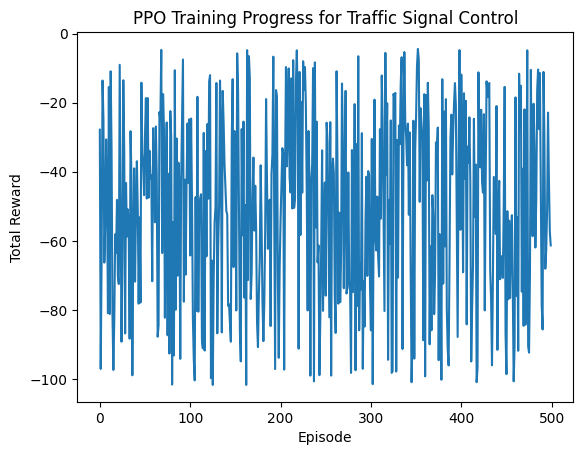

In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control")
plt.show()


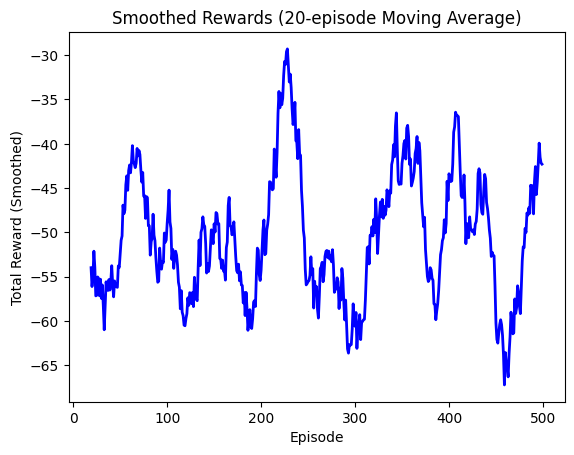

In [ ]:
import pandas as pd
plt.plot(pd.Series(rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()


In [ ]:
!pip install stable_baselines3

# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("/content/ppo_traffic_model_500.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 13.0 MB/s eta 0:00:00
Model loaded successfully!


In [ ]:
print("Continuing training for 500 more episodes...")
new_rewards = train_ppo(episodes=500)
rewards.extend(new_rewards)
print("Training complete.")

Continuing training for 500 more episodes...
✅ Loaded 500 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:04<35:37,  4.28s/it]

Episode 501 | Total Reward: -84.14


  0%|          | 2/500 [00:06<25:26,  3.07s/it]

Episode 502 | Total Reward: -46.26


  1%|          | 3/500 [00:08<21:35,  2.61s/it]

Episode 503 | Total Reward: -45.38


  1%|          | 4/500 [00:12<25:52,  3.13s/it]

Episode 504 | Total Reward: -93.36


  1%|          | 5/500 [00:13<18:19,  2.22s/it]

Episode 505 | Total Reward: -14.37


  1%|          | 6/500 [00:15<19:02,  2.31s/it]

Episode 506 | Total Reward: -52.07


  1%|▏         | 7/500 [00:18<21:24,  2.61s/it]

Episode 507 | Total Reward: -66.39


  2%|▏         | 8/500 [00:20<19:33,  2.38s/it]

Episode 508 | Total Reward: -41.28


  2%|▏         | 9/500 [00:21<14:26,  1.76s/it]

Episode 509 | Total Reward: -10.25


  2%|▏         | 10/500 [00:23<16:53,  2.07s/it]

Episode 510 | Total Reward: -63.58
💾 Progress saved — 510 episodes complete


  2%|▏         | 11/500 [00:28<22:06,  2.71s/it]

Episode 511 | Total Reward: -91.54


  2%|▏         | 12/500 [00:28<17:09,  2.11s/it]

Episode 512 | Total Reward: -13.15


  3%|▎         | 13/500 [00:32<21:56,  2.70s/it]

Episode 513 | Total Reward: -96.17


  3%|▎         | 14/500 [00:33<17:05,  2.11s/it]

Episode 514 | Total Reward: -18.31


  3%|▎         | 15/500 [00:37<20:49,  2.58s/it]

Episode 515 | Total Reward: -84.14


  3%|▎         | 16/500 [00:38<16:57,  2.10s/it]

Episode 516 | Total Reward: -23.93


  3%|▎         | 17/500 [00:38<13:29,  1.68s/it]

Episode 517 | Total Reward: -16.55


  4%|▎         | 18/500 [00:41<14:59,  1.87s/it]

Episode 518 | Total Reward: -39.39


  4%|▍         | 19/500 [00:43<16:55,  2.11s/it]

Episode 519 | Total Reward: -53.98


  4%|▍         | 20/500 [00:45<16:02,  2.00s/it]

Episode 520 | Total Reward: -33.68
💾 Progress saved — 520 episodes complete


  4%|▍         | 21/500 [00:49<20:46,  2.60s/it]

Episode 521 | Total Reward: -93.99


  4%|▍         | 22/500 [00:52<22:28,  2.82s/it]

Episode 522 | Total Reward: -66.39


  5%|▍         | 23/500 [00:56<23:45,  2.99s/it]

Episode 523 | Total Reward: -79.22


  5%|▍         | 24/500 [00:58<21:40,  2.73s/it]

Episode 524 | Total Reward: -50.12


  5%|▌         | 25/500 [00:59<17:17,  2.18s/it]

Episode 525 | Total Reward: -20.79


  5%|▌         | 26/500 [01:03<20:48,  2.63s/it]

Episode 526 | Total Reward: -87.29


  5%|▌         | 27/500 [01:07<24:29,  3.11s/it]

Episode 527 | Total Reward: -86.63


  6%|▌         | 28/500 [01:09<22:05,  2.81s/it]

Episode 528 | Total Reward: -47.43


  6%|▌         | 29/500 [01:10<18:18,  2.33s/it]

Episode 529 | Total Reward: -28.50


  6%|▌         | 30/500 [01:13<19:26,  2.48s/it]

Episode 530 | Total Reward: -66.58
💾 Progress saved — 530 episodes complete


  6%|▌         | 31/500 [01:17<22:58,  2.94s/it]

Episode 531 | Total Reward: -59.79


  6%|▋         | 32/500 [01:19<21:07,  2.71s/it]

Episode 532 | Total Reward: -42.07


  7%|▋         | 33/500 [01:20<15:42,  2.02s/it]

Episode 533 | Total Reward: -10.03


  7%|▋         | 34/500 [01:21<14:23,  1.85s/it]

Episode 534 | Total Reward: -34.53


  7%|▋         | 35/500 [01:24<17:59,  2.32s/it]

Episode 535 | Total Reward: -79.90


  7%|▋         | 36/500 [01:26<16:48,  2.17s/it]

Episode 536 | Total Reward: -43.26


  7%|▋         | 37/500 [01:30<21:30,  2.79s/it]

Episode 537 | Total Reward: -85.53


  8%|▊         | 38/500 [01:33<21:30,  2.79s/it]

Episode 538 | Total Reward: -66.27


  8%|▊         | 39/500 [01:34<16:42,  2.18s/it]

Episode 539 | Total Reward: -17.29


  8%|▊         | 40/500 [01:35<14:10,  1.85s/it]

Episode 540 | Total Reward: -25.47
💾 Progress saved — 540 episodes complete


  8%|▊         | 41/500 [01:36<12:36,  1.65s/it]

Episode 541 | Total Reward: -27.61


  8%|▊         | 42/500 [01:39<14:28,  1.90s/it]

Episode 542 | Total Reward: -58.18


  9%|▊         | 43/500 [01:42<16:24,  2.15s/it]

Episode 543 | Total Reward: -49.45


  9%|▉         | 44/500 [01:42<13:40,  1.80s/it]

Episode 544 | Total Reward: -22.43


  9%|▉         | 45/500 [01:45<16:22,  2.16s/it]

Episode 545 | Total Reward: -70.49


  9%|▉         | 46/500 [01:48<16:30,  2.18s/it]

Episode 546 | Total Reward: -50.33


  9%|▉         | 47/500 [01:51<18:49,  2.49s/it]

Episode 547 | Total Reward: -77.09


 10%|▉         | 48/500 [01:53<18:21,  2.44s/it]

Episode 548 | Total Reward: -42.41


 10%|▉         | 49/500 [01:56<18:04,  2.40s/it]

Episode 549 | Total Reward: -52.15


 10%|█         | 50/500 [01:59<20:13,  2.70s/it]

Episode 550 | Total Reward: -79.42
💾 Progress saved — 550 episodes complete


 10%|█         | 51/500 [02:00<16:44,  2.24s/it]

Episode 551 | Total Reward: -26.79


 10%|█         | 52/500 [02:03<18:54,  2.53s/it]

Episode 552 | Total Reward: -62.36


 11%|█         | 53/500 [02:06<18:02,  2.42s/it]

Episode 553 | Total Reward: -36.72


 11%|█         | 54/500 [02:08<18:33,  2.50s/it]

Episode 554 | Total Reward: -61.66


 11%|█         | 55/500 [02:12<21:27,  2.89s/it]

Episode 555 | Total Reward: -90.48


 11%|█         | 56/500 [02:16<22:55,  3.10s/it]

Episode 556 | Total Reward: -84.50


 11%|█▏        | 57/500 [02:20<26:28,  3.59s/it]

Episode 557 | Total Reward: -100.65


 12%|█▏        | 58/500 [02:21<20:51,  2.83s/it]

Episode 558 | Total Reward: -25.10


 12%|█▏        | 59/500 [02:22<15:42,  2.14s/it]

Episode 559 | Total Reward: -12.74


 12%|█▏        | 60/500 [02:22<11:59,  1.64s/it]

Episode 560 | Total Reward: -11.43
💾 Progress saved — 560 episodes complete


 12%|█▏        | 61/500 [02:23<09:09,  1.25s/it]

Episode 561 | Total Reward: -9.06


 12%|█▏        | 62/500 [02:24<08:23,  1.15s/it]

Episode 562 | Total Reward: -21.34


 13%|█▎        | 63/500 [02:26<11:24,  1.57s/it]

Episode 563 | Total Reward: -59.87


 13%|█▎        | 64/500 [02:27<09:59,  1.38s/it]

Episode 564 | Total Reward: -21.63


 13%|█▎        | 65/500 [02:32<17:21,  2.39s/it]

Episode 565 | Total Reward: -100.65


 13%|█▎        | 66/500 [02:33<14:57,  2.07s/it]

Episode 566 | Total Reward: -29.81


 13%|█▎        | 67/500 [02:34<11:11,  1.55s/it]

Episode 567 | Total Reward: -9.20


 14%|█▎        | 68/500 [02:38<16:31,  2.30s/it]

Episode 568 | Total Reward: -95.91


 14%|█▍        | 69/500 [02:41<19:47,  2.75s/it]

Episode 569 | Total Reward: -78.83


 14%|█▍        | 70/500 [02:42<14:25,  2.01s/it]

Episode 570 | Total Reward: -4.95
💾 Progress saved — 570 episodes complete


 14%|█▍        | 71/500 [02:42<11:45,  1.65s/it]

Episode 571 | Total Reward: -18.31


 14%|█▍        | 72/500 [02:45<14:32,  2.04s/it]

Episode 572 | Total Reward: -69.86


 15%|█▍        | 73/500 [02:47<14:02,  1.97s/it]

Episode 573 | Total Reward: -40.74


 15%|█▍        | 74/500 [02:48<10:55,  1.54s/it]

Episode 574 | Total Reward: -12.86


 15%|█▌        | 75/500 [02:49<11:04,  1.56s/it]

Episode 575 | Total Reward: -38.68


 15%|█▌        | 76/500 [02:50<09:51,  1.40s/it]

Episode 576 | Total Reward: -23.72


 15%|█▌        | 77/500 [02:53<13:10,  1.87s/it]

Episode 577 | Total Reward: -59.47


 16%|█▌        | 78/500 [02:55<12:35,  1.79s/it]

Episode 578 | Total Reward: -34.61


 16%|█▌        | 79/500 [02:58<15:08,  2.16s/it]

Episode 579 | Total Reward: -70.78


 16%|█▌        | 80/500 [02:59<13:11,  1.88s/it]

Episode 580 | Total Reward: -28.64
💾 Progress saved — 580 episodes complete


 16%|█▌        | 81/500 [03:02<15:04,  2.16s/it]

Episode 581 | Total Reward: -66.58


 16%|█▋        | 82/500 [03:05<16:37,  2.39s/it]

Episode 582 | Total Reward: -62.08


 17%|█▋        | 83/500 [03:05<12:29,  1.80s/it]

Episode 583 | Total Reward: -8.01


 17%|█▋        | 84/500 [03:07<13:09,  1.90s/it]

Episode 584 | Total Reward: -45.86


 17%|█▋        | 85/500 [03:11<15:47,  2.28s/it]

Episode 585 | Total Reward: -73.29


 17%|█▋        | 86/500 [03:12<13:12,  1.91s/it]

Episode 586 | Total Reward: -24.78


 17%|█▋        | 87/500 [03:12<09:59,  1.45s/it]

Episode 587 | Total Reward: -9.85


 18%|█▊        | 88/500 [03:14<09:58,  1.45s/it]

Episode 588 | Total Reward: -34.22


 18%|█▊        | 89/500 [03:18<16:32,  2.41s/it]

Episode 589 | Total Reward: -97.85


 18%|█▊        | 90/500 [03:21<16:37,  2.43s/it]

Episode 590 | Total Reward: -57.08
💾 Progress saved — 590 episodes complete


 18%|█▊        | 91/500 [03:21<12:50,  1.88s/it]

Episode 591 | Total Reward: -14.23


 18%|█▊        | 92/500 [03:24<14:05,  2.07s/it]

Episode 592 | Total Reward: -57.01


 19%|█▊        | 93/500 [03:24<10:22,  1.53s/it]

Episode 593 | Total Reward: -6.70


 19%|█▉        | 94/500 [03:26<12:07,  1.79s/it]

Episode 594 | Total Reward: -56.32


 19%|█▉        | 95/500 [03:31<17:19,  2.57s/it]

Episode 595 | Total Reward: -90.68


 19%|█▉        | 96/500 [03:33<16:17,  2.42s/it]

Episode 596 | Total Reward: -48.07


 19%|█▉        | 97/500 [03:35<15:14,  2.27s/it]

Episode 597 | Total Reward: -43.82


 20%|█▉        | 98/500 [03:37<14:58,  2.24s/it]

Episode 598 | Total Reward: -49.85


 20%|█▉        | 99/500 [03:39<14:45,  2.21s/it]

Episode 599 | Total Reward: -48.91


 20%|██        | 100/500 [03:43<18:07,  2.72s/it]

Episode 600 | Total Reward: -78.96
💾 Progress saved — 600 episodes complete


 20%|██        | 101/500 [03:46<19:17,  2.90s/it]

Episode 601 | Total Reward: -78.86


 20%|██        | 102/500 [03:48<16:34,  2.50s/it]

Episode 602 | Total Reward: -36.05


 21%|██        | 103/500 [03:51<18:21,  2.77s/it]

Episode 603 | Total Reward: -80.92


 21%|██        | 104/500 [03:56<21:11,  3.21s/it]

Episode 604 | Total Reward: -88.23


 21%|██        | 105/500 [03:58<18:53,  2.87s/it]

Episode 605 | Total Reward: -47.74


 21%|██        | 106/500 [03:59<15:51,  2.41s/it]

Episode 606 | Total Reward: -31.33


 21%|██▏       | 107/500 [04:00<12:59,  1.98s/it]

Episode 607 | Total Reward: -23.34


 22%|██▏       | 108/500 [04:03<14:46,  2.26s/it]

Episode 608 | Total Reward: -68.04


 22%|██▏       | 109/500 [04:06<16:37,  2.55s/it]

Episode 609 | Total Reward: -63.69


 22%|██▏       | 110/500 [04:10<18:41,  2.88s/it]

Episode 610 | Total Reward: -84.50
💾 Progress saved — 610 episodes complete


 22%|██▏       | 111/500 [04:13<19:06,  2.95s/it]

Episode 611 | Total Reward: -72.92


 22%|██▏       | 112/500 [04:17<21:13,  3.28s/it]

Episode 612 | Total Reward: -91.52


 23%|██▎       | 113/500 [04:18<16:00,  2.48s/it]

Episode 613 | Total Reward: -11.64


 23%|██▎       | 114/500 [04:19<14:17,  2.22s/it]

Episode 614 | Total Reward: -32.31


 23%|██▎       | 115/500 [04:20<10:51,  1.69s/it]

Episode 615 | Total Reward: -11.51


 23%|██▎       | 116/500 [04:22<11:26,  1.79s/it]

Episode 616 | Total Reward: -46.93


 23%|██▎       | 117/500 [04:24<13:07,  2.06s/it]

Episode 617 | Total Reward: -61.39


 24%|██▎       | 118/500 [04:27<14:03,  2.21s/it]

Episode 618 | Total Reward: -59.31


 24%|██▍       | 119/500 [04:29<14:27,  2.28s/it]

Episode 619 | Total Reward: -50.33


 24%|██▍       | 120/500 [04:31<13:52,  2.19s/it]

Episode 620 | Total Reward: -39.05
💾 Progress saved — 620 episodes complete


 24%|██▍       | 121/500 [04:35<16:13,  2.57s/it]

Episode 621 | Total Reward: -82.10


 24%|██▍       | 122/500 [04:36<13:22,  2.12s/it]

Episode 622 | Total Reward: -25.47


 25%|██▍       | 123/500 [04:39<15:19,  2.44s/it]

Episode 623 | Total Reward: -73.32


 25%|██▍       | 124/500 [04:39<11:22,  1.82s/it]

Episode 624 | Total Reward: -9.41


 25%|██▌       | 125/500 [04:43<15:33,  2.49s/it]

Episode 625 | Total Reward: -83.36


 25%|██▌       | 126/500 [04:47<17:01,  2.73s/it]

Episode 626 | Total Reward: -77.59


 25%|██▌       | 127/500 [04:50<18:46,  3.02s/it]

Episode 627 | Total Reward: -88.61


 26%|██▌       | 128/500 [04:54<19:21,  3.12s/it]

Episode 628 | Total Reward: -71.66


 26%|██▌       | 129/500 [04:57<19:33,  3.16s/it]

Episode 629 | Total Reward: -70.44


 26%|██▌       | 130/500 [04:59<16:45,  2.72s/it]

Episode 630 | Total Reward: -38.66
💾 Progress saved — 630 episodes complete


 26%|██▌       | 131/500 [05:02<17:42,  2.88s/it]

Episode 631 | Total Reward: -77.72


 26%|██▋       | 132/500 [05:02<13:03,  2.13s/it]

Episode 632 | Total Reward: -9.85


 27%|██▋       | 133/500 [05:05<14:24,  2.36s/it]

Episode 633 | Total Reward: -64.48


 27%|██▋       | 134/500 [05:08<14:39,  2.40s/it]

Episode 634 | Total Reward: -50.12


 27%|██▋       | 135/500 [05:12<17:59,  2.96s/it]

Episode 635 | Total Reward: -99.91


 27%|██▋       | 136/500 [05:16<19:09,  3.16s/it]

Episode 636 | Total Reward: -87.29


 27%|██▋       | 137/500 [05:17<15:21,  2.54s/it]

Episode 637 | Total Reward: -25.22


 28%|██▊       | 138/500 [05:18<12:12,  2.02s/it]

Episode 638 | Total Reward: -15.12


 28%|██▊       | 139/500 [05:21<14:57,  2.49s/it]

Episode 639 | Total Reward: -78.31


 28%|██▊       | 140/500 [05:25<17:47,  2.97s/it]

Episode 640 | Total Reward: -97.85
💾 Progress saved — 640 episodes complete


 28%|██▊       | 141/500 [05:25<12:50,  2.15s/it]

Episode 641 | Total Reward: -6.24


 28%|██▊       | 142/500 [05:26<10:02,  1.68s/it]

Episode 642 | Total Reward: -14.41


 29%|██▊       | 143/500 [05:31<15:17,  2.57s/it]

Episode 643 | Total Reward: -97.98


 29%|██▉       | 144/500 [05:34<16:32,  2.79s/it]

Episode 644 | Total Reward: -78.65


 29%|██▉       | 145/500 [05:37<16:13,  2.74s/it]

Episode 645 | Total Reward: -63.47


 29%|██▉       | 146/500 [05:40<16:34,  2.81s/it]

Episode 646 | Total Reward: -69.86


 29%|██▉       | 147/500 [05:44<19:40,  3.35s/it]

Episode 647 | Total Reward: -98.39


 30%|██▉       | 148/500 [05:47<18:27,  3.15s/it]

Episode 648 | Total Reward: -63.10


 30%|██▉       | 149/500 [05:48<14:24,  2.46s/it]

Episode 649 | Total Reward: -20.79


 30%|███       | 150/500 [05:49<12:02,  2.07s/it]

Episode 650 | Total Reward: -27.47
💾 Progress saved — 650 episodes complete


 30%|███       | 151/500 [05:51<12:48,  2.20s/it]

Episode 651 | Total Reward: -60.43


 30%|███       | 152/500 [05:53<12:00,  2.07s/it]

Episode 652 | Total Reward: -39.99


 31%|███       | 153/500 [05:57<14:49,  2.56s/it]

Episode 653 | Total Reward: -76.89


 31%|███       | 154/500 [05:57<11:19,  1.96s/it]

Episode 654 | Total Reward: -13.27


 31%|███       | 155/500 [06:01<14:08,  2.46s/it]

Episode 655 | Total Reward: -86.52


 31%|███       | 156/500 [06:01<10:14,  1.79s/it]

Episode 656 | Total Reward: -5.60


 31%|███▏      | 157/500 [06:04<11:09,  1.95s/it]

Episode 657 | Total Reward: -55.48


 32%|███▏      | 158/500 [06:08<14:32,  2.55s/it]

Episode 658 | Total Reward: -81.43


 32%|███▏      | 159/500 [06:10<15:10,  2.67s/it]

Episode 659 | Total Reward: -68.26


 32%|███▏      | 160/500 [06:11<11:46,  2.08s/it]

Episode 660 | Total Reward: -17.55
💾 Progress saved — 660 episodes complete


 32%|███▏      | 161/500 [06:15<15:07,  2.68s/it]

Episode 661 | Total Reward: -100.98


 32%|███▏      | 162/500 [06:17<13:52,  2.46s/it]

Episode 662 | Total Reward: -43.22


 33%|███▎      | 163/500 [06:19<12:29,  2.22s/it]

Episode 663 | Total Reward: -28.87


 33%|███▎      | 164/500 [06:22<13:50,  2.47s/it]

Episode 664 | Total Reward: -73.23


 33%|███▎      | 165/500 [06:23<12:11,  2.18s/it]

Episode 665 | Total Reward: -36.59


 33%|███▎      | 166/500 [06:27<14:28,  2.60s/it]

Episode 666 | Total Reward: -87.29


 33%|███▎      | 167/500 [06:31<16:32,  2.98s/it]

Episode 667 | Total Reward: -80.84


 34%|███▎      | 168/500 [06:33<15:14,  2.76s/it]

Episode 668 | Total Reward: -51.96


 34%|███▍      | 169/500 [06:34<12:01,  2.18s/it]

Episode 669 | Total Reward: -19.46


 34%|███▍      | 170/500 [06:35<09:22,  1.70s/it]

Episode 670 | Total Reward: -14.36
💾 Progress saved — 670 episodes complete


 34%|███▍      | 171/500 [06:36<09:37,  1.75s/it]

Episode 671 | Total Reward: -45.26


 34%|███▍      | 172/500 [06:38<08:38,  1.58s/it]

Episode 672 | Total Reward: -28.50


 35%|███▍      | 173/500 [06:38<07:16,  1.34s/it]

Episode 673 | Total Reward: -18.40


 35%|███▍      | 174/500 [06:43<11:51,  2.18s/it]

Episode 674 | Total Reward: -88.80


 35%|███▌      | 175/500 [06:44<11:10,  2.06s/it]

Episode 675 | Total Reward: -39.99


 35%|███▌      | 176/500 [06:47<12:37,  2.34s/it]

Episode 676 | Total Reward: -70.94


 35%|███▌      | 177/500 [06:48<10:08,  1.88s/it]

Episode 677 | Total Reward: -18.23


 36%|███▌      | 178/500 [06:50<09:30,  1.77s/it]

Episode 678 | Total Reward: -37.12


 36%|███▌      | 179/500 [06:52<10:28,  1.96s/it]

Episode 679 | Total Reward: -57.40


 36%|███▌      | 180/500 [06:54<10:23,  1.95s/it]

Episode 680 | Total Reward: -39.49
💾 Progress saved — 680 episodes complete


 36%|███▌      | 181/500 [06:55<09:20,  1.76s/it]

Episode 681 | Total Reward: -24.60


 36%|███▋      | 182/500 [06:59<13:09,  2.48s/it]

Episode 682 | Total Reward: -87.29


 37%|███▋      | 183/500 [07:01<11:15,  2.13s/it]

Episode 683 | Total Reward: -31.41


 37%|███▋      | 184/500 [07:04<12:32,  2.38s/it]

Episode 684 | Total Reward: -72.46


 37%|███▋      | 185/500 [07:05<10:36,  2.02s/it]

Episode 685 | Total Reward: -28.23


 37%|███▋      | 186/500 [07:07<10:26,  2.00s/it]

Episode 686 | Total Reward: -34.61


 37%|███▋      | 187/500 [07:08<08:56,  1.71s/it]

Episode 687 | Total Reward: -22.87


 38%|███▊      | 188/500 [07:10<10:21,  1.99s/it]

Episode 688 | Total Reward: -60.93


 38%|███▊      | 189/500 [07:11<08:41,  1.68s/it]

Episode 689 | Total Reward: -23.06


 38%|███▊      | 190/500 [07:15<10:55,  2.11s/it]

Episode 690 | Total Reward: -77.21
💾 Progress saved — 690 episodes complete


 38%|███▊      | 191/500 [07:15<08:37,  1.67s/it]

Episode 691 | Total Reward: -15.89


 38%|███▊      | 192/500 [07:17<09:21,  1.82s/it]

Episode 692 | Total Reward: -48.21


 39%|███▊      | 193/500 [07:22<13:09,  2.57s/it]

Episode 693 | Total Reward: -92.76


 39%|███▉      | 195/500 [07:24<08:50,  1.74s/it]

Episode 694 | Total Reward: -49.22
Episode 695 | Total Reward: -4.69


 39%|███▉      | 196/500 [07:26<08:41,  1.72s/it]

Episode 696 | Total Reward: -40.21


 39%|███▉      | 197/500 [07:28<10:22,  2.05s/it]

Episode 697 | Total Reward: -69.57


 40%|███▉      | 198/500 [07:30<09:14,  1.84s/it]

Episode 698 | Total Reward: -27.90


 40%|███▉      | 199/500 [07:32<10:09,  2.02s/it]

Episode 699 | Total Reward: -49.38


 40%|████      | 200/500 [07:35<10:55,  2.18s/it]

Episode 700 | Total Reward: -61.31
💾 Progress saved — 700 episodes complete


 40%|████      | 201/500 [07:38<11:50,  2.37s/it]

Episode 701 | Total Reward: -68.26


 40%|████      | 202/500 [07:39<10:41,  2.15s/it]

Episode 702 | Total Reward: -38.99


 41%|████      | 203/500 [07:42<11:14,  2.27s/it]

Episode 703 | Total Reward: -55.06


 41%|████      | 204/500 [07:42<08:09,  1.65s/it]

Episode 704 | Total Reward: -4.10


 41%|████      | 205/500 [07:44<08:39,  1.76s/it]

Episode 705 | Total Reward: -40.21


 41%|████      | 206/500 [07:47<10:15,  2.09s/it]

Episode 706 | Total Reward: -69.01


 41%|████▏     | 207/500 [07:50<11:38,  2.38s/it]

Episode 707 | Total Reward: -74.94


 42%|████▏     | 208/500 [07:52<10:36,  2.18s/it]

Episode 708 | Total Reward: -41.48


 42%|████▏     | 209/500 [07:55<11:56,  2.46s/it]

Episode 709 | Total Reward: -66.44


 42%|████▏     | 210/500 [07:58<12:51,  2.66s/it]

Episode 710 | Total Reward: -70.71
💾 Progress saved — 710 episodes complete


 42%|████▏     | 211/500 [08:01<14:02,  2.92s/it]

Episode 711 | Total Reward: -86.73


 42%|████▏     | 212/500 [08:03<12:42,  2.65s/it]

Episode 712 | Total Reward: -48.63


 43%|████▎     | 213/500 [08:04<09:17,  1.94s/it]

Episode 713 | Total Reward: -7.72


 43%|████▎     | 214/500 [08:07<11:28,  2.41s/it]

Episode 714 | Total Reward: -71.08


 43%|████▎     | 215/500 [08:08<09:45,  2.05s/it]

Episode 715 | Total Reward: -28.64


 43%|████▎     | 216/500 [08:09<07:23,  1.56s/it]

Episode 716 | Total Reward: -10.03


 43%|████▎     | 217/500 [08:13<10:45,  2.28s/it]

Episode 717 | Total Reward: -96.99


 44%|████▎     | 218/500 [08:16<12:33,  2.67s/it]

Episode 718 | Total Reward: -87.13


 44%|████▍     | 219/500 [08:20<14:10,  3.03s/it]

Episode 719 | Total Reward: -80.77


 44%|████▍     | 220/500 [08:21<11:32,  2.47s/it]

Episode 720 | Total Reward: -27.69
💾 Progress saved — 720 episodes complete


 44%|████▍     | 221/500 [08:26<13:48,  2.97s/it]

Episode 721 | Total Reward: -101.42


 44%|████▍     | 222/500 [08:26<10:22,  2.24s/it]

Episode 722 | Total Reward: -12.91


 45%|████▍     | 223/500 [08:27<07:55,  1.72s/it]

Episode 723 | Total Reward: -11.87


 45%|████▍     | 224/500 [08:28<07:47,  1.69s/it]

Episode 724 | Total Reward: -39.83


 45%|████▌     | 225/500 [08:31<09:45,  2.13s/it]

Episode 725 | Total Reward: -62.57


 45%|████▌     | 226/500 [08:34<10:39,  2.33s/it]

Episode 726 | Total Reward: -67.44


 45%|████▌     | 227/500 [08:36<09:37,  2.11s/it]

Episode 727 | Total Reward: -38.66


 46%|████▌     | 229/500 [08:38<06:56,  1.54s/it]

Episode 728 | Total Reward: -50.29
Episode 729 | Total Reward: -5.38


 46%|████▌     | 230/500 [08:42<10:23,  2.31s/it]

Episode 730 | Total Reward: -93.99
💾 Progress saved — 730 episodes complete


 46%|████▌     | 231/500 [08:45<11:15,  2.51s/it]

Episode 731 | Total Reward: -63.93


 46%|████▋     | 232/500 [08:46<08:38,  1.93s/it]

Episode 732 | Total Reward: -14.62


 47%|████▋     | 233/500 [08:49<09:44,  2.19s/it]

Episode 733 | Total Reward: -66.58


 47%|████▋     | 234/500 [08:51<10:02,  2.26s/it]

Episode 734 | Total Reward: -58.62


 47%|████▋     | 235/500 [08:52<08:07,  1.84s/it]

Episode 735 | Total Reward: -20.17


 47%|████▋     | 236/500 [08:55<09:16,  2.11s/it]

Episode 736 | Total Reward: -57.40


 47%|████▋     | 237/500 [08:59<11:54,  2.72s/it]

Episode 737 | Total Reward: -94.50


 48%|████▊     | 238/500 [09:01<10:40,  2.44s/it]

Episode 738 | Total Reward: -43.22


 48%|████▊     | 239/500 [09:03<10:38,  2.45s/it]

Episode 739 | Total Reward: -59.10


 48%|████▊     | 240/500 [09:04<08:27,  1.95s/it]

Episode 740 | Total Reward: -19.13
💾 Progress saved — 740 episodes complete


 48%|████▊     | 241/500 [09:06<08:57,  2.08s/it]

Episode 741 | Total Reward: -50.24


 48%|████▊     | 242/500 [09:07<07:53,  1.84s/it]

Episode 742 | Total Reward: -22.36


 49%|████▊     | 243/500 [09:10<08:57,  2.09s/it]

Episode 743 | Total Reward: -62.81


 49%|████▉     | 244/500 [09:11<06:56,  1.63s/it]

Episode 744 | Total Reward: -13.86


 49%|████▉     | 245/500 [09:13<07:32,  1.77s/it]

Episode 745 | Total Reward: -49.96


 49%|████▉     | 246/500 [09:15<08:22,  1.98s/it]

Episode 746 | Total Reward: -58.62


 49%|████▉     | 247/500 [09:16<06:57,  1.65s/it]

Episode 747 | Total Reward: -21.10


 50%|████▉     | 248/500 [09:21<10:27,  2.49s/it]

Episode 748 | Total Reward: -93.99


 50%|████▉     | 249/500 [09:22<09:23,  2.24s/it]

Episode 749 | Total Reward: -40.19


 50%|█████     | 250/500 [09:23<07:36,  1.83s/it]

Episode 750 | Total Reward: -20.14
💾 Progress saved — 750 episodes complete


 50%|█████     | 251/500 [09:25<07:46,  1.87s/it]

Episode 751 | Total Reward: -46.93


 50%|█████     | 252/500 [09:28<09:10,  2.22s/it]

Episode 752 | Total Reward: -73.55


 51%|█████     | 253/500 [09:29<07:10,  1.74s/it]

Episode 753 | Total Reward: -15.47


 51%|█████     | 254/500 [09:32<08:50,  2.16s/it]

Episode 754 | Total Reward: -61.33


 51%|█████     | 255/500 [09:32<06:55,  1.70s/it]

Episode 755 | Total Reward: -15.22


 51%|█████     | 256/500 [09:33<05:52,  1.44s/it]

Episode 756 | Total Reward: -20.33


 51%|█████▏    | 257/500 [09:36<06:51,  1.69s/it]

Episode 757 | Total Reward: -54.21


 52%|█████▏    | 258/500 [09:37<06:57,  1.72s/it]

Episode 758 | Total Reward: -42.86


 52%|█████▏    | 259/500 [09:38<05:08,  1.28s/it]

Episode 759 | Total Reward: -6.77


 52%|█████▏    | 260/500 [09:42<08:33,  2.14s/it]

Episode 760 | Total Reward: -97.91
💾 Progress saved — 760 episodes complete


 52%|█████▏    | 261/500 [09:46<11:19,  2.84s/it]

Episode 761 | Total Reward: -98.18


 52%|█████▏    | 262/500 [09:49<11:40,  2.94s/it]

Episode 762 | Total Reward: -77.59


 53%|█████▎    | 263/500 [09:53<12:17,  3.11s/it]

Episode 763 | Total Reward: -85.86


 53%|█████▎    | 264/500 [09:57<12:50,  3.27s/it]

Episode 764 | Total Reward: -72.65


 53%|█████▎    | 265/500 [10:00<13:18,  3.40s/it]

Episode 765 | Total Reward: -86.73


 53%|█████▎    | 266/500 [10:02<11:52,  3.04s/it]

Episode 766 | Total Reward: -51.24


 53%|█████▎    | 267/500 [10:06<12:18,  3.17s/it]

Episode 767 | Total Reward: -80.01


 54%|█████▎    | 268/500 [10:10<13:06,  3.39s/it]

Episode 768 | Total Reward: -80.79


 54%|█████▍    | 269/500 [10:13<12:49,  3.33s/it]

Episode 769 | Total Reward: -76.27


 54%|█████▍    | 270/500 [10:17<13:02,  3.40s/it]

Episode 770 | Total Reward: -85.41
💾 Progress saved — 770 episodes complete


 54%|█████▍    | 271/500 [10:21<13:51,  3.63s/it]

Episode 771 | Total Reward: -85.62


 54%|█████▍    | 272/500 [10:23<12:03,  3.17s/it]

Episode 772 | Total Reward: -49.11


 55%|█████▍    | 273/500 [10:25<11:09,  2.95s/it]

Episode 773 | Total Reward: -57.64


 55%|█████▍    | 274/500 [10:27<10:00,  2.66s/it]

Episode 774 | Total Reward: -45.94


 55%|█████▌    | 275/500 [10:30<10:03,  2.68s/it]

Episode 775 | Total Reward: -62.76


 55%|█████▌    | 276/500 [10:32<08:52,  2.38s/it]

Episode 776 | Total Reward: -28.62


 55%|█████▌    | 277/500 [10:33<07:24,  1.99s/it]

Episode 777 | Total Reward: -25.47


 56%|█████▌    | 278/500 [10:36<08:56,  2.42s/it]

Episode 778 | Total Reward: -82.66


 56%|█████▌    | 279/500 [10:37<06:46,  1.84s/it]

Episode 779 | Total Reward: -12.14


 56%|█████▌    | 280/500 [10:37<05:24,  1.48s/it]

Episode 780 | Total Reward: -15.29
💾 Progress saved — 780 episodes complete


 56%|█████▌    | 281/500 [10:38<04:24,  1.21s/it]

Episode 781 | Total Reward: -14.23


 56%|█████▋    | 282/500 [10:40<05:30,  1.52s/it]

Episode 782 | Total Reward: -51.96


 57%|█████▋    | 283/500 [10:45<09:05,  2.51s/it]

Episode 783 | Total Reward: -101.44


 57%|█████▋    | 284/500 [10:47<08:55,  2.48s/it]

Episode 784 | Total Reward: -56.96


 57%|█████▋    | 285/500 [10:48<07:10,  2.00s/it]

Episode 785 | Total Reward: -21.08


 57%|█████▋    | 286/500 [10:52<09:24,  2.64s/it]

Episode 786 | Total Reward: -98.84


 57%|█████▋    | 287/500 [10:53<06:53,  1.94s/it]

Episode 787 | Total Reward: -8.55


 58%|█████▊    | 288/500 [10:56<08:13,  2.33s/it]

Episode 788 | Total Reward: -62.81


 58%|█████▊    | 289/500 [10:58<07:51,  2.23s/it]

Episode 789 | Total Reward: -46.61


 58%|█████▊    | 290/500 [11:00<07:43,  2.21s/it]

Episode 790 | Total Reward: -50.12
💾 Progress saved — 790 episodes complete


 58%|█████▊    | 291/500 [11:01<06:17,  1.81s/it]

Episode 791 | Total Reward: -20.33


 58%|█████▊    | 292/500 [11:02<05:35,  1.61s/it]

Episode 792 | Total Reward: -27.12


 59%|█████▊    | 293/500 [11:04<06:16,  1.82s/it]

Episode 793 | Total Reward: -53.08


 59%|█████▉    | 294/500 [11:05<04:50,  1.41s/it]

Episode 794 | Total Reward: -11.51


 59%|█████▉    | 295/500 [11:07<05:29,  1.61s/it]

Episode 795 | Total Reward: -42.69


 59%|█████▉    | 296/500 [11:10<06:34,  1.93s/it]

Episode 796 | Total Reward: -53.04


 59%|█████▉    | 297/500 [11:10<05:08,  1.52s/it]

Episode 797 | Total Reward: -13.86


 60%|█████▉    | 298/500 [11:12<05:53,  1.75s/it]

Episode 798 | Total Reward: -51.39


 60%|██████    | 300/500 [11:15<04:38,  1.39s/it]

Episode 799 | Total Reward: -51.51
Episode 800 | Total Reward: -5.02
💾 Progress saved — 800 episodes complete


 60%|██████    | 301/500 [11:19<07:24,  2.24s/it]

Episode 801 | Total Reward: -94.77


 60%|██████    | 302/500 [11:22<08:11,  2.48s/it]

Episode 802 | Total Reward: -62.36


 61%|██████    | 303/500 [11:24<07:08,  2.17s/it]

Episode 803 | Total Reward: -34.83


 61%|██████    | 304/500 [11:26<06:51,  2.10s/it]

Episode 804 | Total Reward: -45.60


 61%|██████    | 305/500 [11:27<06:12,  1.91s/it]

Episode 805 | Total Reward: -34.54


 61%|██████    | 306/500 [11:28<05:36,  1.73s/it]

Episode 806 | Total Reward: -30.49


 61%|██████▏   | 307/500 [11:30<05:25,  1.68s/it]

Episode 807 | Total Reward: -37.37


 62%|██████▏   | 308/500 [11:30<04:08,  1.30s/it]

Episode 808 | Total Reward: -9.65


 62%|██████▏   | 309/500 [11:31<03:30,  1.10s/it]

Episode 809 | Total Reward: -11.57


 62%|██████▏   | 310/500 [11:34<04:55,  1.55s/it]

Episode 810 | Total Reward: -49.96
💾 Progress saved — 810 episodes complete


 62%|██████▏   | 311/500 [11:35<05:00,  1.59s/it]

Episode 811 | Total Reward: -39.17


 62%|██████▏   | 312/500 [11:37<05:34,  1.78s/it]

Episode 812 | Total Reward: -50.63


 63%|██████▎   | 313/500 [11:39<05:38,  1.81s/it]

Episode 813 | Total Reward: -43.79


 63%|██████▎   | 314/500 [11:40<04:41,  1.52s/it]

Episode 814 | Total Reward: -19.10


 63%|██████▎   | 315/500 [11:44<06:59,  2.27s/it]

Episode 815 | Total Reward: -82.97


 63%|██████▎   | 316/500 [11:48<08:08,  2.66s/it]

Episode 816 | Total Reward: -81.15


 63%|██████▎   | 317/500 [11:51<08:26,  2.77s/it]

Episode 817 | Total Reward: -71.51


 64%|██████▎   | 318/500 [11:54<08:52,  2.93s/it]

Episode 818 | Total Reward: -63.58


 64%|██████▍   | 319/500 [11:59<10:30,  3.48s/it]

Episode 819 | Total Reward: -100.63


 64%|██████▍   | 320/500 [12:02<09:59,  3.33s/it]

Episode 820 | Total Reward: -70.85
💾 Progress saved — 820 episodes complete


 64%|██████▍   | 321/500 [12:06<10:22,  3.48s/it]

Episode 821 | Total Reward: -92.13


 64%|██████▍   | 322/500 [12:11<11:31,  3.89s/it]

Episode 822 | Total Reward: -99.31


 65%|██████▍   | 323/500 [12:13<10:35,  3.59s/it]

Episode 823 | Total Reward: -69.10


 65%|██████▍   | 324/500 [12:16<09:34,  3.26s/it]

Episode 824 | Total Reward: -59.39


 65%|██████▌   | 325/500 [12:20<10:26,  3.58s/it]

Episode 825 | Total Reward: -94.87


 65%|██████▌   | 326/500 [12:21<08:01,  2.77s/it]

Episode 826 | Total Reward: -14.53


 65%|██████▌   | 327/500 [12:24<08:16,  2.87s/it]

Episode 827 | Total Reward: -74.17


 66%|██████▌   | 328/500 [12:27<07:51,  2.74s/it]

Episode 828 | Total Reward: -57.40


 66%|██████▌   | 329/500 [12:30<08:33,  3.00s/it]

Episode 829 | Total Reward: -86.73


 66%|██████▌   | 330/500 [12:35<09:34,  3.38s/it]

Episode 830 | Total Reward: -86.52
💾 Progress saved — 830 episodes complete


 66%|██████▌   | 331/500 [12:37<09:04,  3.22s/it]

Episode 831 | Total Reward: -67.94


 66%|██████▋   | 332/500 [12:40<08:25,  3.01s/it]

Episode 832 | Total Reward: -58.91


 67%|██████▋   | 333/500 [12:41<07:10,  2.58s/it]

Episode 833 | Total Reward: -35.48


 67%|██████▋   | 334/500 [12:42<05:46,  2.09s/it]

Episode 834 | Total Reward: -21.22


 67%|██████▋   | 335/500 [12:46<06:34,  2.39s/it]

Episode 835 | Total Reward: -58.18


 67%|██████▋   | 336/500 [12:46<05:07,  1.88s/it]

Episode 836 | Total Reward: -16.51


 67%|██████▋   | 337/500 [12:50<06:50,  2.52s/it]

Episode 837 | Total Reward: -97.98


 68%|██████▊   | 338/500 [12:50<04:56,  1.83s/it]

Episode 838 | Total Reward: -5.57


 68%|██████▊   | 339/500 [12:53<05:16,  1.97s/it]

Episode 839 | Total Reward: -54.13


 68%|██████▊   | 340/500 [12:58<07:32,  2.83s/it]

Episode 840 | Total Reward: -100.86
💾 Progress saved — 840 episodes complete


 68%|██████▊   | 341/500 [13:02<08:26,  3.18s/it]

Episode 841 | Total Reward: -96.61


 68%|██████▊   | 342/500 [13:04<07:40,  2.92s/it]

Episode 842 | Total Reward: -53.20


 69%|██████▊   | 343/500 [13:06<07:21,  2.81s/it]

Episode 843 | Total Reward: -59.79


 69%|██████▉   | 344/500 [13:08<06:06,  2.35s/it]

Episode 844 | Total Reward: -26.42


 69%|██████▉   | 345/500 [13:11<06:55,  2.68s/it]

Episode 845 | Total Reward: -70.36


 69%|██████▉   | 346/500 [13:13<06:11,  2.41s/it]

Episode 846 | Total Reward: -42.07


 69%|██████▉   | 347/500 [13:14<05:12,  2.04s/it]

Episode 847 | Total Reward: -28.32


 70%|██████▉   | 348/500 [13:17<05:32,  2.19s/it]

Episode 848 | Total Reward: -58.88


 70%|██████▉   | 349/500 [13:17<04:24,  1.75s/it]

Episode 849 | Total Reward: -17.53


 70%|███████   | 350/500 [13:22<06:17,  2.52s/it]

Episode 850 | Total Reward: -88.18
💾 Progress saved — 850 episodes complete


 70%|███████   | 351/500 [13:25<06:43,  2.71s/it]

Episode 851 | Total Reward: -75.31


 70%|███████   | 352/500 [13:26<05:13,  2.12s/it]

Episode 852 | Total Reward: -18.09


 71%|███████   | 353/500 [13:30<06:34,  2.68s/it]

Episode 853 | Total Reward: -96.55


 71%|███████   | 354/500 [13:32<06:37,  2.72s/it]

Episode 854 | Total Reward: -59.47


 71%|███████   | 355/500 [13:35<06:26,  2.67s/it]

Episode 855 | Total Reward: -50.60


 71%|███████   | 356/500 [13:39<07:22,  3.07s/it]

Episode 856 | Total Reward: -96.64


 71%|███████▏  | 357/500 [13:41<06:14,  2.62s/it]

Episode 857 | Total Reward: -36.50


 72%|███████▏  | 358/500 [13:41<04:51,  2.05s/it]

Episode 858 | Total Reward: -17.53


 72%|███████▏  | 359/500 [13:43<04:15,  1.81s/it]

Episode 859 | Total Reward: -29.06


 72%|███████▏  | 360/500 [13:47<05:56,  2.55s/it]

Episode 860 | Total Reward: -86.73
💾 Progress saved — 860 episodes complete


 72%|███████▏  | 362/500 [13:47<03:06,  1.35s/it]

Episode 861 | Total Reward: -5.57
Episode 862 | Total Reward: -4.86


 73%|███████▎  | 363/500 [13:51<04:44,  2.07s/it]

Episode 863 | Total Reward: -91.18


 73%|███████▎  | 364/500 [13:51<03:32,  1.56s/it]

Episode 864 | Total Reward: -9.62


 73%|███████▎  | 365/500 [13:54<04:09,  1.85s/it]

Episode 865 | Total Reward: -60.24


 73%|███████▎  | 366/500 [13:58<05:55,  2.65s/it]

Episode 866 | Total Reward: -94.34


 73%|███████▎  | 367/500 [14:00<04:53,  2.20s/it]

Episode 867 | Total Reward: -27.61


 74%|███████▎  | 368/500 [14:03<06:00,  2.73s/it]

Episode 868 | Total Reward: -92.79


 74%|███████▍  | 369/500 [14:04<04:41,  2.15s/it]

Episode 869 | Total Reward: -19.00


 74%|███████▍  | 370/500 [14:08<05:59,  2.77s/it]

Episode 870 | Total Reward: -97.04
💾 Progress saved — 870 episodes complete


 74%|███████▍  | 371/500 [14:12<06:32,  3.05s/it]

Episode 871 | Total Reward: -76.96


 74%|███████▍  | 372/500 [14:13<05:16,  2.47s/it]

Episode 872 | Total Reward: -26.53


 75%|███████▍  | 373/500 [14:14<03:48,  1.80s/it]

Episode 873 | Total Reward: -5.74


 75%|███████▍  | 374/500 [14:14<03:14,  1.54s/it]

Episode 874 | Total Reward: -21.90


 75%|███████▌  | 375/500 [14:16<03:03,  1.47s/it]

Episode 875 | Total Reward: -30.37


 75%|███████▌  | 376/500 [14:17<03:05,  1.50s/it]

Episode 876 | Total Reward: -36.50


 75%|███████▌  | 377/500 [14:18<02:43,  1.33s/it]

Episode 877 | Total Reward: -21.45


 76%|███████▌  | 378/500 [14:21<03:24,  1.68s/it]

Episode 878 | Total Reward: -52.43


 76%|███████▌  | 379/500 [14:25<04:51,  2.41s/it]

Episode 879 | Total Reward: -89.45


 76%|███████▌  | 380/500 [14:28<05:24,  2.71s/it]

Episode 880 | Total Reward: -80.30
💾 Progress saved — 880 episodes complete


 76%|███████▌  | 381/500 [14:31<05:31,  2.79s/it]

Episode 881 | Total Reward: -69.97


 76%|███████▋  | 382/500 [14:34<05:30,  2.80s/it]

Episode 882 | Total Reward: -52.02


 77%|███████▋  | 383/500 [14:37<05:19,  2.73s/it]

Episode 883 | Total Reward: -59.47


 77%|███████▋  | 384/500 [14:41<05:57,  3.08s/it]

Episode 884 | Total Reward: -92.78


 77%|███████▋  | 385/500 [14:41<04:30,  2.35s/it]

Episode 885 | Total Reward: -15.68


 77%|███████▋  | 386/500 [14:43<03:53,  2.05s/it]

Episode 886 | Total Reward: -31.03


 77%|███████▋  | 387/500 [14:46<04:48,  2.55s/it]

Episode 887 | Total Reward: -73.86


 78%|███████▊  | 388/500 [14:49<05:02,  2.70s/it]

Episode 888 | Total Reward: -71.22


 78%|███████▊  | 389/500 [14:54<05:50,  3.16s/it]

Episode 889 | Total Reward: -100.63


 78%|███████▊  | 390/500 [14:58<06:28,  3.53s/it]

Episode 890 | Total Reward: -94.77
💾 Progress saved — 890 episodes complete


 78%|███████▊  | 391/500 [15:01<05:55,  3.26s/it]

Episode 891 | Total Reward: -57.01


 78%|███████▊  | 392/500 [15:01<04:25,  2.46s/it]

Episode 892 | Total Reward: -14.62


 79%|███████▊  | 393/500 [15:03<04:00,  2.24s/it]

Episode 893 | Total Reward: -40.61


 79%|███████▉  | 394/500 [15:07<05:01,  2.84s/it]

Episode 894 | Total Reward: -101.42


 79%|███████▉  | 395/500 [15:07<03:36,  2.06s/it]

Episode 895 | Total Reward: -6.57


 79%|███████▉  | 397/500 [15:08<02:01,  1.18s/it]

Episode 896 | Total Reward: -13.27
Episode 897 | Total Reward: -5.06


 80%|███████▉  | 398/500 [15:11<02:49,  1.66s/it]

Episode 898 | Total Reward: -50.29


 80%|███████▉  | 399/500 [15:14<03:23,  2.02s/it]

Episode 899 | Total Reward: -67.62


 80%|████████  | 400/500 [15:18<04:22,  2.63s/it]

Episode 900 | Total Reward: -97.02
💾 Progress saved — 900 episodes complete


 80%|████████  | 401/500 [15:22<05:07,  3.10s/it]

Episode 901 | Total Reward: -90.17


 80%|████████  | 402/500 [15:26<05:26,  3.33s/it]

Episode 902 | Total Reward: -85.52


 81%|████████  | 403/500 [15:29<05:13,  3.23s/it]

Episode 903 | Total Reward: -71.48


 81%|████████  | 404/500 [15:32<04:54,  3.07s/it]

Episode 904 | Total Reward: -61.80


 81%|████████  | 405/500 [15:36<05:19,  3.36s/it]

Episode 905 | Total Reward: -82.42


 81%|████████  | 406/500 [15:38<04:53,  3.12s/it]

Episode 906 | Total Reward: -59.87


 81%|████████▏ | 407/500 [15:41<04:52,  3.14s/it]

Episode 907 | Total Reward: -76.09


 82%|████████▏ | 408/500 [15:44<04:25,  2.89s/it]

Episode 908 | Total Reward: -51.96


 82%|████████▏ | 409/500 [15:45<03:37,  2.39s/it]

Episode 909 | Total Reward: -27.82


 82%|████████▏ | 410/500 [15:47<03:25,  2.28s/it]

Episode 910 | Total Reward: -34.06
💾 Progress saved — 910 episodes complete


 82%|████████▏ | 411/500 [15:49<03:25,  2.31s/it]

Episode 911 | Total Reward: -54.62


 82%|████████▏ | 412/500 [15:51<03:08,  2.14s/it]

Episode 912 | Total Reward: -40.33


 83%|████████▎ | 413/500 [15:55<03:56,  2.72s/it]

Episode 913 | Total Reward: -96.99


 83%|████████▎ | 414/500 [15:58<04:00,  2.80s/it]

Episode 914 | Total Reward: -61.91


 83%|████████▎ | 415/500 [16:01<03:50,  2.71s/it]

Episode 915 | Total Reward: -51.10


 83%|████████▎ | 416/500 [16:03<03:43,  2.67s/it]

Episode 916 | Total Reward: -59.39


 83%|████████▎ | 417/500 [16:05<03:25,  2.48s/it]

Episode 917 | Total Reward: -47.30


 84%|████████▎ | 418/500 [16:09<04:06,  3.01s/it]

Episode 918 | Total Reward: -96.49


 84%|████████▍ | 419/500 [16:12<03:56,  2.92s/it]

Episode 919 | Total Reward: -50.48


 84%|████████▍ | 420/500 [16:13<03:12,  2.41s/it]

Episode 920 | Total Reward: -28.23
💾 Progress saved — 920 episodes complete


 84%|████████▍ | 421/500 [16:15<02:51,  2.17s/it]

Episode 921 | Total Reward: -37.71


 84%|████████▍ | 422/500 [16:18<03:05,  2.38s/it]

Episode 922 | Total Reward: -66.47


 85%|████████▍ | 423/500 [16:20<03:07,  2.43s/it]

Episode 923 | Total Reward: -58.74


 85%|████████▍ | 424/500 [16:22<02:42,  2.14s/it]

Episode 924 | Total Reward: -28.67


 85%|████████▌ | 425/500 [16:26<03:21,  2.68s/it]

Episode 925 | Total Reward: -84.34


 85%|████████▌ | 426/500 [16:28<03:03,  2.48s/it]

Episode 926 | Total Reward: -47.17


 85%|████████▌ | 427/500 [16:29<02:29,  2.05s/it]

Episode 927 | Total Reward: -23.93


 86%|████████▌ | 428/500 [16:33<03:12,  2.68s/it]

Episode 928 | Total Reward: -97.74


 86%|████████▌ | 429/500 [16:38<03:52,  3.27s/it]

Episode 929 | Total Reward: -95.69


 86%|████████▌ | 430/500 [16:41<03:57,  3.40s/it]

Episode 930 | Total Reward: -87.05
💾 Progress saved — 930 episodes complete


 86%|████████▌ | 431/500 [16:42<03:06,  2.70s/it]

Episode 931 | Total Reward: -24.78


 86%|████████▋ | 432/500 [16:44<02:33,  2.26s/it]

Episode 932 | Total Reward: -26.61


 87%|████████▋ | 433/500 [16:44<01:56,  1.74s/it]

Episode 933 | Total Reward: -12.57


 87%|████████▋ | 434/500 [16:47<02:09,  1.97s/it]

Episode 934 | Total Reward: -50.75


 87%|████████▋ | 435/500 [16:50<02:31,  2.33s/it]

Episode 935 | Total Reward: -67.27


 87%|████████▋ | 436/500 [16:55<03:13,  3.02s/it]

Episode 936 | Total Reward: -97.74


 87%|████████▋ | 437/500 [16:58<03:18,  3.15s/it]

Episode 937 | Total Reward: -76.88


 88%|████████▊ | 438/500 [17:02<03:31,  3.41s/it]

Episode 938 | Total Reward: -83.40


 88%|████████▊ | 439/500 [17:04<02:59,  2.94s/it]

Episode 939 | Total Reward: -42.63


 88%|████████▊ | 440/500 [17:05<02:18,  2.31s/it]

Episode 940 | Total Reward: -18.97
💾 Progress saved — 940 episodes complete


 88%|████████▊ | 441/500 [17:06<01:55,  1.96s/it]

Episode 941 | Total Reward: -26.29


 88%|████████▊ | 442/500 [17:08<01:55,  2.00s/it]

Episode 942 | Total Reward: -47.22


 89%|████████▊ | 443/500 [17:13<02:40,  2.82s/it]

Episode 943 | Total Reward: -98.31


 89%|████████▉ | 444/500 [17:15<02:29,  2.67s/it]

Episode 944 | Total Reward: -52.56


 89%|████████▉ | 445/500 [17:16<02:04,  2.26s/it]

Episode 945 | Total Reward: -29.05


 89%|████████▉ | 446/500 [17:20<02:19,  2.59s/it]

Episode 946 | Total Reward: -77.36


 89%|████████▉ | 447/500 [17:23<02:31,  2.86s/it]

Episode 947 | Total Reward: -75.81


 90%|████████▉ | 448/500 [17:25<02:20,  2.70s/it]

Episode 948 | Total Reward: -47.22


 90%|████████▉ | 449/500 [17:27<01:59,  2.33s/it]

Episode 949 | Total Reward: -34.61


 90%|█████████ | 450/500 [17:31<02:16,  2.74s/it]

Episode 950 | Total Reward: -86.21
💾 Progress saved — 950 episodes complete


 90%|█████████ | 451/500 [17:31<01:40,  2.06s/it]

Episode 951 | Total Reward: -11.70


 90%|█████████ | 452/500 [17:35<02:10,  2.73s/it]

Episode 952 | Total Reward: -92.46


 91%|█████████ | 453/500 [17:37<01:47,  2.29s/it]

Episode 953 | Total Reward: -23.71


 91%|█████████ | 454/500 [17:39<01:51,  2.43s/it]

Episode 954 | Total Reward: -64.18


 91%|█████████ | 455/500 [17:44<02:12,  2.94s/it]

Episode 955 | Total Reward: -97.10


 91%|█████████ | 456/500 [17:44<01:41,  2.32s/it]

Episode 956 | Total Reward: -19.92


 91%|█████████▏| 457/500 [17:46<01:36,  2.24s/it]

Episode 957 | Total Reward: -45.97


 92%|█████████▏| 458/500 [17:50<01:53,  2.69s/it]

Episode 958 | Total Reward: -74.65


 92%|█████████▏| 459/500 [17:53<01:47,  2.63s/it]

Episode 959 | Total Reward: -58.32


 92%|█████████▏| 460/500 [17:57<02:04,  3.10s/it]

Episode 960 | Total Reward: -99.74
💾 Progress saved — 960 episodes complete


 92%|█████████▏| 461/500 [17:59<01:44,  2.69s/it]

Episode 961 | Total Reward: -39.12


 92%|█████████▏| 462/500 [18:01<01:43,  2.73s/it]

Episode 962 | Total Reward: -51.76


 93%|█████████▎| 463/500 [18:03<01:33,  2.53s/it]

Episode 963 | Total Reward: -47.17


 93%|█████████▎| 464/500 [18:05<01:14,  2.08s/it]

Episode 964 | Total Reward: -24.39


 93%|█████████▎| 465/500 [18:06<01:07,  1.92s/it]

Episode 965 | Total Reward: -35.12


 93%|█████████▎| 466/500 [18:08<01:04,  1.89s/it]

Episode 966 | Total Reward: -41.93


 93%|█████████▎| 467/500 [18:13<01:32,  2.79s/it]

Episode 967 | Total Reward: -100.58


 94%|█████████▎| 468/500 [18:14<01:18,  2.47s/it]

Episode 968 | Total Reward: -39.77


 94%|█████████▍| 469/500 [18:15<00:57,  1.87s/it]

Episode 969 | Total Reward: -11.57


 94%|█████████▍| 470/500 [18:15<00:42,  1.41s/it]

Episode 970 | Total Reward: -9.20
💾 Progress saved — 970 episodes complete


 94%|█████████▍| 471/500 [18:17<00:42,  1.46s/it]

Episode 971 | Total Reward: -36.72


 94%|█████████▍| 472/500 [18:21<00:59,  2.13s/it]

Episode 972 | Total Reward: -85.41


 95%|█████████▍| 473/500 [18:24<01:06,  2.47s/it]

Episode 973 | Total Reward: -68.66


 95%|█████████▍| 474/500 [18:28<01:16,  2.93s/it]

Episode 974 | Total Reward: -87.99


 95%|█████████▌| 475/500 [18:31<01:13,  2.92s/it]

Episode 975 | Total Reward: -67.18


 95%|█████████▌| 476/500 [18:34<01:14,  3.09s/it]

Episode 976 | Total Reward: -82.10


 95%|█████████▌| 477/500 [18:38<01:15,  3.29s/it]

Episode 977 | Total Reward: -74.70


 96%|█████████▌| 478/500 [18:41<01:07,  3.09s/it]

Episode 978 | Total Reward: -60.36


 96%|█████████▌| 479/500 [18:44<01:09,  3.29s/it]

Episode 979 | Total Reward: -89.36


 96%|█████████▌| 480/500 [18:45<00:50,  2.54s/it]

Episode 980 | Total Reward: -18.40
💾 Progress saved — 980 episodes complete


 96%|█████████▌| 481/500 [18:49<00:57,  3.05s/it]

Episode 981 | Total Reward: -87.13


 96%|█████████▋| 482/500 [18:50<00:42,  2.35s/it]

Episode 982 | Total Reward: -17.05


 97%|█████████▋| 483/500 [18:54<00:49,  2.92s/it]

Episode 983 | Total Reward: -100.77


 97%|█████████▋| 484/500 [18:56<00:42,  2.66s/it]

Episode 984 | Total Reward: -48.14


 97%|█████████▋| 485/500 [19:01<00:48,  3.24s/it]

Episode 985 | Total Reward: -96.82


 97%|█████████▋| 486/500 [19:02<00:34,  2.47s/it]

Episode 986 | Total Reward: -14.83


 97%|█████████▋| 487/500 [19:04<00:29,  2.28s/it]

Episode 987 | Total Reward: -43.10


 98%|█████████▊| 488/500 [19:08<00:33,  2.79s/it]

Episode 988 | Total Reward: -93.99


 98%|█████████▊| 489/500 [19:08<00:22,  2.03s/it]

Episode 989 | Total Reward: -6.47


 98%|█████████▊| 490/500 [19:10<00:20,  2.06s/it]

Episode 990 | Total Reward: -48.30
💾 Progress saved — 990 episodes complete


 98%|█████████▊| 491/500 [19:14<00:23,  2.57s/it]

Episode 991 | Total Reward: -76.09


 98%|█████████▊| 492/500 [19:14<00:15,  1.90s/it]

Episode 992 | Total Reward: -8.46


 99%|█████████▊| 493/500 [19:15<00:10,  1.51s/it]

Episode 993 | Total Reward: -14.37


 99%|█████████▉| 494/500 [19:19<00:13,  2.29s/it]

Episode 994 | Total Reward: -96.17


 99%|█████████▉| 495/500 [19:21<00:11,  2.21s/it]

Episode 995 | Total Reward: -47.58


 99%|█████████▉| 496/500 [19:22<00:07,  1.89s/it]

Episode 996 | Total Reward: -27.44


 99%|█████████▉| 497/500 [19:25<00:07,  2.39s/it]

Episode 997 | Total Reward: -70.85


100%|█████████▉| 498/500 [19:26<00:03,  1.91s/it]

Episode 998 | Total Reward: -18.68


100%|█████████▉| 499/500 [19:29<00:02,  2.14s/it]

Episode 999 | Total Reward: -62.56


100%|██████████| 500/500 [19:32<00:00,  2.35s/it]

Episode 1000 | Total Reward: -76.57
💾 Progress saved — 1000 episodes complete
Training complete!
Training complete.


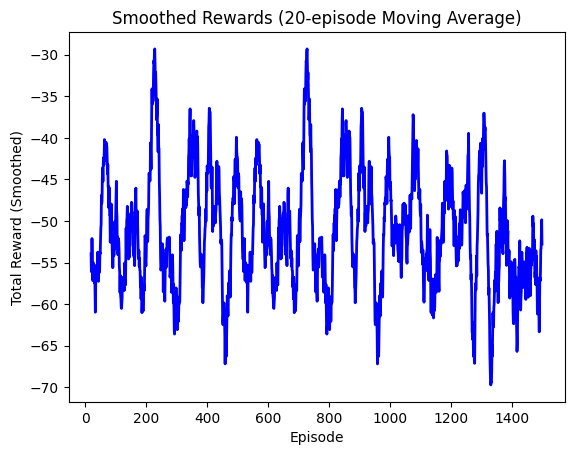

In [ ]:
import pandas as pd
plt.plot(pd.Series(rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_1000.pt")


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")
files.download("ppo_traffic_model_1000.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("PPO Training Progress for Traffic Signal Control (Extended)")
plt.show()

In [ ]:
!pip install stable_baselines3

# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("/content/ppo_traffic_model_1000.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 7.3 MB/s eta 0:00:00
Model loaded successfully!


In [ ]:
env = TrafficEnv(data)
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)


import torch
import json
import os
from tqdm import tqdm

def train_ppo(
    episodes=200,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    reward_history = []

    # Resume from saved rewards if file exists
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"✅ Loaded {len(reward_history)} previous rewards from '{rewards_path}'")

    # Continue training for new episodes
    for episode in tqdm(range(len(reward_history), len(reward_history) + episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # PPO update
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {episode + 1} | Total Reward: {total_reward:.2f}")

        # Save model & rewards every 10 episodes
        if (episode + 1) % 10 == 0:
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print(f"💾 Progress saved — {episode + 1} episodes complete")

    print("Training complete!")
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    return reward_history

In [ ]:
agent.load_state_dict(torch.load("/content/ppo_traffic_model_1000.pt"))


In [ ]:
''' rewards: rewards+ new_rewards+rewards_more'''

In [ ]:
print("Continuing training for 500 more episodes...")
new_rewards = train_ppo(episodes=500)
rewards.extend(new_rewards)
print("Training complete.")

Continuing training for 500 more episodes...
✅ Loaded 1000 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:04<37:55,  4.56s/it]

Episode 1001 | Total Reward: -92.76


  0%|          | 2/500 [00:07<27:35,  3.32s/it]

Episode 1002 | Total Reward: -51.96


  1%|          | 3/500 [00:07<15:54,  1.92s/it]

Episode 1003 | Total Reward: -7.19


  1%|          | 4/500 [00:08<14:26,  1.75s/it]

Episode 1004 | Total Reward: -35.89


  1%|          | 5/500 [00:11<16:44,  2.03s/it]

Episode 1005 | Total Reward: -54.21


  1%|          | 6/500 [00:15<24:01,  2.92s/it]

Episode 1006 | Total Reward: -97.80


  1%|▏         | 7/500 [00:16<16:44,  2.04s/it]

Episode 1007 | Total Reward: -5.44


  2%|▏         | 8/500 [00:19<20:50,  2.54s/it]

Episode 1008 | Total Reward: -89.66


  2%|▏         | 9/500 [00:22<21:51,  2.67s/it]

Episode 1009 | Total Reward: -72.40


  2%|▏         | 10/500 [00:24<19:53,  2.44s/it]

Episode 1010 | Total Reward: -43.10
💾 Progress saved — 1010 episodes complete


  2%|▏         | 11/500 [00:25<15:15,  1.87s/it]

Episode 1011 | Total Reward: -14.62


  2%|▏         | 12/500 [00:27<15:06,  1.86s/it]

Episode 1012 | Total Reward: -32.38


  3%|▎         | 13/500 [00:28<13:31,  1.67s/it]

Episode 1013 | Total Reward: -20.88


  3%|▎         | 14/500 [00:29<12:42,  1.57s/it]

Episode 1014 | Total Reward: -31.81


  3%|▎         | 15/500 [00:29<09:38,  1.19s/it]

Episode 1015 | Total Reward: -8.66


  3%|▎         | 16/500 [00:32<12:59,  1.61s/it]

Episode 1016 | Total Reward: -61.97


  3%|▎         | 17/500 [00:34<13:02,  1.62s/it]

Episode 1017 | Total Reward: -39.49


  4%|▎         | 18/500 [00:38<18:36,  2.32s/it]

Episode 1018 | Total Reward: -93.75


  4%|▍         | 19/500 [00:39<16:29,  2.06s/it]

Episode 1019 | Total Reward: -25.63


  4%|▍         | 20/500 [00:41<15:22,  1.92s/it]

Episode 1020 | Total Reward: -32.73
💾 Progress saved — 1020 episodes complete


  4%|▍         | 21/500 [00:41<11:44,  1.47s/it]

Episode 1021 | Total Reward: -11.12


  4%|▍         | 22/500 [00:44<15:35,  1.96s/it]

Episode 1022 | Total Reward: -76.52


  5%|▍         | 23/500 [00:46<15:06,  1.90s/it]

Episode 1023 | Total Reward: -43.04


  5%|▍         | 24/500 [00:47<14:11,  1.79s/it]

Episode 1024 | Total Reward: -37.12


  5%|▌         | 25/500 [00:53<22:09,  2.80s/it]

Episode 1025 | Total Reward: -87.25


  5%|▌         | 26/500 [00:54<18:15,  2.31s/it]

Episode 1026 | Total Reward: -26.00


  5%|▌         | 27/500 [00:55<16:30,  2.09s/it]

Episode 1027 | Total Reward: -38.66


  6%|▌         | 28/500 [00:58<18:49,  2.39s/it]

Episode 1028 | Total Reward: -75.83


  6%|▌         | 29/500 [01:00<17:49,  2.27s/it]

Episode 1029 | Total Reward: -47.67


  6%|▌         | 30/500 [01:04<20:31,  2.62s/it]

Episode 1030 | Total Reward: -71.31
💾 Progress saved — 1030 episodes complete


  6%|▌         | 31/500 [01:05<17:01,  2.18s/it]

Episode 1031 | Total Reward: -26.54


  6%|▋         | 32/500 [01:06<14:28,  1.86s/it]

Episode 1032 | Total Reward: -26.00


  7%|▋         | 33/500 [01:09<15:41,  2.02s/it]

Episode 1033 | Total Reward: -57.32


  7%|▋         | 34/500 [01:10<13:25,  1.73s/it]

Episode 1034 | Total Reward: -25.90


  7%|▋         | 35/500 [01:11<12:40,  1.64s/it]

Episode 1035 | Total Reward: -34.00


  7%|▋         | 36/500 [01:15<17:13,  2.23s/it]

Episode 1036 | Total Reward: -85.41


  7%|▋         | 37/500 [01:15<13:05,  1.70s/it]

Episode 1037 | Total Reward: -8.88


  8%|▊         | 38/500 [01:17<13:56,  1.81s/it]

Episode 1038 | Total Reward: -43.03


  8%|▊         | 39/500 [01:19<14:26,  1.88s/it]

Episode 1039 | Total Reward: -49.22


  8%|▊         | 40/500 [01:22<17:32,  2.29s/it]

Episode 1040 | Total Reward: -80.01
💾 Progress saved — 1040 episodes complete


  8%|▊         | 41/500 [01:26<20:17,  2.65s/it]

Episode 1041 | Total Reward: -84.24


  8%|▊         | 42/500 [01:27<15:29,  2.03s/it]

Episode 1042 | Total Reward: -11.57


  9%|▊         | 43/500 [01:27<12:06,  1.59s/it]

Episode 1043 | Total Reward: -11.01


  9%|▉         | 44/500 [01:29<12:21,  1.63s/it]

Episode 1044 | Total Reward: -34.61


  9%|▉         | 45/500 [01:30<11:49,  1.56s/it]

Episode 1045 | Total Reward: -34.61


  9%|▉         | 46/500 [01:31<09:01,  1.19s/it]

Episode 1046 | Total Reward: -9.20


  9%|▉         | 47/500 [01:33<12:51,  1.70s/it]

Episode 1047 | Total Reward: -71.02


 10%|▉         | 48/500 [01:37<16:53,  2.24s/it]

Episode 1048 | Total Reward: -84.50


 10%|▉         | 49/500 [01:38<14:24,  1.92s/it]

Episode 1049 | Total Reward: -28.21


 10%|█         | 50/500 [01:41<16:24,  2.19s/it]

Episode 1050 | Total Reward: -53.50
💾 Progress saved — 1050 episodes complete


 10%|█         | 51/500 [01:44<19:00,  2.54s/it]

Episode 1051 | Total Reward: -82.17


 10%|█         | 52/500 [01:47<20:04,  2.69s/it]

Episode 1052 | Total Reward: -73.05


 11%|█         | 53/500 [01:49<18:14,  2.45s/it]

Episode 1053 | Total Reward: -46.20


 11%|█         | 54/500 [01:52<18:47,  2.53s/it]

Episode 1054 | Total Reward: -52.56


 11%|█         | 55/500 [01:53<14:45,  1.99s/it]

Episode 1055 | Total Reward: -16.21


 11%|█         | 56/500 [01:57<19:14,  2.60s/it]

Episode 1056 | Total Reward: -99.70


 11%|█▏        | 57/500 [02:00<21:24,  2.90s/it]

Episode 1057 | Total Reward: -89.45


 12%|█▏        | 58/500 [02:04<24:08,  3.28s/it]

Episode 1058 | Total Reward: -87.61


 12%|█▏        | 59/500 [02:05<18:50,  2.56s/it]

Episode 1059 | Total Reward: -21.34


 12%|█▏        | 60/500 [02:06<15:23,  2.10s/it]

Episode 1060 | Total Reward: -24.91
💾 Progress saved — 1060 episodes complete


 12%|█▏        | 61/500 [02:07<12:31,  1.71s/it]

Episode 1061 | Total Reward: -19.79


 12%|█▏        | 62/500 [02:08<10:20,  1.42s/it]

Episode 1062 | Total Reward: -17.51


 13%|█▎        | 63/500 [02:09<08:39,  1.19s/it]

Episode 1063 | Total Reward: -16.55


 13%|█▎        | 64/500 [02:11<11:18,  1.56s/it]

Episode 1064 | Total Reward: -58.18


 13%|█▎        | 65/500 [02:13<12:28,  1.72s/it]

Episode 1065 | Total Reward: -50.44


 13%|█▎        | 66/500 [02:17<17:17,  2.39s/it]

Episode 1066 | Total Reward: -81.76


 13%|█▎        | 67/500 [02:20<18:24,  2.55s/it]

Episode 1067 | Total Reward: -71.24


 14%|█▎        | 68/500 [02:23<19:19,  2.68s/it]

Episode 1068 | Total Reward: -73.29


 14%|█▍        | 69/500 [02:26<19:41,  2.74s/it]

Episode 1069 | Total Reward: -70.36


 14%|█▍        | 70/500 [02:29<19:59,  2.79s/it]

Episode 1070 | Total Reward: -56.07
💾 Progress saved — 1070 episodes complete


 14%|█▍        | 71/500 [02:30<16:02,  2.24s/it]

Episode 1071 | Total Reward: -23.83


 14%|█▍        | 72/500 [02:31<14:34,  2.04s/it]

Episode 1072 | Total Reward: -38.90


 15%|█▍        | 73/500 [02:35<17:39,  2.48s/it]

Episode 1073 | Total Reward: -86.52


 15%|█▍        | 74/500 [02:35<13:33,  1.91s/it]

Episode 1074 | Total Reward: -14.46


 15%|█▌        | 75/500 [02:39<18:12,  2.57s/it]

Episode 1075 | Total Reward: -94.23


 15%|█▌        | 76/500 [02:42<17:43,  2.51s/it]

Episode 1076 | Total Reward: -50.12


 15%|█▌        | 77/500 [02:45<19:28,  2.76s/it]

Episode 1077 | Total Reward: -82.86


 16%|█▌        | 78/500 [02:48<20:32,  2.92s/it]

Episode 1078 | Total Reward: -78.96


 16%|█▌        | 79/500 [02:49<16:19,  2.33s/it]

Episode 1079 | Total Reward: -23.11


 16%|█▌        | 80/500 [02:50<12:31,  1.79s/it]

Episode 1080 | Total Reward: -13.63
💾 Progress saved — 1080 episodes complete


 16%|█▌        | 81/500 [02:54<16:59,  2.43s/it]

Episode 1081 | Total Reward: -80.79


 16%|█▋        | 82/500 [02:58<19:54,  2.86s/it]

Episode 1082 | Total Reward: -96.17


 17%|█▋        | 83/500 [03:00<19:39,  2.83s/it]

Episode 1083 | Total Reward: -68.59


 17%|█▋        | 84/500 [03:01<15:45,  2.27s/it]

Episode 1084 | Total Reward: -23.93


 17%|█▋        | 85/500 [03:06<20:17,  2.93s/it]

Episode 1085 | Total Reward: -96.99


 17%|█▋        | 86/500 [03:06<14:45,  2.14s/it]

Episode 1086 | Total Reward: -7.59


 17%|█▋        | 87/500 [03:08<14:43,  2.14s/it]

Episode 1087 | Total Reward: -51.63


 18%|█▊        | 88/500 [03:11<15:14,  2.22s/it]

Episode 1088 | Total Reward: -58.18


 18%|█▊        | 89/500 [03:13<14:52,  2.17s/it]

Episode 1089 | Total Reward: -49.96


 18%|█▊        | 90/500 [03:15<15:51,  2.32s/it]

Episode 1090 | Total Reward: -57.40
💾 Progress saved — 1090 episodes complete


 18%|█▊        | 91/500 [03:20<19:26,  2.85s/it]

Episode 1091 | Total Reward: -95.52


 18%|█▊        | 92/500 [03:24<22:03,  3.24s/it]

Episode 1092 | Total Reward: -101.57


 19%|█▊        | 93/500 [03:25<17:37,  2.60s/it]

Episode 1093 | Total Reward: -26.79


 19%|█▉        | 94/500 [03:27<17:34,  2.60s/it]

Episode 1094 | Total Reward: -54.07


 19%|█▉        | 95/500 [03:29<15:34,  2.31s/it]

Episode 1095 | Total Reward: -33.46


 19%|█▉        | 96/500 [03:32<15:59,  2.37s/it]

Episode 1096 | Total Reward: -62.08


 19%|█▉        | 97/500 [03:33<14:06,  2.10s/it]

Episode 1097 | Total Reward: -35.10


 20%|█▉        | 98/500 [03:36<15:29,  2.31s/it]

Episode 1098 | Total Reward: -68.68


 20%|█▉        | 99/500 [03:36<12:03,  1.80s/it]

Episode 1099 | Total Reward: -14.53


 20%|██        | 100/500 [03:40<16:27,  2.47s/it]

Episode 1100 | Total Reward: -84.46
💾 Progress saved — 1100 episodes complete


 20%|██        | 101/500 [03:42<13:48,  2.08s/it]

Episode 1101 | Total Reward: -28.37


 20%|██        | 102/500 [03:46<17:42,  2.67s/it]

Episode 1102 | Total Reward: -100.77


 21%|██        | 103/500 [03:46<13:03,  1.97s/it]

Episode 1103 | Total Reward: -9.65


 21%|██        | 104/500 [03:47<10:17,  1.56s/it]

Episode 1104 | Total Reward: -14.47


 21%|██        | 105/500 [03:50<14:39,  2.23s/it]

Episode 1105 | Total Reward: -91.37


 21%|██        | 106/500 [03:52<12:30,  1.90s/it]

Episode 1106 | Total Reward: -20.99


 21%|██▏       | 107/500 [03:53<12:19,  1.88s/it]

Episode 1107 | Total Reward: -39.39


 22%|██▏       | 108/500 [03:57<15:16,  2.34s/it]

Episode 1108 | Total Reward: -83.60


 22%|██▏       | 109/500 [03:57<11:17,  1.73s/it]

Episode 1109 | Total Reward: -8.88


 22%|██▏       | 110/500 [03:58<09:41,  1.49s/it]

Episode 1110 | Total Reward: -22.43
💾 Progress saved — 1110 episodes complete


 22%|██▏       | 111/500 [04:00<10:14,  1.58s/it]

Episode 1111 | Total Reward: -43.79


 22%|██▏       | 112/500 [04:04<14:26,  2.23s/it]

Episode 1112 | Total Reward: -83.63


 23%|██▎       | 113/500 [04:08<18:15,  2.83s/it]

Episode 1113 | Total Reward: -95.10


 23%|██▎       | 114/500 [04:08<13:57,  2.17s/it]

Episode 1114 | Total Reward: -15.68


 23%|██▎       | 115/500 [04:12<16:36,  2.59s/it]

Episode 1115 | Total Reward: -87.25


 23%|██▎       | 116/500 [04:15<17:54,  2.80s/it]

Episode 1116 | Total Reward: -73.32


 23%|██▎       | 117/500 [04:19<19:47,  3.10s/it]

Episode 1117 | Total Reward: -87.99


 24%|██▎       | 118/500 [04:23<21:30,  3.38s/it]

Episode 1118 | Total Reward: -98.95


 24%|██▍       | 119/500 [04:25<19:27,  3.07s/it]

Episode 1119 | Total Reward: -54.73


 24%|██▍       | 120/500 [04:29<21:08,  3.34s/it]

Episode 1120 | Total Reward: -81.17
💾 Progress saved — 1120 episodes complete


 24%|██▍       | 121/500 [04:32<20:08,  3.19s/it]

Episode 1121 | Total Reward: -69.37


 24%|██▍       | 122/500 [04:33<15:13,  2.42s/it]

Episode 1122 | Total Reward: -15.82


 25%|██▍       | 123/500 [04:35<14:13,  2.26s/it]

Episode 1123 | Total Reward: -45.86


 25%|██▍       | 124/500 [04:37<13:54,  2.22s/it]

Episode 1124 | Total Reward: -47.49


 25%|██▌       | 125/500 [04:40<14:47,  2.37s/it]

Episode 1125 | Total Reward: -55.24


 25%|██▌       | 126/500 [04:42<14:54,  2.39s/it]

Episode 1126 | Total Reward: -52.67


 25%|██▌       | 127/500 [04:45<14:58,  2.41s/it]

Episode 1127 | Total Reward: -59.79


 26%|██▌       | 128/500 [04:48<17:05,  2.76s/it]

Episode 1128 | Total Reward: -88.38


 26%|██▌       | 129/500 [04:50<16:13,  2.62s/it]

Episode 1129 | Total Reward: -52.24


 26%|██▌       | 130/500 [04:53<16:16,  2.64s/it]

Episode 1130 | Total Reward: -52.07
💾 Progress saved — 1130 episodes complete


 26%|██▌       | 131/500 [04:57<18:22,  2.99s/it]

Episode 1131 | Total Reward: -94.34


 26%|██▋       | 132/500 [04:58<14:22,  2.34s/it]

Episode 1132 | Total Reward: -20.33


 27%|██▋       | 133/500 [05:00<14:35,  2.39s/it]

Episode 1133 | Total Reward: -58.62


 27%|██▋       | 134/500 [05:04<16:17,  2.67s/it]

Episode 1134 | Total Reward: -72.40


 27%|██▋       | 135/500 [05:06<15:48,  2.60s/it]

Episode 1135 | Total Reward: -54.07


 27%|██▋       | 136/500 [05:07<12:35,  2.08s/it]

Episode 1136 | Total Reward: -19.86


 27%|██▋       | 137/500 [05:08<11:31,  1.91s/it]

Episode 1137 | Total Reward: -37.44


 28%|██▊       | 138/500 [05:12<15:26,  2.56s/it]

Episode 1138 | Total Reward: -100.53


 28%|██▊       | 139/500 [05:13<12:01,  2.00s/it]

Episode 1139 | Total Reward: -17.08


 28%|██▊       | 140/500 [05:17<15:38,  2.61s/it]

Episode 1140 | Total Reward: -85.86
💾 Progress saved — 1140 episodes complete


 28%|██▊       | 141/500 [05:19<13:40,  2.28s/it]

Episode 1141 | Total Reward: -37.88


 28%|██▊       | 142/500 [05:21<13:01,  2.18s/it]

Episode 1142 | Total Reward: -46.45


 29%|██▊       | 143/500 [05:24<14:33,  2.45s/it]

Episode 1143 | Total Reward: -74.06


 29%|██▉       | 144/500 [05:27<15:46,  2.66s/it]

Episode 1144 | Total Reward: -70.90


 29%|██▉       | 145/500 [05:29<14:50,  2.51s/it]

Episode 1145 | Total Reward: -41.41


 29%|██▉       | 146/500 [05:29<10:59,  1.86s/it]

Episode 1146 | Total Reward: -9.37


 29%|██▉       | 147/500 [05:31<09:53,  1.68s/it]

Episode 1147 | Total Reward: -29.86


 30%|██▉       | 148/500 [05:34<13:34,  2.31s/it]

Episode 1148 | Total Reward: -90.68


 30%|██▉       | 149/500 [05:36<12:54,  2.21s/it]

Episode 1149 | Total Reward: -46.04


 30%|███       | 150/500 [05:37<10:05,  1.73s/it]

Episode 1150 | Total Reward: -13.95
💾 Progress saved — 1150 episodes complete


 30%|███       | 151/500 [05:41<13:28,  2.32s/it]

Episode 1151 | Total Reward: -71.08


 30%|███       | 152/500 [05:42<10:53,  1.88s/it]

Episode 1152 | Total Reward: -20.63


 31%|███       | 153/500 [05:44<12:00,  2.08s/it]

Episode 1153 | Total Reward: -59.60


 31%|███       | 154/500 [05:47<12:58,  2.25s/it]

Episode 1154 | Total Reward: -64.40


 31%|███       | 155/500 [05:49<13:43,  2.39s/it]

Episode 1155 | Total Reward: -64.29


 31%|███       | 156/500 [05:52<14:39,  2.56s/it]

Episode 1156 | Total Reward: -56.32


 31%|███▏      | 157/500 [05:54<12:44,  2.23s/it]

Episode 1157 | Total Reward: -35.30


 32%|███▏      | 158/500 [05:55<11:00,  1.93s/it]

Episode 1158 | Total Reward: -28.67


 32%|███▏      | 159/500 [05:58<12:36,  2.22s/it]

Episode 1159 | Total Reward: -68.78


 32%|███▏      | 160/500 [06:01<14:10,  2.50s/it]

Episode 1160 | Total Reward: -76.68
💾 Progress saved — 1160 episodes complete


 32%|███▏      | 161/500 [06:04<14:28,  2.56s/it]

Episode 1161 | Total Reward: -53.04


 32%|███▏      | 162/500 [06:06<13:23,  2.38s/it]

Episode 1162 | Total Reward: -40.39


 33%|███▎      | 163/500 [06:10<15:57,  2.84s/it]

Episode 1163 | Total Reward: -94.23


 33%|███▎      | 164/500 [06:10<12:02,  2.15s/it]

Episode 1164 | Total Reward: -13.52


 33%|███▎      | 165/500 [06:14<14:55,  2.67s/it]

Episode 1165 | Total Reward: -95.10


 33%|███▎      | 166/500 [06:16<13:55,  2.50s/it]

Episode 1166 | Total Reward: -38.72


 33%|███▎      | 167/500 [06:20<16:19,  2.94s/it]

Episode 1167 | Total Reward: -93.99


 34%|███▎      | 168/500 [06:21<12:14,  2.21s/it]

Episode 1168 | Total Reward: -12.86


 34%|███▍      | 169/500 [06:25<15:30,  2.81s/it]

Episode 1169 | Total Reward: -101.66


 34%|███▍      | 170/500 [06:29<17:14,  3.13s/it]

Episode 1170 | Total Reward: -80.79
💾 Progress saved — 1170 episodes complete


 34%|███▍      | 171/500 [06:32<16:36,  3.03s/it]

Episode 1171 | Total Reward: -68.78


 34%|███▍      | 172/500 [06:35<16:25,  3.01s/it]

Episode 1172 | Total Reward: -72.92


 35%|███▍      | 173/500 [06:37<15:40,  2.88s/it]

Episode 1173 | Total Reward: -61.54


 35%|███▍      | 174/500 [06:38<12:33,  2.31s/it]

Episode 1174 | Total Reward: -24.60


 35%|███▌      | 175/500 [06:39<10:13,  1.89s/it]

Episode 1175 | Total Reward: -16.91


 35%|███▌      | 176/500 [06:39<07:55,  1.47s/it]

Episode 1176 | Total Reward: -9.65


 35%|███▌      | 177/500 [06:40<06:53,  1.28s/it]

Episode 1177 | Total Reward: -14.83


 36%|███▌      | 178/500 [06:41<05:43,  1.07s/it]

Episode 1178 | Total Reward: -13.55


 36%|███▌      | 179/500 [06:43<06:34,  1.23s/it]

Episode 1179 | Total Reward: -39.29


 36%|███▌      | 180/500 [06:46<09:38,  1.81s/it]

Episode 1180 | Total Reward: -76.78
💾 Progress saved — 1180 episodes complete


 36%|███▌      | 181/500 [06:48<10:18,  1.94s/it]

Episode 1181 | Total Reward: -53.72


 36%|███▋      | 182/500 [06:50<10:32,  1.99s/it]

Episode 1182 | Total Reward: -49.96


 37%|███▋      | 183/500 [06:51<08:14,  1.56s/it]

Episode 1183 | Total Reward: -12.74


 37%|███▋      | 184/500 [06:52<07:27,  1.42s/it]

Episode 1184 | Total Reward: -19.70


 37%|███▋      | 185/500 [06:56<11:47,  2.25s/it]

Episode 1185 | Total Reward: -97.74


 37%|███▋      | 186/500 [06:59<12:24,  2.37s/it]

Episode 1186 | Total Reward: -64.29


 37%|███▋      | 187/500 [07:02<13:21,  2.56s/it]

Episode 1187 | Total Reward: -72.92


 38%|███▊      | 188/500 [07:05<14:42,  2.83s/it]

Episode 1188 | Total Reward: -69.80


 38%|███▊      | 189/500 [07:06<11:16,  2.18s/it]

Episode 1189 | Total Reward: -16.51


 38%|███▊      | 190/500 [07:08<11:28,  2.22s/it]

Episode 1190 | Total Reward: -54.98
💾 Progress saved — 1190 episodes complete


 38%|███▊      | 191/500 [07:11<13:17,  2.58s/it]

Episode 1191 | Total Reward: -83.60


 38%|███▊      | 192/500 [07:12<09:36,  1.87s/it]

Episode 1192 | Total Reward: -5.74


 39%|███▊      | 193/500 [07:12<07:24,  1.45s/it]

Episode 1193 | Total Reward: -11.51


 39%|███▉      | 194/500 [07:13<06:54,  1.35s/it]

Episode 1194 | Total Reward: -27.13


 39%|███▉      | 195/500 [07:14<05:51,  1.15s/it]

Episode 1195 | Total Reward: -16.91


 39%|███▉      | 196/500 [07:17<09:05,  1.79s/it]

Episode 1196 | Total Reward: -66.67


 39%|███▉      | 197/500 [07:17<06:38,  1.32s/it]

Episode 1197 | Total Reward: -5.19


 40%|███▉      | 198/500 [07:20<09:10,  1.82s/it]

Episode 1198 | Total Reward: -72.35


 40%|███▉      | 199/500 [07:24<12:19,  2.46s/it]

Episode 1199 | Total Reward: -96.99


 40%|████      | 200/500 [07:25<09:01,  1.80s/it]

Episode 1200 | Total Reward: -7.19
💾 Progress saved — 1200 episodes complete


 40%|████      | 201/500 [07:26<07:45,  1.56s/it]

Episode 1201 | Total Reward: -23.71


 40%|████      | 202/500 [07:26<05:50,  1.18s/it]

Episode 1202 | Total Reward: -7.90


 41%|████      | 203/500 [07:26<04:30,  1.10it/s]

Episode 1203 | Total Reward: -8.01


 41%|████      | 204/500 [07:26<03:31,  1.40it/s]

Episode 1204 | Total Reward: -7.26


 41%|████      | 205/500 [07:30<07:03,  1.44s/it]

Episode 1205 | Total Reward: -62.36


 41%|████      | 206/500 [07:32<07:54,  1.62s/it]

Episode 1206 | Total Reward: -48.98


 41%|████▏     | 207/500 [07:34<09:00,  1.84s/it]

Episode 1207 | Total Reward: -57.36


 42%|████▏     | 208/500 [07:35<07:42,  1.58s/it]

Episode 1208 | Total Reward: -23.93


 42%|████▏     | 209/500 [07:37<08:50,  1.82s/it]

Episode 1209 | Total Reward: -56.81


 42%|████▏     | 210/500 [07:41<11:04,  2.29s/it]

Episode 1210 | Total Reward: -68.68
💾 Progress saved — 1210 episodes complete


 42%|████▏     | 211/500 [07:42<10:13,  2.12s/it]

Episode 1211 | Total Reward: -41.93


 42%|████▏     | 212/500 [07:43<08:24,  1.75s/it]

Episode 1212 | Total Reward: -20.88


 43%|████▎     | 213/500 [07:46<09:24,  1.97s/it]

Episode 1213 | Total Reward: -60.85


 43%|████▎     | 214/500 [07:49<11:53,  2.49s/it]

Episode 1214 | Total Reward: -90.17


 43%|████▎     | 215/500 [07:54<14:27,  3.04s/it]

Episode 1215 | Total Reward: -92.66


 43%|████▎     | 216/500 [07:56<12:33,  2.65s/it]

Episode 1216 | Total Reward: -42.52


 43%|████▎     | 217/500 [07:58<11:51,  2.51s/it]

Episode 1217 | Total Reward: -52.15


 44%|████▎     | 218/500 [08:00<11:44,  2.50s/it]

Episode 1218 | Total Reward: -59.65


 44%|████▍     | 219/500 [08:03<12:40,  2.71s/it]

Episode 1219 | Total Reward: -69.97


 44%|████▍     | 220/500 [08:06<12:38,  2.71s/it]

Episode 1220 | Total Reward: -58.74
💾 Progress saved — 1220 episodes complete


 44%|████▍     | 221/500 [08:08<11:26,  2.46s/it]

Episode 1221 | Total Reward: -45.17


 44%|████▍     | 222/500 [08:10<10:29,  2.26s/it]

Episode 1222 | Total Reward: -42.09


 45%|████▍     | 223/500 [08:13<11:55,  2.58s/it]

Episode 1223 | Total Reward: -80.66


 45%|████▍     | 224/500 [08:18<14:27,  3.14s/it]

Episode 1224 | Total Reward: -94.87


 45%|████▌     | 225/500 [08:18<11:02,  2.41s/it]

Episode 1225 | Total Reward: -17.17


 45%|████▌     | 226/500 [08:19<08:04,  1.77s/it]

Episode 1226 | Total Reward: -7.40


 45%|████▌     | 227/500 [08:20<07:49,  1.72s/it]

Episode 1227 | Total Reward: -38.42


 46%|████▌     | 228/500 [08:24<10:41,  2.36s/it]

Episode 1228 | Total Reward: -92.76


 46%|████▌     | 229/500 [08:28<13:06,  2.90s/it]

Episode 1229 | Total Reward: -89.45


 46%|████▌     | 230/500 [08:28<09:35,  2.13s/it]

Episode 1230 | Total Reward: -7.90
💾 Progress saved — 1230 episodes complete


 46%|████▌     | 231/500 [08:31<10:05,  2.25s/it]

Episode 1231 | Total Reward: -59.60


 46%|████▋     | 232/500 [08:33<09:38,  2.16s/it]

Episode 1232 | Total Reward: -46.93


 47%|████▋     | 233/500 [08:36<10:18,  2.32s/it]

Episode 1233 | Total Reward: -65.11


 47%|████▋     | 234/500 [08:37<08:34,  1.94s/it]

Episode 1234 | Total Reward: -25.47


 47%|████▋     | 235/500 [08:37<06:41,  1.51s/it]

Episode 1235 | Total Reward: -12.57


 47%|████▋     | 236/500 [08:41<09:10,  2.09s/it]

Episode 1236 | Total Reward: -70.06


 47%|████▋     | 237/500 [08:43<09:13,  2.10s/it]

Episode 1237 | Total Reward: -50.58


 48%|████▊     | 238/500 [08:45<09:49,  2.25s/it]

Episode 1238 | Total Reward: -62.28


 48%|████▊     | 239/500 [08:49<11:09,  2.56s/it]

Episode 1239 | Total Reward: -80.55


 48%|████▊     | 240/500 [08:50<09:30,  2.19s/it]

Episode 1240 | Total Reward: -31.38
💾 Progress saved — 1240 episodes complete


 48%|████▊     | 241/500 [08:52<08:45,  2.03s/it]

Episode 1241 | Total Reward: -30.63


 48%|████▊     | 242/500 [08:53<08:28,  1.97s/it]

Episode 1242 | Total Reward: -38.99


 49%|████▊     | 243/500 [08:55<08:00,  1.87s/it]

Episode 1243 | Total Reward: -39.25


 49%|████▉     | 244/500 [08:59<10:06,  2.37s/it]

Episode 1244 | Total Reward: -87.19


 49%|████▉     | 245/500 [08:59<07:31,  1.77s/it]

Episode 1245 | Total Reward: -9.46


 49%|████▉     | 246/500 [09:03<10:05,  2.38s/it]

Episode 1246 | Total Reward: -89.66


 49%|████▉     | 247/500 [09:03<07:30,  1.78s/it]

Episode 1247 | Total Reward: -7.45


 50%|████▉     | 248/500 [09:06<08:15,  1.97s/it]

Episode 1248 | Total Reward: -50.29


 50%|████▉     | 249/500 [09:06<06:16,  1.50s/it]

Episode 1249 | Total Reward: -10.41


 50%|█████     | 250/500 [09:10<09:16,  2.23s/it]

Episode 1250 | Total Reward: -93.51
💾 Progress saved — 1250 episodes complete


 50%|█████     | 251/500 [09:11<07:29,  1.80s/it]

Episode 1251 | Total Reward: -19.41


 50%|█████     | 252/500 [09:15<09:56,  2.40s/it]

Episode 1252 | Total Reward: -91.27


 51%|█████     | 253/500 [09:16<08:04,  1.96s/it]

Episode 1253 | Total Reward: -17.04


 51%|█████     | 254/500 [09:16<05:54,  1.44s/it]

Episode 1254 | Total Reward: -4.21


 51%|█████     | 255/500 [09:17<05:27,  1.34s/it]

Episode 1255 | Total Reward: -21.41


 51%|█████     | 256/500 [09:18<05:31,  1.36s/it]

Episode 1256 | Total Reward: -33.68


 51%|█████▏    | 257/500 [09:20<05:57,  1.47s/it]

Episode 1257 | Total Reward: -41.55


 52%|█████▏    | 258/500 [09:24<08:49,  2.19s/it]

Episode 1258 | Total Reward: -91.65


 52%|█████▏    | 259/500 [09:25<07:40,  1.91s/it]

Episode 1259 | Total Reward: -29.57


 52%|█████▏    | 260/500 [09:29<09:35,  2.40s/it]

Episode 1260 | Total Reward: -72.01
💾 Progress saved — 1260 episodes complete


 52%|█████▏    | 261/500 [09:30<08:35,  2.16s/it]

Episode 1261 | Total Reward: -36.59


 52%|█████▏    | 262/500 [09:31<06:47,  1.71s/it]

Episode 1262 | Total Reward: -15.54


 53%|█████▎    | 263/500 [09:32<06:32,  1.65s/it]

Episode 1263 | Total Reward: -36.50


 53%|█████▎    | 264/500 [09:34<06:32,  1.66s/it]

Episode 1264 | Total Reward: -40.43


 53%|█████▎    | 265/500 [09:36<06:49,  1.74s/it]

Episode 1265 | Total Reward: -45.68


 53%|█████▎    | 266/500 [09:39<08:07,  2.08s/it]

Episode 1266 | Total Reward: -62.57


 53%|█████▎    | 267/500 [09:41<08:33,  2.20s/it]

Episode 1267 | Total Reward: -48.91


 54%|█████▎    | 268/500 [09:42<06:57,  1.80s/it]

Episode 1268 | Total Reward: -20.08


 54%|█████▍    | 269/500 [09:46<09:22,  2.44s/it]

Episode 1269 | Total Reward: -93.99


 54%|█████▍    | 270/500 [09:48<09:06,  2.38s/it]

Episode 1270 | Total Reward: -51.96
💾 Progress saved — 1270 episodes complete


 54%|█████▍    | 271/500 [09:53<11:30,  3.01s/it]

Episode 1271 | Total Reward: -92.39


 54%|█████▍    | 272/500 [09:57<12:40,  3.33s/it]

Episode 1272 | Total Reward: -100.58


 55%|█████▍    | 273/500 [09:58<10:26,  2.76s/it]

Episode 1273 | Total Reward: -34.06


 55%|█████▍    | 274/500 [09:59<07:47,  2.07s/it]

Episode 1274 | Total Reward: -11.51


 55%|█████▌    | 275/500 [10:03<09:54,  2.64s/it]

Episode 1275 | Total Reward: -95.85


 55%|█████▌    | 276/500 [10:05<09:36,  2.57s/it]

Episode 1276 | Total Reward: -46.32


 55%|█████▌    | 277/500 [10:06<07:37,  2.05s/it]

Episode 1277 | Total Reward: -19.92


 56%|█████▌    | 278/500 [10:10<09:52,  2.67s/it]

Episode 1278 | Total Reward: -100.77


 56%|█████▌    | 279/500 [10:12<09:22,  2.55s/it]

Episode 1279 | Total Reward: -53.20


 56%|█████▌    | 280/500 [10:15<09:40,  2.64s/it]

Episode 1280 | Total Reward: -63.69
💾 Progress saved — 1280 episodes complete


 56%|█████▌    | 281/500 [10:18<09:52,  2.71s/it]

Episode 1281 | Total Reward: -62.24


 56%|█████▋    | 282/500 [10:21<10:24,  2.87s/it]

Episode 1282 | Total Reward: -78.15


 57%|█████▋    | 283/500 [10:24<09:32,  2.64s/it]

Episode 1283 | Total Reward: -49.45


 57%|█████▋    | 284/500 [10:24<06:58,  1.94s/it]

Episode 1284 | Total Reward: -8.35


 57%|█████▋    | 285/500 [10:26<06:56,  1.94s/it]

Episode 1285 | Total Reward: -45.34


 57%|█████▋    | 286/500 [10:29<08:08,  2.28s/it]

Episode 1286 | Total Reward: -61.54


 57%|█████▋    | 287/500 [10:31<08:05,  2.28s/it]

Episode 1287 | Total Reward: -53.98


 58%|█████▊    | 288/500 [10:34<09:03,  2.56s/it]

Episode 1288 | Total Reward: -79.46


 58%|█████▊    | 289/500 [10:37<09:28,  2.69s/it]

Episode 1289 | Total Reward: -71.77


 58%|█████▊    | 290/500 [10:42<11:19,  3.24s/it]

Episode 1290 | Total Reward: -97.74
💾 Progress saved — 1290 episodes complete


 58%|█████▊    | 291/500 [10:45<10:42,  3.07s/it]

Episode 1291 | Total Reward: -66.17


 58%|█████▊    | 292/500 [10:45<08:26,  2.44s/it]

Episode 1292 | Total Reward: -23.25


 59%|█████▊    | 293/500 [10:49<10:01,  2.91s/it]

Episode 1293 | Total Reward: -98.77


 59%|█████▉    | 294/500 [10:52<09:28,  2.76s/it]

Episode 1294 | Total Reward: -47.10


 59%|█████▉    | 295/500 [10:54<08:56,  2.61s/it]

Episode 1295 | Total Reward: -51.10


 59%|█████▉    | 296/500 [10:55<07:04,  2.08s/it]

Episode 1296 | Total Reward: -20.17


 59%|█████▉    | 297/500 [10:57<07:13,  2.14s/it]

Episode 1297 | Total Reward: -54.13


 60%|█████▉    | 298/500 [10:59<06:22,  1.89s/it]

Episode 1298 | Total Reward: -30.52


 60%|█████▉    | 299/500 [10:59<04:46,  1.43s/it]

Episode 1299 | Total Reward: -8.73


 60%|██████    | 301/500 [11:01<04:00,  1.21s/it]

Episode 1300 | Total Reward: -51.35
💾 Progress saved — 1300 episodes complete
Episode 1301 | Total Reward: -4.75


 60%|██████    | 302/500 [11:05<06:14,  1.89s/it]

Episode 1302 | Total Reward: -70.94


 61%|██████    | 303/500 [11:08<07:48,  2.38s/it]

Episode 1303 | Total Reward: -86.21


 61%|██████    | 304/500 [11:12<08:36,  2.64s/it]

Episode 1304 | Total Reward: -77.72


 61%|██████    | 305/500 [11:12<06:20,  1.95s/it]

Episode 1305 | Total Reward: -8.88


 61%|██████    | 306/500 [11:15<07:50,  2.43s/it]

Episode 1306 | Total Reward: -78.65


 61%|██████▏   | 307/500 [11:19<08:37,  2.68s/it]

Episode 1307 | Total Reward: -74.35


 62%|██████▏   | 308/500 [11:19<06:20,  1.98s/it]

Episode 1308 | Total Reward: -9.24


 62%|██████▏   | 309/500 [11:21<06:08,  1.93s/it]

Episode 1309 | Total Reward: -42.41


 62%|██████▏   | 310/500 [11:25<08:01,  2.53s/it]

Episode 1310 | Total Reward: -94.23
💾 Progress saved — 1310 episodes complete


 62%|██████▏   | 311/500 [11:25<06:08,  1.95s/it]

Episode 1311 | Total Reward: -14.62


 62%|██████▏   | 312/500 [11:28<06:55,  2.21s/it]

Episode 1312 | Total Reward: -54.98


 63%|██████▎   | 313/500 [11:30<06:34,  2.11s/it]

Episode 1313 | Total Reward: -45.08


 63%|██████▎   | 315/500 [11:32<04:35,  1.49s/it]

Episode 1314 | Total Reward: -45.86
Episode 1315 | Total Reward: -5.19


 63%|██████▎   | 316/500 [11:34<04:46,  1.56s/it]

Episode 1316 | Total Reward: -40.61


 63%|██████▎   | 317/500 [11:34<03:34,  1.17s/it]

Episode 1317 | Total Reward: -6.92


 64%|██████▎   | 318/500 [11:37<04:59,  1.64s/it]

Episode 1318 | Total Reward: -66.67


 64%|██████▍   | 319/500 [11:40<06:31,  2.16s/it]

Episode 1319 | Total Reward: -68.17


 64%|██████▍   | 320/500 [11:43<07:12,  2.40s/it]

Episode 1320 | Total Reward: -71.66
💾 Progress saved — 1320 episodes complete


 64%|██████▍   | 321/500 [11:44<06:00,  2.01s/it]

Episode 1321 | Total Reward: -27.05


 64%|██████▍   | 322/500 [11:47<06:47,  2.29s/it]

Episode 1322 | Total Reward: -71.66


 65%|██████▍   | 323/500 [11:47<04:55,  1.67s/it]

Episode 1323 | Total Reward: -5.77


 65%|██████▍   | 324/500 [11:48<03:51,  1.31s/it]

Episode 1324 | Total Reward: -12.00


 65%|██████▌   | 325/500 [11:53<06:45,  2.32s/it]

Episode 1325 | Total Reward: -99.63


 65%|██████▌   | 326/500 [11:53<05:23,  1.86s/it]

Episode 1326 | Total Reward: -18.81


 65%|██████▌   | 327/500 [11:55<05:30,  1.91s/it]

Episode 1327 | Total Reward: -48.30


 66%|██████▌   | 328/500 [11:58<05:41,  1.98s/it]

Episode 1328 | Total Reward: -49.88


 66%|██████▌   | 329/500 [12:01<07:05,  2.49s/it]

Episode 1329 | Total Reward: -89.84


 66%|██████▌   | 330/500 [12:01<05:07,  1.81s/it]

Episode 1330 | Total Reward: -5.87
💾 Progress saved — 1330 episodes complete


 66%|██████▌   | 331/500 [12:02<04:23,  1.56s/it]

Episode 1331 | Total Reward: -21.41


 66%|██████▋   | 332/500 [12:03<03:48,  1.36s/it]

Episode 1332 | Total Reward: -16.91


 67%|██████▋   | 333/500 [12:07<05:46,  2.07s/it]

Episode 1333 | Total Reward: -84.20


 67%|██████▋   | 334/500 [12:10<06:02,  2.18s/it]

Episode 1334 | Total Reward: -58.06


 67%|██████▋   | 335/500 [12:12<06:12,  2.25s/it]

Episode 1335 | Total Reward: -58.46


 67%|██████▋   | 336/500 [12:12<04:35,  1.68s/it]

Episode 1336 | Total Reward: -7.67


 67%|██████▋   | 337/500 [12:17<06:45,  2.49s/it]

Episode 1337 | Total Reward: -94.77


 68%|██████▊   | 338/500 [12:20<07:07,  2.64s/it]

Episode 1338 | Total Reward: -71.66


 68%|██████▊   | 339/500 [12:20<05:33,  2.07s/it]

Episode 1339 | Total Reward: -18.66


 68%|██████▊   | 340/500 [12:24<06:49,  2.56s/it]

Episode 1340 | Total Reward: -89.36
💾 Progress saved — 1340 episodes complete


 68%|██████▊   | 341/500 [12:28<07:48,  2.95s/it]

Episode 1341 | Total Reward: -82.17


 68%|██████▊   | 342/500 [12:31<08:06,  3.08s/it]

Episode 1342 | Total Reward: -80.23


 69%|██████▊   | 343/500 [12:32<06:31,  2.49s/it]

Episode 1343 | Total Reward: -27.13


 69%|██████▉   | 344/500 [12:36<07:27,  2.87s/it]

Episode 1344 | Total Reward: -91.54


 69%|██████▉   | 345/500 [12:40<08:17,  3.21s/it]

Episode 1345 | Total Reward: -84.50


 69%|██████▉   | 346/500 [12:43<07:44,  3.02s/it]

Episode 1346 | Total Reward: -62.02


 69%|██████▉   | 347/500 [12:45<07:10,  2.81s/it]

Episode 1347 | Total Reward: -55.57


 70%|██████▉   | 348/500 [12:48<07:17,  2.88s/it]

Episode 1348 | Total Reward: -73.10


 70%|██████▉   | 349/500 [12:51<07:27,  2.96s/it]

Episode 1349 | Total Reward: -69.37


 70%|███████   | 350/500 [12:54<07:02,  2.81s/it]

Episode 1350 | Total Reward: -52.07
💾 Progress saved — 1350 episodes complete


 70%|███████   | 351/500 [12:58<07:50,  3.16s/it]

Episode 1351 | Total Reward: -97.42


 70%|███████   | 352/500 [12:58<05:58,  2.42s/it]

Episode 1352 | Total Reward: -17.19


 71%|███████   | 353/500 [13:02<06:45,  2.76s/it]

Episode 1353 | Total Reward: -87.05


 71%|███████   | 354/500 [13:06<07:17,  3.00s/it]

Episode 1354 | Total Reward: -73.32


 71%|███████   | 355/500 [13:07<05:49,  2.41s/it]

Episode 1355 | Total Reward: -25.83


 71%|███████   | 356/500 [13:07<04:31,  1.89s/it]

Episode 1356 | Total Reward: -15.89


 71%|███████▏  | 357/500 [13:10<05:21,  2.25s/it]

Episode 1357 | Total Reward: -74.35


 72%|███████▏  | 358/500 [13:13<05:34,  2.35s/it]

Episode 1358 | Total Reward: -63.21


 72%|███████▏  | 359/500 [13:17<06:37,  2.82s/it]

Episode 1359 | Total Reward: -80.92


 72%|███████▏  | 360/500 [13:18<05:13,  2.24s/it]

Episode 1360 | Total Reward: -20.99
💾 Progress saved — 1360 episodes complete


 72%|███████▏  | 361/500 [13:19<04:25,  1.91s/it]

Episode 1361 | Total Reward: -27.52


 72%|███████▏  | 362/500 [13:21<04:23,  1.91s/it]

Episode 1362 | Total Reward: -45.98


 73%|███████▎  | 363/500 [13:24<05:01,  2.20s/it]

Episode 1363 | Total Reward: -69.75


 73%|███████▎  | 364/500 [13:28<06:34,  2.90s/it]

Episode 1364 | Total Reward: -97.39


 73%|███████▎  | 365/500 [13:30<05:46,  2.57s/it]

Episode 1365 | Total Reward: -43.22


 73%|███████▎  | 366/500 [13:32<05:32,  2.48s/it]

Episode 1366 | Total Reward: -53.32


 73%|███████▎  | 367/500 [13:36<06:07,  2.77s/it]

Episode 1367 | Total Reward: -82.86


 74%|███████▎  | 368/500 [13:38<05:47,  2.63s/it]

Episode 1368 | Total Reward: -55.24


 74%|███████▍  | 369/500 [13:39<04:33,  2.09s/it]

Episode 1369 | Total Reward: -14.20


 74%|███████▍  | 370/500 [13:43<05:40,  2.62s/it]

Episode 1370 | Total Reward: -85.95
💾 Progress saved — 1370 episodes complete


 74%|███████▍  | 371/500 [13:44<04:57,  2.31s/it]

Episode 1371 | Total Reward: -38.10


 74%|███████▍  | 372/500 [13:47<04:53,  2.30s/it]

Episode 1372 | Total Reward: -52.18


 75%|███████▍  | 373/500 [13:48<04:22,  2.06s/it]

Episode 1373 | Total Reward: -36.48


 75%|███████▍  | 374/500 [13:49<03:35,  1.71s/it]

Episode 1374 | Total Reward: -21.34


 75%|███████▌  | 375/500 [13:52<04:16,  2.05s/it]

Episode 1375 | Total Reward: -56.69


 75%|███████▌  | 376/500 [13:52<03:09,  1.53s/it]

Episode 1376 | Total Reward: -5.95


 75%|███████▌  | 377/500 [13:53<02:31,  1.24s/it]

Episode 1377 | Total Reward: -13.86


 76%|███████▌  | 378/500 [13:55<03:14,  1.59s/it]

Episode 1378 | Total Reward: -56.96


 76%|███████▌  | 379/500 [13:59<04:28,  2.22s/it]

Episode 1379 | Total Reward: -90.68


 76%|███████▌  | 380/500 [14:00<04:06,  2.05s/it]

Episode 1380 | Total Reward: -39.80
💾 Progress saved — 1380 episodes complete


 76%|███████▌  | 381/500 [14:02<03:52,  1.95s/it]

Episode 1381 | Total Reward: -40.58


 76%|███████▋  | 382/500 [14:05<04:19,  2.20s/it]

Episode 1382 | Total Reward: -51.96


 77%|███████▋  | 383/500 [14:09<05:06,  2.62s/it]

Episode 1383 | Total Reward: -87.25


 77%|███████▋  | 384/500 [14:10<04:18,  2.23s/it]

Episode 1384 | Total Reward: -30.47


 77%|███████▋  | 385/500 [14:11<03:21,  1.75s/it]

Episode 1385 | Total Reward: -16.01


 77%|███████▋  | 386/500 [14:12<02:54,  1.53s/it]

Episode 1386 | Total Reward: -24.83


 77%|███████▋  | 387/500 [14:12<02:09,  1.14s/it]

Episode 1387 | Total Reward: -5.74


 78%|███████▊  | 388/500 [14:12<01:52,  1.00s/it]

Episode 1388 | Total Reward: -17.05


 78%|███████▊  | 389/500 [14:15<02:48,  1.52s/it]

Episode 1389 | Total Reward: -57.76


 78%|███████▊  | 390/500 [14:18<03:30,  1.92s/it]

Episode 1390 | Total Reward: -61.39
💾 Progress saved — 1390 episodes complete


 78%|███████▊  | 391/500 [14:21<04:16,  2.36s/it]

Episode 1391 | Total Reward: -80.76


 78%|███████▊  | 392/500 [14:25<05:01,  2.80s/it]

Episode 1392 | Total Reward: -91.18


 79%|███████▊  | 393/500 [14:28<04:45,  2.67s/it]

Episode 1393 | Total Reward: -47.58


 79%|███████▉  | 394/500 [14:31<05:10,  2.93s/it]

Episode 1394 | Total Reward: -82.19


 79%|███████▉  | 395/500 [14:32<04:13,  2.41s/it]

Episode 1395 | Total Reward: -27.47


 79%|███████▉  | 396/500 [14:35<04:14,  2.45s/it]

Episode 1396 | Total Reward: -59.39


 79%|███████▉  | 397/500 [14:37<04:03,  2.37s/it]

Episode 1397 | Total Reward: -51.47


 80%|███████▉  | 398/500 [14:39<03:36,  2.13s/it]

Episode 1398 | Total Reward: -34.22


 80%|███████▉  | 399/500 [14:40<02:57,  1.76s/it]

Episode 1399 | Total Reward: -16.41


 80%|████████  | 400/500 [14:42<03:27,  2.07s/it]

Episode 1400 | Total Reward: -62.18
💾 Progress saved — 1400 episodes complete


 80%|████████  | 401/500 [14:44<03:14,  1.97s/it]

Episode 1401 | Total Reward: -41.39


 80%|████████  | 402/500 [14:45<02:34,  1.58s/it]

Episode 1402 | Total Reward: -16.55


 81%|████████  | 403/500 [14:47<03:06,  1.93s/it]

Episode 1403 | Total Reward: -64.21


 81%|████████  | 404/500 [14:51<03:55,  2.45s/it]

Episode 1404 | Total Reward: -83.36


 81%|████████  | 405/500 [14:54<04:10,  2.63s/it]

Episode 1405 | Total Reward: -66.58


 81%|████████  | 406/500 [14:58<04:35,  2.93s/it]

Episode 1406 | Total Reward: -87.14


 81%|████████▏ | 407/500 [14:59<03:35,  2.32s/it]

Episode 1407 | Total Reward: -20.99


 82%|████████▏ | 408/500 [15:02<04:12,  2.74s/it]

Episode 1408 | Total Reward: -87.29


 82%|████████▏ | 409/500 [15:04<03:35,  2.36s/it]

Episode 1409 | Total Reward: -26.79


 82%|████████▏ | 410/500 [15:06<03:35,  2.39s/it]

Episode 1410 | Total Reward: -57.08
💾 Progress saved — 1410 episodes complete


 82%|████████▏ | 411/500 [15:10<03:55,  2.65s/it]

Episode 1411 | Total Reward: -77.55


 82%|████████▏ | 412/500 [15:10<02:57,  2.02s/it]

Episode 1412 | Total Reward: -13.52


 83%|████████▎ | 413/500 [15:12<02:50,  1.96s/it]

Episode 1413 | Total Reward: -43.82


 83%|████████▎ | 414/500 [15:15<03:15,  2.27s/it]

Episode 1414 | Total Reward: -67.16


 83%|████████▎ | 415/500 [15:17<03:17,  2.33s/it]

Episode 1415 | Total Reward: -51.04


 83%|████████▎ | 416/500 [15:20<03:24,  2.44s/it]

Episode 1416 | Total Reward: -65.18


 83%|████████▎ | 417/500 [15:21<02:32,  1.84s/it]

Episode 1417 | Total Reward: -11.23


 84%|████████▎ | 418/500 [15:24<03:14,  2.37s/it]

Episode 1418 | Total Reward: -87.59


 84%|████████▍ | 419/500 [15:26<02:57,  2.19s/it]

Episode 1419 | Total Reward: -42.07


 84%|████████▍ | 420/500 [15:30<03:48,  2.86s/it]

Episode 1420 | Total Reward: -95.10
💾 Progress saved — 1420 episodes complete


 84%|████████▍ | 421/500 [15:34<03:52,  2.94s/it]

Episode 1421 | Total Reward: -74.65


 84%|████████▍ | 422/500 [15:35<03:26,  2.64s/it]

Episode 1422 | Total Reward: -45.68


 85%|████████▍ | 423/500 [15:40<04:01,  3.14s/it]

Episode 1423 | Total Reward: -92.76


 85%|████████▍ | 424/500 [15:40<02:54,  2.30s/it]

Episode 1424 | Total Reward: -7.52


 85%|████████▌ | 425/500 [15:44<03:24,  2.73s/it]

Episode 1425 | Total Reward: -91.18


 85%|████████▌ | 426/500 [15:44<02:32,  2.06s/it]

Episode 1426 | Total Reward: -12.23


 85%|████████▌ | 427/500 [15:45<02:02,  1.68s/it]

Episode 1427 | Total Reward: -19.26


 86%|████████▌ | 428/500 [15:47<01:56,  1.62s/it]

Episode 1428 | Total Reward: -36.22


 86%|████████▌ | 429/500 [15:48<01:41,  1.43s/it]

Episode 1429 | Total Reward: -23.49


 86%|████████▌ | 430/500 [15:48<01:15,  1.08s/it]

Episode 1430 | Total Reward: -6.83
💾 Progress saved — 1430 episodes complete


 86%|████████▌ | 431/500 [15:51<02:02,  1.78s/it]

Episode 1431 | Total Reward: -74.80


 86%|████████▋ | 432/500 [15:52<01:47,  1.58s/it]

Episode 1432 | Total Reward: -22.77


 87%|████████▋ | 433/500 [15:56<02:18,  2.06s/it]

Episode 1433 | Total Reward: -76.83


 87%|████████▋ | 434/500 [15:59<02:51,  2.60s/it]

Episode 1434 | Total Reward: -93.39


 87%|████████▋ | 435/500 [16:00<02:17,  2.11s/it]

Episode 1435 | Total Reward: -23.34


 87%|████████▋ | 436/500 [16:02<02:10,  2.04s/it]

Episode 1436 | Total Reward: -41.96


 87%|████████▋ | 437/500 [16:07<02:55,  2.78s/it]

Episode 1437 | Total Reward: -101.44


 88%|████████▊ | 438/500 [16:08<02:21,  2.28s/it]

Episode 1438 | Total Reward: -27.48


 88%|████████▊ | 439/500 [16:08<01:43,  1.70s/it]

Episode 1439 | Total Reward: -9.24


 88%|████████▊ | 440/500 [16:10<01:45,  1.76s/it]

Episode 1440 | Total Reward: -44.65
💾 Progress saved — 1440 episodes complete


 88%|████████▊ | 441/500 [16:13<02:06,  2.15s/it]

Episode 1441 | Total Reward: -74.82


 88%|████████▊ | 442/500 [16:14<01:44,  1.79s/it]

Episode 1442 | Total Reward: -19.23


 89%|████████▊ | 443/500 [16:18<02:18,  2.43s/it]

Episode 1443 | Total Reward: -84.56


 89%|████████▉ | 444/500 [16:19<01:42,  1.84s/it]

Episode 1444 | Total Reward: -11.64


 89%|████████▉ | 445/500 [16:21<01:52,  2.04s/it]

Episode 1445 | Total Reward: -59.15


 89%|████████▉ | 446/500 [16:23<01:54,  2.12s/it]

Episode 1446 | Total Reward: -55.09


 89%|████████▉ | 447/500 [16:28<02:29,  2.83s/it]

Episode 1447 | Total Reward: -97.85


 90%|████████▉ | 448/500 [16:30<02:17,  2.64s/it]

Episode 1448 | Total Reward: -51.96


 90%|████████▉ | 449/500 [16:34<02:28,  2.92s/it]

Episode 1449 | Total Reward: -86.21


 90%|█████████ | 450/500 [16:37<02:25,  2.92s/it]

Episode 1450 | Total Reward: -70.38
💾 Progress saved — 1450 episodes complete


 90%|█████████ | 451/500 [16:40<02:36,  3.20s/it]

Episode 1451 | Total Reward: -82.61


 90%|█████████ | 452/500 [16:44<02:39,  3.32s/it]

Episode 1452 | Total Reward: -87.71


 91%|█████████ | 453/500 [16:45<02:01,  2.59s/it]

Episode 1453 | Total Reward: -20.88


 91%|█████████ | 454/500 [16:46<01:33,  2.03s/it]

Episode 1454 | Total Reward: -18.31


 91%|█████████ | 455/500 [16:47<01:21,  1.81s/it]

Episode 1455 | Total Reward: -31.38


 91%|█████████ | 456/500 [16:51<01:49,  2.49s/it]

Episode 1456 | Total Reward: -87.84


 91%|█████████▏| 457/500 [16:54<01:49,  2.56s/it]

Episode 1457 | Total Reward: -65.87


 92%|█████████▏| 458/500 [16:55<01:27,  2.09s/it]

Episode 1458 | Total Reward: -24.26


 92%|█████████▏| 459/500 [16:56<01:15,  1.85s/it]

Episode 1459 | Total Reward: -31.40


 92%|█████████▏| 461/500 [16:57<00:48,  1.24s/it]

Episode 1460 | Total Reward: -32.21
💾 Progress saved — 1460 episodes complete
Episode 1461 | Total Reward: -4.21


 92%|█████████▏| 462/500 [17:00<00:58,  1.55s/it]

Episode 1462 | Total Reward: -54.62


 93%|█████████▎| 463/500 [17:02<01:01,  1.67s/it]

Episode 1463 | Total Reward: -41.93


 93%|█████████▎| 465/500 [17:04<00:43,  1.26s/it]

Episode 1464 | Total Reward: -36.95
Episode 1465 | Total Reward: -5.02


 93%|█████████▎| 466/500 [17:06<00:52,  1.54s/it]

Episode 1466 | Total Reward: -51.76


 93%|█████████▎| 467/500 [17:08<01:00,  1.84s/it]

Episode 1467 | Total Reward: -61.46


 94%|█████████▎| 468/500 [17:12<01:13,  2.31s/it]

Episode 1468 | Total Reward: -81.65


 94%|█████████▍| 470/500 [17:16<01:03,  2.10s/it]

Episode 1469 | Total Reward: -96.55
Episode 1470 | Total Reward: -4.63
💾 Progress saved — 1470 episodes complete


 94%|█████████▍| 471/500 [17:19<01:05,  2.27s/it]

Episode 1471 | Total Reward: -65.24


 94%|█████████▍| 472/500 [17:20<00:49,  1.78s/it]

Episode 1472 | Total Reward: -15.82


 95%|█████████▍| 473/500 [17:20<00:39,  1.45s/it]

Episode 1473 | Total Reward: -16.68


 95%|█████████▍| 474/500 [17:21<00:31,  1.20s/it]

Episode 1474 | Total Reward: -15.72


 95%|█████████▌| 475/500 [17:24<00:40,  1.64s/it]

Episode 1475 | Total Reward: -63.10


 95%|█████████▌| 476/500 [17:26<00:46,  1.95s/it]

Episode 1476 | Total Reward: -51.83


 95%|█████████▌| 477/500 [17:30<00:59,  2.58s/it]

Episode 1477 | Total Reward: -99.76


 96%|█████████▌| 478/500 [17:32<00:50,  2.32s/it]

Episode 1478 | Total Reward: -40.58


 96%|█████████▌| 479/500 [17:35<00:54,  2.57s/it]

Episode 1479 | Total Reward: -75.13


 96%|█████████▌| 480/500 [17:37<00:48,  2.43s/it]

Episode 1480 | Total Reward: -41.41
💾 Progress saved — 1480 episodes complete


 96%|█████████▌| 481/500 [17:41<00:50,  2.65s/it]

Episode 1481 | Total Reward: -70.94


 96%|█████████▋| 482/500 [17:42<00:42,  2.33s/it]

Episode 1482 | Total Reward: -38.72


 97%|█████████▋| 483/500 [17:43<00:30,  1.82s/it]

Episode 1483 | Total Reward: -15.30


 97%|█████████▋| 484/500 [17:45<00:31,  1.96s/it]

Episode 1484 | Total Reward: -55.06


 97%|█████████▋| 485/500 [17:47<00:28,  1.90s/it]

Episode 1485 | Total Reward: -43.02


 97%|█████████▋| 486/500 [17:51<00:35,  2.51s/it]

Episode 1486 | Total Reward: -84.46


 97%|█████████▋| 487/500 [17:52<00:26,  2.02s/it]

Episode 1487 | Total Reward: -20.88


 98%|█████████▊| 488/500 [17:54<00:24,  2.04s/it]

Episode 1488 | Total Reward: -49.21


 98%|█████████▊| 489/500 [17:54<00:18,  1.64s/it]

Episode 1489 | Total Reward: -17.85


 98%|█████████▊| 490/500 [17:57<00:20,  2.07s/it]

Episode 1490 | Total Reward: -74.35
💾 Progress saved — 1490 episodes complete


 98%|█████████▊| 491/500 [18:00<00:19,  2.12s/it]

Episode 1491 | Total Reward: -52.48


 98%|█████████▊| 492/500 [18:04<00:22,  2.86s/it]

Episode 1492 | Total Reward: -100.86


 99%|█████████▊| 493/500 [18:07<00:20,  2.90s/it]

Episode 1493 | Total Reward: -73.32


 99%|█████████▉| 494/500 [18:08<00:13,  2.22s/it]

Episode 1494 | Total Reward: -15.44


 99%|█████████▉| 495/500 [18:11<00:13,  2.63s/it]

Episode 1495 | Total Reward: -85.86


 99%|█████████▉| 496/500 [18:13<00:08,  2.24s/it]

Episode 1496 | Total Reward: -25.90


 99%|█████████▉| 497/500 [18:13<00:05,  1.73s/it]

Episode 1497 | Total Reward: -9.65


100%|█████████▉| 498/500 [18:16<00:04,  2.11s/it]

Episode 1498 | Total Reward: -71.77


100%|█████████▉| 499/500 [18:18<00:01,  1.89s/it]

Episode 1499 | Total Reward: -32.72


100%|██████████| 500/500 [18:19<00:00,  2.20s/it]

Episode 1500 | Total Reward: -20.35
💾 Progress saved — 1500 episodes complete
Training complete!


NameError: name 'rewards' is not defined

In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_1500.pt")


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")
files.download("ppo_traffic_model_1500.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

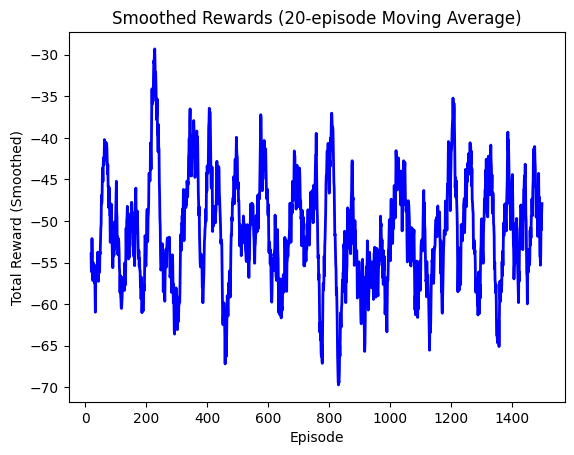

In [ ]:
import pandas as pd
plt.plot(pd.Series(new_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()


In [ ]:
all_rewards=rewards+ new_rewards+rewards_more

In [ ]:
plt.plot(rewards)
plt.title("Raw Rewards (Noisy)-200")
plt.plot(all_rewards)
plt.title("Raw Rewards (Noisy)-600")


In [ ]:
import pandas as pd
plt.plot(pd.Series(rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-Episode Moving Average)")


In [ ]:
!pip install stable_baselines3

# Re-initialize the PPOAgent model structure
loaded_agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load the state dictionary into the agent
loaded_agent.load_state_dict(torch.load("/content/ppo_traffic_model_1500.pt"))
loaded_agent.eval() # Set the model to evaluation mode

print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
env = TrafficEnv(data)
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)



In [ ]:
agent.load_state_dict(torch.load("ppo_traffic_model_1500.pt"))
print("Loaded model from 1500-episode checkpoint")


Loaded model from 1500-episode checkpoint


In [ ]:
print("Current learning rate:")
for g in agent.optimizer.param_groups:
    print(g['lr'])


Current learning rate:
0.0003


In [ ]:
for g in agent.optimizer.param_groups:
    g['lr'] = 1e-4

print("Learning rate successfully changed!")


Learning rate successfully changed!


In [ ]:
print("Current learning rate:")
for g in agent.optimizer.param_groups:
    print(g['lr'])

Current learning rate:
0.0001


In [ ]:
import os
import json

def train_ppo(
    episodes=200,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    reward_history = []

    # Resume from saved rewards if file exists
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"✅ Loaded {len(reward_history)} previous rewards from '{rewards_path}'")

    # Continue training for new episodes
    for episode in tqdm(range(len(reward_history), len(reward_history) + episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            # PPO update
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {episode + 1} | Total Reward: {total_reward:.2f}")

        # Save model & rewards every 10 episodes
        if (episode + 1) % 10 == 0:
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print(f"💾 Progress saved — {episode + 1} episodes complete")

    print("Training complete!")
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    return reward_history  # <- ✅ should be on its own line!

In [ ]:
# Training with new Learning Rate:

In [ ]:
print("Continuing training for 500 more episodes with DIFFERENT learning rate:")
rewards = train_ppo(episodes=500) # Directly assigning the full reward history
print("Training complete.")

Continuing training for 500 more episodes with DIFFERENT learning rate:
✅ Loaded 1500 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:04<37:59,  4.57s/it]

Episode 1501 | Total Reward: -93.75


  0%|          | 2/500 [00:07<32:19,  3.89s/it]

Episode 1502 | Total Reward: -79.88


  1%|          | 3/500 [00:08<20:49,  2.51s/it]

Episode 1503 | Total Reward: -19.86


  1%|          | 4/500 [00:11<22:17,  2.70s/it]

Episode 1504 | Total Reward: -69.33


  1%|          | 5/500 [00:16<28:58,  3.51s/it]

Episode 1505 | Total Reward: -101.44


  1%|          | 6/500 [00:20<29:25,  3.57s/it]

Episode 1506 | Total Reward: -85.56


  1%|▏         | 7/500 [00:23<27:56,  3.40s/it]

Episode 1507 | Total Reward: -70.58


  2%|▏         | 8/500 [00:28<30:40,  3.74s/it]

Episode 1508 | Total Reward: -88.58


  2%|▏         | 9/500 [00:28<22:24,  2.74s/it]

Episode 1509 | Total Reward: -13.27


  2%|▏         | 10/500 [00:30<21:08,  2.59s/it]

Episode 1510 | Total Reward: -51.33
💾 Progress saved — 1510 episodes complete


  2%|▏         | 11/500 [00:34<23:57,  2.94s/it]

Episode 1511 | Total Reward: -88.64


  2%|▏         | 12/500 [00:36<22:39,  2.79s/it]

Episode 1512 | Total Reward: -56.77


  3%|▎         | 13/500 [00:38<19:16,  2.38s/it]

Episode 1513 | Total Reward: -26.91


  3%|▎         | 14/500 [00:42<23:17,  2.87s/it]

Episode 1514 | Total Reward: -87.71


  3%|▎         | 15/500 [00:46<25:31,  3.16s/it]

Episode 1515 | Total Reward: -89.90


  3%|▎         | 16/500 [00:49<25:36,  3.17s/it]

Episode 1516 | Total Reward: -73.86


  3%|▎         | 17/500 [00:52<25:29,  3.17s/it]

Episode 1517 | Total Reward: -57.32


  4%|▎         | 18/500 [00:55<25:24,  3.16s/it]

Episode 1518 | Total Reward: -73.55


  4%|▍         | 19/500 [00:56<20:41,  2.58s/it]

Episode 1519 | Total Reward: -28.87


  4%|▍         | 20/500 [00:59<20:53,  2.61s/it]

Episode 1520 | Total Reward: -64.86
💾 Progress saved — 1520 episodes complete


  4%|▍         | 21/500 [01:03<24:09,  3.03s/it]

Episode 1521 | Total Reward: -83.51


  4%|▍         | 22/500 [01:03<17:28,  2.19s/it]

Episode 1522 | Total Reward: -5.06


  5%|▍         | 23/500 [01:06<18:32,  2.33s/it]

Episode 1523 | Total Reward: -61.91


  5%|▍         | 24/500 [01:09<20:03,  2.53s/it]

Episode 1524 | Total Reward: -71.31


  5%|▌         | 25/500 [01:13<22:54,  2.89s/it]

Episode 1525 | Total Reward: -91.18


  5%|▌         | 26/500 [01:16<23:03,  2.92s/it]

Episode 1526 | Total Reward: -54.30


  5%|▌         | 27/500 [01:20<25:03,  3.18s/it]

Episode 1527 | Total Reward: -91.54


  6%|▌         | 28/500 [01:20<19:39,  2.50s/it]

Episode 1528 | Total Reward: -21.45


  6%|▌         | 29/500 [01:22<18:04,  2.30s/it]

Episode 1529 | Total Reward: -44.69


  6%|▌         | 30/500 [01:23<13:51,  1.77s/it]

Episode 1530 | Total Reward: -13.21
💾 Progress saved — 1530 episodes complete


  6%|▌         | 31/500 [01:25<15:02,  1.92s/it]

Episode 1531 | Total Reward: -52.95


  6%|▋         | 32/500 [01:29<20:33,  2.64s/it]

Episode 1532 | Total Reward: -89.00


  7%|▋         | 33/500 [01:31<17:58,  2.31s/it]

Episode 1533 | Total Reward: -37.20


  7%|▋         | 34/500 [01:33<16:18,  2.10s/it]

Episode 1534 | Total Reward: -39.01


  7%|▋         | 35/500 [01:33<13:08,  1.70s/it]

Episode 1535 | Total Reward: -18.31


  7%|▋         | 36/500 [01:35<13:27,  1.74s/it]

Episode 1536 | Total Reward: -44.04


  7%|▋         | 37/500 [01:39<17:43,  2.30s/it]

Episode 1537 | Total Reward: -77.92


  8%|▊         | 38/500 [01:41<16:49,  2.18s/it]

Episode 1538 | Total Reward: -39.99


  8%|▊         | 39/500 [01:41<12:22,  1.61s/it]

Episode 1539 | Total Reward: -7.45


  8%|▊         | 40/500 [01:43<13:38,  1.78s/it]

Episode 1540 | Total Reward: -51.55
💾 Progress saved — 1540 episodes complete


  8%|▊         | 41/500 [01:44<12:35,  1.65s/it]

Episode 1541 | Total Reward: -31.81


  8%|▊         | 42/500 [01:48<17:16,  2.26s/it]

Episode 1542 | Total Reward: -87.84


  9%|▊         | 43/500 [01:52<20:15,  2.66s/it]

Episode 1543 | Total Reward: -72.39


  9%|▉         | 44/500 [01:55<21:02,  2.77s/it]

Episode 1544 | Total Reward: -71.71


  9%|▉         | 45/500 [01:58<22:04,  2.91s/it]

Episode 1545 | Total Reward: -77.59


  9%|▉         | 46/500 [02:01<22:29,  2.97s/it]

Episode 1546 | Total Reward: -73.67


  9%|▉         | 47/500 [02:05<24:13,  3.21s/it]

Episode 1547 | Total Reward: -74.70


 10%|▉         | 48/500 [02:07<21:43,  2.88s/it]

Episode 1548 | Total Reward: -49.66


 10%|▉         | 49/500 [02:08<17:23,  2.31s/it]

Episode 1549 | Total Reward: -22.36


 10%|█         | 50/500 [02:11<17:58,  2.40s/it]

Episode 1550 | Total Reward: -61.68
💾 Progress saved — 1550 episodes complete


 10%|█         | 51/500 [02:14<19:09,  2.56s/it]

Episode 1551 | Total Reward: -70.90


 10%|█         | 52/500 [02:17<21:33,  2.89s/it]

Episode 1552 | Total Reward: -73.86


 11%|█         | 53/500 [02:21<23:26,  3.15s/it]

Episode 1553 | Total Reward: -91.52


 11%|█         | 54/500 [02:23<21:48,  2.93s/it]

Episode 1554 | Total Reward: -57.08


 11%|█         | 55/500 [02:27<22:20,  3.01s/it]

Episode 1555 | Total Reward: -70.71


 11%|█         | 56/500 [02:28<18:03,  2.44s/it]

Episode 1556 | Total Reward: -19.13


 11%|█▏        | 57/500 [02:29<15:34,  2.11s/it]

Episode 1557 | Total Reward: -29.06


 12%|█▏        | 58/500 [02:30<12:37,  1.71s/it]

Episode 1558 | Total Reward: -19.26


 12%|█▏        | 59/500 [02:31<12:17,  1.67s/it]

Episode 1559 | Total Reward: -38.10


 12%|█▏        | 60/500 [02:33<12:39,  1.73s/it]

Episode 1560 | Total Reward: -43.79
💾 Progress saved — 1560 episodes complete


 12%|█▏        | 61/500 [02:35<12:45,  1.74s/it]

Episode 1561 | Total Reward: -42.55


 12%|█▏        | 62/500 [02:37<12:44,  1.74s/it]

Episode 1562 | Total Reward: -41.39


 13%|█▎        | 63/500 [02:39<14:20,  1.97s/it]

Episode 1563 | Total Reward: -50.75


 13%|█▎        | 64/500 [02:42<15:13,  2.09s/it]

Episode 1564 | Total Reward: -51.10


 13%|█▎        | 65/500 [02:46<19:37,  2.71s/it]

Episode 1565 | Total Reward: -100.65


 13%|█▎        | 66/500 [02:47<15:53,  2.20s/it]

Episode 1566 | Total Reward: -23.47


 13%|█▎        | 67/500 [02:50<17:52,  2.48s/it]

Episode 1567 | Total Reward: -76.80


 14%|█▎        | 68/500 [02:54<21:38,  3.01s/it]

Episode 1568 | Total Reward: -88.18


 14%|█▍        | 69/500 [02:58<23:17,  3.24s/it]

Episode 1569 | Total Reward: -92.57


 14%|█▍        | 70/500 [03:02<24:19,  3.39s/it]

Episode 1570 | Total Reward: -92.76
💾 Progress saved — 1570 episodes complete


 14%|█▍        | 71/500 [03:05<23:24,  3.27s/it]

Episode 1571 | Total Reward: -57.76


 14%|█▍        | 72/500 [03:06<19:43,  2.77s/it]

Episode 1572 | Total Reward: -38.31


 15%|█▍        | 73/500 [03:08<16:30,  2.32s/it]

Episode 1573 | Total Reward: -27.74


 15%|█▍        | 74/500 [03:09<15:09,  2.13s/it]

Episode 1574 | Total Reward: -39.77


 15%|█▌        | 75/500 [03:13<19:09,  2.70s/it]

Episode 1575 | Total Reward: -99.41


 15%|█▌        | 76/500 [03:15<16:28,  2.33s/it]

Episode 1576 | Total Reward: -29.69


 15%|█▌        | 77/500 [03:17<16:42,  2.37s/it]

Episode 1577 | Total Reward: -47.74


 16%|█▌        | 78/500 [03:18<13:50,  1.97s/it]

Episode 1578 | Total Reward: -25.14


 16%|█▌        | 79/500 [03:20<12:57,  1.85s/it]

Episode 1579 | Total Reward: -36.59


 16%|█▌        | 80/500 [03:23<15:26,  2.21s/it]

Episode 1580 | Total Reward: -73.23
💾 Progress saved — 1580 episodes complete


 16%|█▌        | 81/500 [03:26<16:24,  2.35s/it]

Episode 1581 | Total Reward: -63.50


 16%|█▋        | 82/500 [03:30<20:34,  2.95s/it]

Episode 1582 | Total Reward: -89.45


 17%|█▋        | 83/500 [03:32<18:28,  2.66s/it]

Episode 1583 | Total Reward: -46.24


 17%|█▋        | 84/500 [03:33<16:13,  2.34s/it]

Episode 1584 | Total Reward: -38.56


 17%|█▋        | 85/500 [03:36<17:11,  2.48s/it]

Episode 1585 | Total Reward: -69.07


 17%|█▋        | 86/500 [03:37<13:30,  1.96s/it]

Episode 1586 | Total Reward: -17.74


 17%|█▋        | 87/500 [03:41<17:37,  2.56s/it]

Episode 1587 | Total Reward: -81.13


 18%|█▊        | 88/500 [03:43<16:32,  2.41s/it]

Episode 1588 | Total Reward: -47.67


 18%|█▊        | 89/500 [03:44<13:12,  1.93s/it]

Episode 1589 | Total Reward: -19.23


 18%|█▊        | 90/500 [03:45<12:19,  1.80s/it]

Episode 1590 | Total Reward: -36.60
💾 Progress saved — 1590 episodes complete


 18%|█▊        | 91/500 [03:48<13:55,  2.04s/it]

Episode 1591 | Total Reward: -62.18


 18%|█▊        | 92/500 [03:51<16:51,  2.48s/it]

Episode 1592 | Total Reward: -78.31


 19%|█▊        | 93/500 [03:53<14:12,  2.09s/it]

Episode 1593 | Total Reward: -21.45


 19%|█▉        | 94/500 [03:56<16:47,  2.48s/it]

Episode 1594 | Total Reward: -81.15


 19%|█▉        | 95/500 [03:58<14:55,  2.21s/it]

Episode 1595 | Total Reward: -38.01


 19%|█▉        | 96/500 [03:59<13:52,  2.06s/it]

Episode 1596 | Total Reward: -41.76


 19%|█▉        | 97/500 [04:00<12:03,  1.79s/it]

Episode 1597 | Total Reward: -28.23


 20%|█▉        | 98/500 [04:03<13:12,  1.97s/it]

Episode 1598 | Total Reward: -53.54


 20%|█▉        | 99/500 [04:07<17:49,  2.67s/it]

Episode 1599 | Total Reward: -92.13


 20%|██        | 100/500 [04:10<18:35,  2.79s/it]

Episode 1600 | Total Reward: -74.62
💾 Progress saved — 1600 episodes complete


 20%|██        | 101/500 [04:14<20:58,  3.15s/it]

Episode 1601 | Total Reward: -98.39


 20%|██        | 102/500 [04:17<19:55,  3.00s/it]

Episode 1602 | Total Reward: -48.30


 21%|██        | 103/500 [04:18<15:48,  2.39s/it]

Episode 1603 | Total Reward: -21.90


 21%|██        | 104/500 [04:18<12:07,  1.84s/it]

Episode 1604 | Total Reward: -13.60


 21%|██        | 105/500 [04:19<09:30,  1.44s/it]

Episode 1605 | Total Reward: -13.52


 21%|██        | 106/500 [04:21<10:12,  1.55s/it]

Episode 1606 | Total Reward: -43.03


 21%|██▏       | 107/500 [04:22<09:37,  1.47s/it]

Episode 1607 | Total Reward: -30.80


 22%|██▏       | 108/500 [04:25<12:53,  1.97s/it]

Episode 1608 | Total Reward: -76.57


 22%|██▏       | 109/500 [04:25<09:34,  1.47s/it]

Episode 1609 | Total Reward: -7.72


 22%|██▏       | 110/500 [04:30<15:39,  2.41s/it]

Episode 1610 | Total Reward: -97.37
💾 Progress saved — 1610 episodes complete


 22%|██▏       | 111/500 [04:33<17:10,  2.65s/it]

Episode 1611 | Total Reward: -78.33


 22%|██▏       | 112/500 [04:37<19:41,  3.05s/it]

Episode 1612 | Total Reward: -98.12


 23%|██▎       | 113/500 [04:40<19:04,  2.96s/it]

Episode 1613 | Total Reward: -55.00


 23%|██▎       | 114/500 [04:41<15:11,  2.36s/it]

Episode 1614 | Total Reward: -16.60


 23%|██▎       | 115/500 [04:41<11:27,  1.79s/it]

Episode 1615 | Total Reward: -10.79


 23%|██▎       | 116/500 [04:42<08:40,  1.35s/it]

Episode 1616 | Total Reward: -9.24


 23%|██▎       | 117/500 [04:43<09:07,  1.43s/it]

Episode 1617 | Total Reward: -38.07


 24%|██▎       | 118/500 [04:45<09:01,  1.42s/it]

Episode 1618 | Total Reward: -32.55


 24%|██▍       | 119/500 [04:47<11:07,  1.75s/it]

Episode 1619 | Total Reward: -60.54


 24%|██▍       | 120/500 [04:51<15:23,  2.43s/it]

Episode 1620 | Total Reward: -92.57
💾 Progress saved — 1620 episodes complete


 24%|██▍       | 121/500 [04:55<18:19,  2.90s/it]

Episode 1621 | Total Reward: -82.17


 24%|██▍       | 122/500 [04:59<20:06,  3.19s/it]

Episode 1622 | Total Reward: -88.48


 25%|██▍       | 123/500 [05:01<17:54,  2.85s/it]

Episode 1623 | Total Reward: -47.81


 25%|██▍       | 124/500 [05:05<20:08,  3.21s/it]

Episode 1624 | Total Reward: -84.34


 25%|██▌       | 125/500 [05:09<20:11,  3.23s/it]

Episode 1625 | Total Reward: -77.09


 25%|██▌       | 126/500 [05:11<18:34,  2.98s/it]

Episode 1626 | Total Reward: -55.53


 25%|██▌       | 127/500 [05:11<13:32,  2.18s/it]

Episode 1627 | Total Reward: -7.90


 26%|██▌       | 128/500 [05:12<11:05,  1.79s/it]

Episode 1628 | Total Reward: -20.50


 26%|██▌       | 129/500 [05:14<10:35,  1.71s/it]

Episode 1629 | Total Reward: -35.82


 26%|██▌       | 130/500 [05:18<14:35,  2.36s/it]

Episode 1630 | Total Reward: -78.15
💾 Progress saved — 1630 episodes complete


 26%|██▌       | 131/500 [05:21<17:00,  2.76s/it]

Episode 1631 | Total Reward: -88.11


 26%|██▋       | 132/500 [05:22<13:46,  2.24s/it]

Episode 1632 | Total Reward: -24.78


 27%|██▋       | 133/500 [05:25<14:24,  2.36s/it]

Episode 1633 | Total Reward: -60.85


 27%|██▋       | 134/500 [05:26<12:01,  1.97s/it]

Episode 1634 | Total Reward: -25.63


 27%|██▋       | 135/500 [05:28<11:58,  1.97s/it]

Episode 1635 | Total Reward: -41.02


 27%|██▋       | 136/500 [05:29<09:49,  1.62s/it]

Episode 1636 | Total Reward: -14.53


 27%|██▋       | 137/500 [05:33<14:32,  2.40s/it]

Episode 1637 | Total Reward: -99.11


 28%|██▊       | 138/500 [05:36<14:45,  2.45s/it]

Episode 1638 | Total Reward: -59.91


 28%|██▊       | 139/500 [05:37<12:31,  2.08s/it]

Episode 1639 | Total Reward: -29.19


 28%|██▊       | 140/500 [05:41<16:04,  2.68s/it]

Episode 1640 | Total Reward: -88.30
💾 Progress saved — 1640 episodes complete


 28%|██▊       | 141/500 [05:44<17:11,  2.87s/it]

Episode 1641 | Total Reward: -76.01


 28%|██▊       | 142/500 [05:45<13:19,  2.23s/it]

Episode 1642 | Total Reward: -17.85


 29%|██▊       | 143/500 [05:47<13:55,  2.34s/it]

Episode 1643 | Total Reward: -61.54


 29%|██▉       | 144/500 [05:49<12:06,  2.04s/it]

Episode 1644 | Total Reward: -28.96


 29%|██▉       | 145/500 [05:53<15:01,  2.54s/it]

Episode 1645 | Total Reward: -82.97


 29%|██▉       | 146/500 [05:55<14:32,  2.46s/it]

Episode 1646 | Total Reward: -47.74


 29%|██▉       | 147/500 [05:58<15:32,  2.64s/it]

Episode 1647 | Total Reward: -71.77


 30%|██▉       | 148/500 [05:58<11:49,  2.02s/it]

Episode 1648 | Total Reward: -14.32


 30%|██▉       | 149/500 [06:02<15:15,  2.61s/it]

Episode 1649 | Total Reward: -97.91


 30%|███       | 150/500 [06:05<15:38,  2.68s/it]

Episode 1650 | Total Reward: -27.64
💾 Progress saved — 1650 episodes complete


 30%|███       | 151/500 [06:10<18:54,  3.25s/it]

Episode 1651 | Total Reward: -85.41


 30%|███       | 152/500 [06:15<22:02,  3.80s/it]

Episode 1652 | Total Reward: -94.12


 31%|███       | 153/500 [06:19<22:45,  3.94s/it]

Episode 1653 | Total Reward: -52.02


 31%|███       | 154/500 [06:22<20:33,  3.57s/it]

Episode 1654 | Total Reward: -63.58


 31%|███       | 155/500 [06:23<16:21,  2.85s/it]

Episode 1655 | Total Reward: -27.74


 31%|███       | 156/500 [06:25<14:25,  2.52s/it]

Episode 1656 | Total Reward: -42.07


 31%|███▏      | 157/500 [06:26<12:57,  2.27s/it]

Episode 1657 | Total Reward: -40.21


 32%|███▏      | 158/500 [06:30<15:44,  2.76s/it]

Episode 1658 | Total Reward: -81.07


 32%|███▏      | 159/500 [06:32<13:38,  2.40s/it]

Episode 1659 | Total Reward: -36.18


 32%|███▏      | 160/500 [06:36<16:27,  2.90s/it]

Episode 1660 | Total Reward: -95.05
💾 Progress saved — 1660 episodes complete


 32%|███▏      | 161/500 [06:40<18:55,  3.35s/it]

Episode 1661 | Total Reward: -90.68


 32%|███▏      | 162/500 [06:44<19:26,  3.45s/it]

Episode 1662 | Total Reward: -75.86


 33%|███▎      | 163/500 [06:45<15:26,  2.75s/it]

Episode 1663 | Total Reward: -26.93


 33%|███▎      | 164/500 [06:49<17:02,  3.04s/it]

Episode 1664 | Total Reward: -90.83


 33%|███▎      | 165/500 [06:52<17:10,  3.08s/it]

Episode 1665 | Total Reward: -76.88


 33%|███▎      | 166/500 [06:55<17:18,  3.11s/it]

Episode 1666 | Total Reward: -62.02


 33%|███▎      | 167/500 [06:57<14:36,  2.63s/it]

Episode 1667 | Total Reward: -36.84


 34%|███▎      | 168/500 [07:01<16:51,  3.05s/it]

Episode 1668 | Total Reward: -99.25


 34%|███▍      | 169/500 [07:02<14:31,  2.63s/it]

Episode 1669 | Total Reward: -40.95


 34%|███▍      | 170/500 [07:05<14:29,  2.63s/it]

Episode 1670 | Total Reward: -58.07
💾 Progress saved — 1670 episodes complete


 34%|███▍      | 171/500 [07:07<12:42,  2.32s/it]

Episode 1671 | Total Reward: -27.90


 35%|███▍      | 173/500 [07:07<06:52,  1.26s/it]

Episode 1672 | Total Reward: -8.44
Episode 1673 | Total Reward: -4.95


 35%|███▍      | 174/500 [07:10<09:10,  1.69s/it]

Episode 1674 | Total Reward: -61.66


 35%|███▌      | 175/500 [07:13<12:12,  2.25s/it]

Episode 1675 | Total Reward: -85.22


 35%|███▌      | 176/500 [07:17<14:04,  2.61s/it]

Episode 1676 | Total Reward: -77.92


 35%|███▌      | 177/500 [07:21<17:09,  3.19s/it]

Episode 1677 | Total Reward: -97.42


 36%|███▌      | 178/500 [07:24<16:23,  3.06s/it]

Episode 1678 | Total Reward: -66.39


 36%|███▌      | 179/500 [07:27<15:55,  2.98s/it]

Episode 1679 | Total Reward: -67.18


 36%|███▌      | 180/500 [07:30<16:40,  3.13s/it]

Episode 1680 | Total Reward: -70.46
💾 Progress saved — 1680 episodes complete


 36%|███▌      | 181/500 [07:31<12:28,  2.34s/it]

Episode 1681 | Total Reward: -10.81


 36%|███▋      | 182/500 [07:34<13:46,  2.60s/it]

Episode 1682 | Total Reward: -76.68


 37%|███▋      | 183/500 [07:38<14:57,  2.83s/it]

Episode 1683 | Total Reward: -82.42


 37%|███▋      | 184/500 [07:38<11:50,  2.25s/it]

Episode 1684 | Total Reward: -20.63


 37%|███▋      | 185/500 [07:43<15:34,  2.97s/it]

Episode 1685 | Total Reward: -99.25


 37%|███▋      | 186/500 [07:44<11:40,  2.23s/it]

Episode 1686 | Total Reward: -12.91


 37%|███▋      | 187/500 [07:47<13:17,  2.55s/it]

Episode 1687 | Total Reward: -80.11


 38%|███▊      | 188/500 [07:48<11:20,  2.18s/it]

Episode 1688 | Total Reward: -31.48


 38%|███▊      | 189/500 [07:51<12:16,  2.37s/it]

Episode 1689 | Total Reward: -66.00


 38%|███▊      | 190/500 [07:53<12:01,  2.33s/it]

Episode 1690 | Total Reward: -49.50
💾 Progress saved — 1690 episodes complete


 38%|███▊      | 191/500 [07:57<13:36,  2.64s/it]

Episode 1691 | Total Reward: -70.49


 38%|███▊      | 192/500 [07:57<10:15,  2.00s/it]

Episode 1692 | Total Reward: -12.21


 39%|███▊      | 193/500 [07:59<09:36,  1.88s/it]

Episode 1693 | Total Reward: -38.56


 39%|███▉      | 194/500 [08:01<10:52,  2.13s/it]

Episode 1694 | Total Reward: -67.13


 39%|███▉      | 195/500 [08:03<10:27,  2.06s/it]

Episode 1695 | Total Reward: -45.10


 39%|███▉      | 196/500 [08:07<12:09,  2.40s/it]

Episode 1696 | Total Reward: -49.63


 39%|███▉      | 197/500 [08:10<13:41,  2.71s/it]

Episode 1697 | Total Reward: -77.72


 40%|███▉      | 198/500 [08:12<12:38,  2.51s/it]

Episode 1698 | Total Reward: -48.91


 40%|███▉      | 199/500 [08:15<13:59,  2.79s/it]

Episode 1699 | Total Reward: -83.13


 40%|████      | 200/500 [08:17<12:23,  2.48s/it]

Episode 1700 | Total Reward: -41.48
💾 Progress saved — 1700 episodes complete


 40%|████      | 201/500 [08:21<14:10,  2.84s/it]

Episode 1701 | Total Reward: -74.94


 40%|████      | 202/500 [08:21<10:26,  2.10s/it]

Episode 1702 | Total Reward: -9.46


 41%|████      | 203/500 [08:22<08:23,  1.70s/it]

Episode 1703 | Total Reward: -18.48


 41%|████      | 204/500 [08:25<10:32,  2.14s/it]

Episode 1704 | Total Reward: -75.81


 41%|████      | 205/500 [08:29<12:46,  2.60s/it]

Episode 1705 | Total Reward: -89.07


 41%|████      | 206/500 [08:30<10:18,  2.10s/it]

Episode 1706 | Total Reward: -18.38


 41%|████▏     | 207/500 [08:34<13:41,  2.80s/it]

Episode 1707 | Total Reward: -97.74


 42%|████▏     | 208/500 [08:37<13:48,  2.84s/it]

Episode 1708 | Total Reward: -69.97


 42%|████▏     | 209/500 [08:41<15:38,  3.22s/it]

Episode 1709 | Total Reward: -100.98


 42%|████▏     | 210/500 [08:45<15:46,  3.26s/it]

Episode 1710 | Total Reward: -67.13
💾 Progress saved — 1710 episodes complete


 42%|████▏     | 211/500 [08:47<14:38,  3.04s/it]

Episode 1711 | Total Reward: -59.96


 42%|████▏     | 212/500 [08:49<12:48,  2.67s/it]

Episode 1712 | Total Reward: -43.04


 43%|████▎     | 213/500 [08:50<10:32,  2.20s/it]

Episode 1713 | Total Reward: -27.52


 43%|████▎     | 214/500 [08:53<12:05,  2.54s/it]

Episode 1714 | Total Reward: -80.19


 43%|████▎     | 215/500 [08:57<13:38,  2.87s/it]

Episode 1715 | Total Reward: -74.46


 43%|████▎     | 216/500 [08:59<12:56,  2.73s/it]

Episode 1716 | Total Reward: -56.55


 43%|████▎     | 217/500 [09:02<12:04,  2.56s/it]

Episode 1717 | Total Reward: -51.45


 44%|████▎     | 218/500 [09:04<11:08,  2.37s/it]

Episode 1718 | Total Reward: -46.45


 44%|████▍     | 219/500 [09:04<08:56,  1.91s/it]

Episode 1719 | Total Reward: -20.08


 44%|████▍     | 220/500 [09:06<08:54,  1.91s/it]

Episode 1720 | Total Reward: -40.21
💾 Progress saved — 1720 episodes complete


 44%|████▍     | 221/500 [09:07<07:11,  1.55s/it]

Episode 1721 | Total Reward: -13.27


 44%|████▍     | 222/500 [09:09<08:22,  1.81s/it]

Episode 1722 | Total Reward: -52.02


 45%|████▍     | 223/500 [09:11<08:23,  1.82s/it]

Episode 1723 | Total Reward: -43.79


 45%|████▍     | 224/500 [09:12<07:09,  1.56s/it]

Episode 1724 | Total Reward: -22.36


 45%|████▌     | 225/500 [09:13<05:56,  1.30s/it]

Episode 1725 | Total Reward: -17.51


 45%|████▌     | 226/500 [09:15<07:29,  1.64s/it]

Episode 1726 | Total Reward: -57.64


 45%|████▌     | 227/500 [09:16<06:17,  1.38s/it]

Episode 1727 | Total Reward: -18.76


 46%|████▌     | 228/500 [09:18<07:13,  1.59s/it]

Episode 1728 | Total Reward: -44.65


 46%|████▌     | 229/500 [09:21<08:54,  1.97s/it]

Episode 1729 | Total Reward: -57.40


 46%|████▌     | 230/500 [09:24<10:40,  2.37s/it]

Episode 1730 | Total Reward: -80.11
💾 Progress saved — 1730 episodes complete


 46%|████▌     | 231/500 [09:27<10:48,  2.41s/it]

Episode 1731 | Total Reward: -59.87


 46%|████▋     | 232/500 [09:28<08:35,  1.92s/it]

Episode 1732 | Total Reward: -18.69


 47%|████▋     | 233/500 [09:32<11:44,  2.64s/it]

Episode 1733 | Total Reward: -88.48


 47%|████▋     | 234/500 [09:36<12:57,  2.92s/it]

Episode 1734 | Total Reward: -85.53


 47%|████▋     | 235/500 [09:39<13:20,  3.02s/it]

Episode 1735 | Total Reward: -76.83


 47%|████▋     | 236/500 [09:41<12:28,  2.84s/it]

Episode 1736 | Total Reward: -57.08


 47%|████▋     | 237/500 [09:43<10:39,  2.43s/it]

Episode 1737 | Total Reward: -28.64


 48%|████▊     | 238/500 [09:46<11:15,  2.58s/it]

Episode 1738 | Total Reward: -60.93


 48%|████▊     | 239/500 [09:49<12:39,  2.91s/it]

Episode 1739 | Total Reward: -89.36


 48%|████▊     | 240/500 [09:53<13:21,  3.08s/it]

Episode 1740 | Total Reward: -82.42
💾 Progress saved — 1740 episodes complete


 48%|████▊     | 241/500 [09:54<10:55,  2.53s/it]

Episode 1741 | Total Reward: -28.23


 48%|████▊     | 242/500 [09:57<11:01,  2.57s/it]

Episode 1742 | Total Reward: -49.85


 49%|████▊     | 243/500 [09:58<09:10,  2.14s/it]

Episode 1743 | Total Reward: -27.69


 49%|████▉     | 244/500 [10:00<08:34,  2.01s/it]

Episode 1744 | Total Reward: -41.39


 49%|████▉     | 245/500 [10:02<08:49,  2.08s/it]

Episode 1745 | Total Reward: -52.95


 49%|████▉     | 246/500 [10:03<07:55,  1.87s/it]

Episode 1746 | Total Reward: -32.99


 49%|████▉     | 247/500 [10:07<10:34,  2.51s/it]

Episode 1747 | Total Reward: -89.54


 50%|████▉     | 248/500 [10:07<07:48,  1.86s/it]

Episode 1748 | Total Reward: -6.77


 50%|████▉     | 249/500 [10:09<06:51,  1.64s/it]

Episode 1749 | Total Reward: -22.32


 50%|█████     | 250/500 [10:12<09:07,  2.19s/it]

Episode 1750 | Total Reward: -84.97
💾 Progress saved — 1750 episodes complete


 50%|█████     | 251/500 [10:14<09:02,  2.18s/it]

Episode 1751 | Total Reward: -50.58


 50%|█████     | 252/500 [10:15<06:53,  1.67s/it]

Episode 1752 | Total Reward: -11.89


 51%|█████     | 253/500 [10:16<06:22,  1.55s/it]

Episode 1753 | Total Reward: -30.52


 51%|█████     | 254/500 [10:19<07:45,  1.89s/it]

Episode 1754 | Total Reward: -59.10


 51%|█████     | 255/500 [10:22<09:33,  2.34s/it]

Episode 1755 | Total Reward: -72.46


 51%|█████     | 256/500 [10:24<09:06,  2.24s/it]

Episode 1756 | Total Reward: -45.86


 51%|█████▏    | 257/500 [10:26<08:07,  2.01s/it]

Episode 1757 | Total Reward: -35.25


 52%|█████▏    | 258/500 [10:29<10:23,  2.58s/it]

Episode 1758 | Total Reward: -94.40


 52%|█████▏    | 259/500 [10:34<12:42,  3.17s/it]

Episode 1759 | Total Reward: -97.98


 52%|█████▏    | 260/500 [10:36<10:58,  2.74s/it]

Episode 1760 | Total Reward: -41.50
💾 Progress saved — 1760 episodes complete


 52%|█████▏    | 261/500 [10:37<09:31,  2.39s/it]

Episode 1761 | Total Reward: -38.07


 52%|█████▏    | 262/500 [10:38<07:28,  1.89s/it]

Episode 1762 | Total Reward: -17.04


 53%|█████▎    | 263/500 [10:39<06:17,  1.59s/it]

Episode 1763 | Total Reward: -21.22


 53%|█████▎    | 264/500 [10:41<06:18,  1.60s/it]

Episode 1764 | Total Reward: -38.68


 53%|█████▎    | 265/500 [10:41<05:03,  1.29s/it]

Episode 1765 | Total Reward: -14.12


 53%|█████▎    | 266/500 [10:44<07:14,  1.86s/it]

Episode 1766 | Total Reward: -64.74


 53%|█████▎    | 267/500 [10:45<06:16,  1.62s/it]

Episode 1767 | Total Reward: -25.83


 54%|█████▎    | 268/500 [10:47<06:11,  1.60s/it]

Episode 1768 | Total Reward: -37.93


 54%|█████▍    | 269/500 [10:48<05:17,  1.37s/it]

Episode 1769 | Total Reward: -20.08


 54%|█████▍    | 270/500 [10:48<04:30,  1.18s/it]

Episode 1770 | Total Reward: -17.56
💾 Progress saved — 1770 episodes complete


 54%|█████▍    | 271/500 [10:50<05:27,  1.43s/it]

Episode 1771 | Total Reward: -47.67


 54%|█████▍    | 272/500 [10:54<08:03,  2.12s/it]

Episode 1772 | Total Reward: -89.66


 55%|█████▍    | 273/500 [10:57<09:13,  2.44s/it]

Episode 1773 | Total Reward: -61.89


 55%|█████▍    | 274/500 [10:59<08:44,  2.32s/it]

Episode 1774 | Total Reward: -47.01


 55%|█████▌    | 275/500 [11:03<10:00,  2.67s/it]

Episode 1775 | Total Reward: -82.17


 55%|█████▌    | 276/500 [11:03<07:26,  1.99s/it]

Episode 1776 | Total Reward: -10.07


 55%|█████▌    | 277/500 [11:05<07:25,  2.00s/it]

Episode 1777 | Total Reward: -47.01


 56%|█████▌    | 278/500 [11:06<05:37,  1.52s/it]

Episode 1778 | Total Reward: -10.10


 56%|█████▌    | 279/500 [11:10<08:57,  2.43s/it]

Episode 1779 | Total Reward: -92.66


 56%|█████▌    | 280/500 [11:13<08:57,  2.44s/it]

Episode 1780 | Total Reward: -56.77
💾 Progress saved — 1780 episodes complete


 56%|█████▌    | 281/500 [11:16<10:14,  2.81s/it]

Episode 1781 | Total Reward: -85.86


 56%|█████▋    | 282/500 [11:18<08:48,  2.42s/it]

Episode 1782 | Total Reward: -36.05


 57%|█████▋    | 283/500 [11:19<07:10,  1.99s/it]

Episode 1783 | Total Reward: -19.00


 57%|█████▋    | 284/500 [11:20<06:26,  1.79s/it]

Episode 1784 | Total Reward: -23.39


 57%|█████▋    | 285/500 [11:24<08:58,  2.51s/it]

Episode 1785 | Total Reward: -98.53


 57%|█████▋    | 286/500 [11:28<09:39,  2.71s/it]

Episode 1786 | Total Reward: -75.39


 57%|█████▋    | 287/500 [11:30<09:33,  2.69s/it]

Episode 1787 | Total Reward: -63.10


 58%|█████▊    | 288/500 [11:32<08:17,  2.35s/it]

Episode 1788 | Total Reward: -28.42


 58%|█████▊    | 289/500 [11:36<10:00,  2.85s/it]

Episode 1789 | Total Reward: -89.73


 58%|█████▊    | 290/500 [11:36<07:27,  2.13s/it]

Episode 1790 | Total Reward: -11.43
💾 Progress saved — 1790 episodes complete


 58%|█████▊    | 291/500 [11:37<05:50,  1.68s/it]

Episode 1791 | Total Reward: -14.62


 58%|█████▊    | 292/500 [11:38<04:46,  1.38s/it]

Episode 1792 | Total Reward: -16.68


 59%|█████▊    | 293/500 [11:40<06:16,  1.82s/it]

Episode 1793 | Total Reward: -68.26


 59%|█████▉    | 294/500 [11:45<09:11,  2.68s/it]

Episode 1794 | Total Reward: -99.70


 59%|█████▉    | 295/500 [11:47<07:56,  2.33s/it]

Episode 1795 | Total Reward: -36.68


 59%|█████▉    | 296/500 [11:48<07:08,  2.10s/it]

Episode 1796 | Total Reward: -36.60


 59%|█████▉    | 297/500 [11:50<07:12,  2.13s/it]

Episode 1797 | Total Reward: -50.63


 60%|█████▉    | 298/500 [11:54<08:58,  2.67s/it]

Episode 1798 | Total Reward: -94.50


 60%|█████▉    | 299/500 [11:58<09:50,  2.94s/it]

Episode 1799 | Total Reward: -71.31


 60%|██████    | 300/500 [11:59<07:33,  2.27s/it]

Episode 1800 | Total Reward: -16.51
💾 Progress saved — 1800 episodes complete


 60%|██████    | 301/500 [12:00<06:34,  1.98s/it]

Episode 1801 | Total Reward: -29.86


 60%|██████    | 302/500 [12:02<06:44,  2.04s/it]

Episode 1802 | Total Reward: -50.58


 61%|██████    | 303/500 [12:03<06:05,  1.85s/it]

Episode 1803 | Total Reward: -33.65


 61%|██████    | 304/500 [12:08<08:44,  2.68s/it]

Episode 1804 | Total Reward: -100.65


 61%|██████    | 305/500 [12:12<09:51,  3.03s/it]

Episode 1805 | Total Reward: -84.14


 61%|██████    | 306/500 [12:13<07:41,  2.38s/it]

Episode 1806 | Total Reward: -20.08


 61%|██████▏   | 307/500 [12:17<09:27,  2.94s/it]

Episode 1807 | Total Reward: -100.01


 62%|██████▏   | 308/500 [12:21<10:31,  3.29s/it]

Episode 1808 | Total Reward: -82.17


 62%|██████▏   | 309/500 [12:24<09:34,  3.01s/it]

Episode 1809 | Total Reward: -53.50


 62%|██████▏   | 310/500 [12:27<10:06,  3.19s/it]

Episode 1810 | Total Reward: -84.50
💾 Progress saved — 1810 episodes complete


 62%|██████▏   | 311/500 [12:27<07:16,  2.31s/it]

Episode 1811 | Total Reward: -5.87


 62%|██████▏   | 312/500 [12:30<07:30,  2.40s/it]

Episode 1812 | Total Reward: -59.10


 63%|██████▎   | 313/500 [12:34<08:37,  2.77s/it]

Episode 1813 | Total Reward: -69.57


 63%|██████▎   | 314/500 [12:37<09:27,  3.05s/it]

Episode 1814 | Total Reward: -88.18


 63%|██████▎   | 315/500 [12:39<08:03,  2.61s/it]

Episode 1815 | Total Reward: -37.10


 63%|██████▎   | 316/500 [12:42<08:45,  2.86s/it]

Episode 1816 | Total Reward: -80.84


 63%|██████▎   | 317/500 [12:45<08:10,  2.68s/it]

Episode 1817 | Total Reward: -44.95


 64%|██████▎   | 318/500 [12:49<09:38,  3.18s/it]

Episode 1818 | Total Reward: -97.10


 64%|██████▍   | 319/500 [12:50<07:54,  2.62s/it]

Episode 1819 | Total Reward: -30.44


 64%|██████▍   | 320/500 [12:51<05:54,  1.97s/it]

Episode 1820 | Total Reward: -11.12
💾 Progress saved — 1820 episodes complete


 64%|██████▍   | 321/500 [12:52<05:10,  1.73s/it]

Episode 1821 | Total Reward: -27.13


 64%|██████▍   | 322/500 [12:56<07:16,  2.45s/it]

Episode 1822 | Total Reward: -93.13


 65%|██████▍   | 323/500 [12:57<05:37,  1.91s/it]

Episode 1823 | Total Reward: -11.57


 65%|██████▍   | 324/500 [12:59<05:32,  1.89s/it]

Episode 1824 | Total Reward: -36.84


 65%|██████▌   | 325/500 [13:01<05:54,  2.02s/it]

Episode 1825 | Total Reward: -53.98


 65%|██████▌   | 326/500 [13:01<04:33,  1.57s/it]

Episode 1826 | Total Reward: -12.45


 65%|██████▌   | 327/500 [13:02<03:57,  1.37s/it]

Episode 1827 | Total Reward: -20.79


 66%|██████▌   | 328/500 [13:04<04:15,  1.48s/it]

Episode 1828 | Total Reward: -41.93


 66%|██████▌   | 329/500 [13:04<03:09,  1.11s/it]

Episode 1829 | Total Reward: -5.87


 66%|██████▌   | 330/500 [13:06<03:55,  1.39s/it]

Episode 1830 | Total Reward: -47.67
💾 Progress saved — 1830 episodes complete


 66%|██████▋   | 332/500 [13:11<04:26,  1.59s/it]

Episode 1831 | Total Reward: -81.15
Episode 1832 | Total Reward: -4.81


 67%|██████▋   | 333/500 [13:14<05:42,  2.05s/it]

Episode 1833 | Total Reward: -74.94


 67%|██████▋   | 334/500 [13:18<07:22,  2.67s/it]

Episode 1834 | Total Reward: -97.61


 67%|██████▋   | 335/500 [13:19<05:47,  2.11s/it]

Episode 1835 | Total Reward: -18.76


 67%|██████▋   | 336/500 [13:23<07:17,  2.67s/it]

Episode 1836 | Total Reward: -79.64


 67%|██████▋   | 337/500 [13:24<05:58,  2.20s/it]

Episode 1837 | Total Reward: -26.66


 68%|██████▊   | 338/500 [13:27<06:41,  2.48s/it]

Episode 1838 | Total Reward: -75.31


 68%|██████▊   | 339/500 [13:27<04:59,  1.86s/it]

Episode 1839 | Total Reward: -9.85


 68%|██████▊   | 340/500 [13:28<04:18,  1.61s/it]

Episode 1840 | Total Reward: -25.51
💾 Progress saved — 1840 episodes complete


 68%|██████▊   | 341/500 [13:29<03:19,  1.25s/it]

Episode 1841 | Total Reward: -10.57


 68%|██████▊   | 342/500 [13:33<05:26,  2.06s/it]

Episode 1842 | Total Reward: -91.14


 69%|██████▊   | 343/500 [13:36<06:48,  2.60s/it]

Episode 1843 | Total Reward: -84.65


 69%|██████▉   | 344/500 [13:40<07:47,  3.00s/it]

Episode 1844 | Total Reward: -96.49


 69%|██████▉   | 345/500 [13:44<08:21,  3.24s/it]

Episode 1845 | Total Reward: -90.17


 69%|██████▉   | 346/500 [13:45<06:08,  2.40s/it]

Episode 1846 | Total Reward: -8.59


 69%|██████▉   | 347/500 [13:47<05:59,  2.35s/it]

Episode 1847 | Total Reward: -43.04


 70%|██████▉   | 348/500 [13:51<07:05,  2.80s/it]

Episode 1848 | Total Reward: -92.76


 70%|██████▉   | 349/500 [13:53<06:31,  2.59s/it]

Episode 1849 | Total Reward: -48.63


 70%|███████   | 350/500 [13:57<08:02,  3.21s/it]

Episode 1850 | Total Reward: -99.91
💾 Progress saved — 1850 episodes complete


 70%|███████   | 351/500 [13:58<06:05,  2.45s/it]

Episode 1851 | Total Reward: -11.57


 70%|███████   | 352/500 [14:00<05:31,  2.24s/it]

Episode 1852 | Total Reward: -40.39


 71%|███████   | 353/500 [14:00<04:00,  1.64s/it]

Episode 1853 | Total Reward: -5.60


 71%|███████   | 354/500 [14:01<03:14,  1.33s/it]

Episode 1854 | Total Reward: -14.47


 71%|███████   | 355/500 [14:03<03:34,  1.48s/it]

Episode 1855 | Total Reward: -43.26


 71%|███████   | 356/500 [14:03<02:55,  1.22s/it]

Episode 1856 | Total Reward: -14.98


 71%|███████▏  | 357/500 [14:05<03:36,  1.52s/it]

Episode 1857 | Total Reward: -51.29


 72%|███████▏  | 358/500 [14:08<04:40,  1.97s/it]

Episode 1858 | Total Reward: -70.58


 72%|███████▏  | 359/500 [14:12<05:45,  2.45s/it]

Episode 1859 | Total Reward: -71.48


 72%|███████▏  | 360/500 [14:14<05:40,  2.43s/it]

Episode 1860 | Total Reward: -55.53
💾 Progress saved — 1860 episodes complete


 72%|███████▏  | 361/500 [14:17<05:38,  2.43s/it]

Episode 1861 | Total Reward: -57.04


 72%|███████▏  | 362/500 [14:19<05:31,  2.41s/it]

Episode 1862 | Total Reward: -55.24


 73%|███████▎  | 363/500 [14:19<04:03,  1.78s/it]

Episode 1863 | Total Reward: -8.26


 73%|███████▎  | 364/500 [14:23<05:20,  2.35s/it]

Episode 1864 | Total Reward: -74.46


 73%|███████▎  | 365/500 [14:24<04:25,  1.96s/it]

Episode 1865 | Total Reward: -25.39


 73%|███████▎  | 366/500 [14:25<03:20,  1.50s/it]

Episode 1866 | Total Reward: -9.85


 73%|███████▎  | 367/500 [14:27<03:40,  1.66s/it]

Episode 1867 | Total Reward: -46.45


 74%|███████▎  | 368/500 [14:28<03:22,  1.54s/it]

Episode 1868 | Total Reward: -29.19


 74%|███████▍  | 369/500 [14:30<03:43,  1.71s/it]

Episode 1869 | Total Reward: -49.63


 74%|███████▍  | 370/500 [14:34<05:10,  2.39s/it]

Episode 1870 | Total Reward: -87.99
💾 Progress saved — 1870 episodes complete


 74%|███████▍  | 371/500 [14:36<04:54,  2.28s/it]

Episode 1871 | Total Reward: -43.22


 74%|███████▍  | 372/500 [14:38<04:26,  2.08s/it]

Episode 1872 | Total Reward: -38.31


 75%|███████▍  | 373/500 [14:41<05:09,  2.43s/it]

Episode 1873 | Total Reward: -77.21


 75%|███████▍  | 374/500 [14:45<05:59,  2.85s/it]

Episode 1874 | Total Reward: -91.28


 75%|███████▌  | 375/500 [14:45<04:27,  2.14s/it]

Episode 1875 | Total Reward: -9.37


 75%|███████▌  | 376/500 [14:47<04:01,  1.95s/it]

Episode 1876 | Total Reward: -26.54


 75%|███████▌  | 377/500 [14:48<03:28,  1.70s/it]

Episode 1877 | Total Reward: -27.22


 76%|███████▌  | 378/500 [14:51<04:09,  2.05s/it]

Episode 1878 | Total Reward: -68.78


 76%|███████▌  | 379/500 [14:53<04:05,  2.03s/it]

Episode 1879 | Total Reward: -46.76


 76%|███████▌  | 380/500 [14:53<03:14,  1.62s/it]

Episode 1880 | Total Reward: -15.89
💾 Progress saved — 1880 episodes complete


 76%|███████▌  | 381/500 [14:57<04:23,  2.21s/it]

Episode 1881 | Total Reward: -83.77


 76%|███████▋  | 382/500 [14:57<03:21,  1.71s/it]

Episode 1882 | Total Reward: -9.92


 77%|███████▋  | 383/500 [14:59<03:17,  1.69s/it]

Episode 1883 | Total Reward: -30.44


 77%|███████▋  | 384/500 [15:02<04:09,  2.15s/it]

Episode 1884 | Total Reward: -76.96


 77%|███████▋  | 385/500 [15:05<04:31,  2.36s/it]

Episode 1885 | Total Reward: -70.36


 77%|███████▋  | 386/500 [15:06<03:22,  1.78s/it]

Episode 1886 | Total Reward: -10.79


 77%|███████▋  | 387/500 [15:06<02:46,  1.47s/it]

Episode 1887 | Total Reward: -18.56


 78%|███████▊  | 388/500 [15:09<03:37,  1.94s/it]

Episode 1888 | Total Reward: -68.24


 78%|███████▊  | 389/500 [15:12<04:07,  2.23s/it]

Episode 1889 | Total Reward: -57.01


 78%|███████▊  | 390/500 [15:16<04:47,  2.61s/it]

Episode 1890 | Total Reward: -83.19
💾 Progress saved — 1890 episodes complete


 78%|███████▊  | 391/500 [15:19<04:52,  2.68s/it]

Episode 1891 | Total Reward: -69.01


 78%|███████▊  | 392/500 [15:23<05:34,  3.09s/it]

Episode 1892 | Total Reward: -85.56


 79%|███████▊  | 393/500 [15:26<05:46,  3.24s/it]

Episode 1893 | Total Reward: -84.14


 79%|███████▉  | 394/500 [15:28<04:52,  2.76s/it]

Episode 1894 | Total Reward: -39.49


 79%|███████▉  | 395/500 [15:29<03:51,  2.20s/it]

Episode 1895 | Total Reward: -21.45


 79%|███████▉  | 396/500 [15:32<04:28,  2.58s/it]

Episode 1896 | Total Reward: -84.14


 79%|███████▉  | 397/500 [15:37<05:31,  3.22s/it]

Episode 1897 | Total Reward: -98.84


 80%|███████▉  | 398/500 [15:40<05:21,  3.15s/it]

Episode 1898 | Total Reward: -72.01


 80%|███████▉  | 399/500 [15:40<03:56,  2.34s/it]

Episode 1899 | Total Reward: -10.92


 80%|████████  | 400/500 [15:44<04:38,  2.79s/it]

Episode 1900 | Total Reward: -93.75
💾 Progress saved — 1900 episodes complete


 80%|████████  | 401/500 [15:48<05:05,  3.09s/it]

Episode 1901 | Total Reward: -74.64


 80%|████████  | 402/500 [15:49<03:55,  2.40s/it]

Episode 1902 | Total Reward: -18.76


 81%|████████  | 403/500 [15:50<03:03,  1.89s/it]

Episode 1903 | Total Reward: -17.40


 81%|████████  | 404/500 [15:52<03:05,  1.94s/it]

Episode 1904 | Total Reward: -48.63


 81%|████████  | 405/500 [15:55<03:52,  2.45s/it]

Episode 1905 | Total Reward: -88.58


 81%|████████  | 406/500 [15:56<03:05,  1.98s/it]

Episode 1906 | Total Reward: -19.86


 81%|████████▏ | 407/500 [15:59<03:24,  2.20s/it]

Episode 1907 | Total Reward: -54.78


 82%|████████▏ | 408/500 [16:00<03:06,  2.03s/it]

Episode 1908 | Total Reward: -34.56


 82%|████████▏ | 409/500 [16:03<03:05,  2.04s/it]

Episode 1909 | Total Reward: -49.64


 82%|████████▏ | 410/500 [16:03<02:16,  1.52s/it]

Episode 1910 | Total Reward: -8.12
💾 Progress saved — 1910 episodes complete


 82%|████████▏ | 411/500 [16:05<02:34,  1.74s/it]

Episode 1911 | Total Reward: -53.72


 82%|████████▏ | 412/500 [16:06<02:22,  1.62s/it]

Episode 1912 | Total Reward: -31.64


 83%|████████▎ | 413/500 [16:07<01:51,  1.28s/it]

Episode 1913 | Total Reward: -12.12


 83%|████████▎ | 414/500 [16:10<02:42,  1.89s/it]

Episode 1914 | Total Reward: -74.35


 83%|████████▎ | 415/500 [16:15<03:41,  2.61s/it]

Episode 1915 | Total Reward: -95.26


 83%|████████▎ | 416/500 [16:17<03:42,  2.65s/it]

Episode 1916 | Total Reward: -67.27


 83%|████████▎ | 417/500 [16:18<02:41,  1.95s/it]

Episode 1917 | Total Reward: -8.26


 84%|████████▎ | 418/500 [16:18<02:06,  1.55s/it]

Episode 1918 | Total Reward: -14.73


 84%|████████▍ | 419/500 [16:21<02:28,  1.83s/it]

Episode 1919 | Total Reward: -57.40


 84%|████████▍ | 420/500 [16:22<02:10,  1.63s/it]

Episode 1920 | Total Reward: -25.63
💾 Progress saved — 1920 episodes complete


 84%|████████▍ | 421/500 [16:22<01:38,  1.25s/it]

Episode 1921 | Total Reward: -7.26


 84%|████████▍ | 422/500 [16:25<02:03,  1.58s/it]

Episode 1922 | Total Reward: -46.29


 85%|████████▍ | 423/500 [16:29<02:57,  2.31s/it]

Episode 1923 | Total Reward: -97.98


 85%|████████▍ | 424/500 [16:30<02:45,  2.17s/it]

Episode 1924 | Total Reward: -44.04


 85%|████████▌ | 425/500 [16:31<02:03,  1.65s/it]

Episode 1925 | Total Reward: -10.53


 85%|████████▌ | 426/500 [16:33<02:17,  1.86s/it]

Episode 1926 | Total Reward: -55.09


 85%|████████▌ | 427/500 [16:37<03:02,  2.50s/it]

Episode 1927 | Total Reward: -82.17


 86%|████████▌ | 428/500 [16:41<03:31,  2.94s/it]

Episode 1928 | Total Reward: -96.88


 86%|████████▌ | 429/500 [16:43<03:06,  2.63s/it]

Episode 1929 | Total Reward: -44.45


 86%|████████▌ | 430/500 [16:45<02:45,  2.36s/it]

Episode 1930 | Total Reward: -41.41
💾 Progress saved — 1930 episodes complete


 86%|████████▌ | 431/500 [16:47<02:48,  2.44s/it]

Episode 1931 | Total Reward: -51.96


 86%|████████▋ | 432/500 [16:49<02:31,  2.23s/it]

Episode 1932 | Total Reward: -38.12


 87%|████████▋ | 433/500 [16:53<03:04,  2.76s/it]

Episode 1933 | Total Reward: -96.43


 87%|████████▋ | 434/500 [16:55<02:40,  2.43s/it]

Episode 1934 | Total Reward: -39.52


 87%|████████▋ | 435/500 [16:56<02:05,  1.93s/it]

Episode 1935 | Total Reward: -17.55


 87%|████████▋ | 436/500 [16:59<02:22,  2.22s/it]

Episode 1936 | Total Reward: -66.17


 87%|████████▋ | 437/500 [17:03<02:56,  2.80s/it]

Episode 1937 | Total Reward: -89.45


 88%|████████▊ | 438/500 [17:04<02:21,  2.29s/it]

Episode 1938 | Total Reward: -26.29


 88%|████████▊ | 439/500 [17:04<01:49,  1.79s/it]

Episode 1939 | Total Reward: -14.85


 88%|████████▊ | 440/500 [17:06<01:37,  1.63s/it]

Episode 1940 | Total Reward: -28.64
💾 Progress saved — 1940 episodes complete


 88%|████████▊ | 441/500 [17:07<01:35,  1.62s/it]

Episode 1941 | Total Reward: -38.42


 88%|████████▊ | 442/500 [17:10<01:53,  1.96s/it]

Episode 1942 | Total Reward: -65.67


 89%|████████▊ | 443/500 [17:11<01:42,  1.79s/it]

Episode 1943 | Total Reward: -25.83


 89%|████████▉ | 444/500 [17:12<01:17,  1.39s/it]

Episode 1944 | Total Reward: -8.12


 89%|████████▉ | 445/500 [17:12<01:00,  1.10s/it]

Episode 1945 | Total Reward: -7.52


 89%|████████▉ | 446/500 [17:16<01:47,  1.98s/it]

Episode 1946 | Total Reward: -97.08


 89%|████████▉ | 447/500 [17:20<02:04,  2.36s/it]

Episode 1947 | Total Reward: -78.15


 90%|████████▉ | 448/500 [17:20<01:37,  1.87s/it]

Episode 1948 | Total Reward: -17.56


 90%|████████▉ | 449/500 [17:21<01:23,  1.64s/it]

Episode 1949 | Total Reward: -26.79


 90%|█████████ | 450/500 [17:23<01:21,  1.64s/it]

Episode 1950 | Total Reward: -34.32
💾 Progress saved — 1950 episodes complete


 90%|█████████ | 451/500 [17:28<02:02,  2.50s/it]

Episode 1951 | Total Reward: -97.42


 90%|█████████ | 452/500 [17:31<02:12,  2.77s/it]

Episode 1952 | Total Reward: -81.17


 91%|█████████ | 453/500 [17:31<01:35,  2.02s/it]

Episode 1953 | Total Reward: -8.07


 91%|█████████ | 454/500 [17:33<01:23,  1.81s/it]

Episode 1954 | Total Reward: -31.03


 91%|█████████ | 455/500 [17:36<01:47,  2.39s/it]

Episode 1955 | Total Reward: -76.78


 91%|█████████ | 456/500 [17:38<01:34,  2.15s/it]

Episode 1956 | Total Reward: -35.36


 92%|█████████▏| 458/500 [17:40<01:05,  1.57s/it]

Episode 1957 | Total Reward: -50.12
Episode 1958 | Total Reward: -5.29


 92%|█████████▏| 459/500 [17:43<01:14,  1.83s/it]

Episode 1959 | Total Reward: -57.45


 92%|█████████▏| 460/500 [17:47<01:37,  2.44s/it]

Episode 1960 | Total Reward: -94.23
💾 Progress saved — 1960 episodes complete


 92%|█████████▏| 461/500 [17:48<01:27,  2.25s/it]

Episode 1961 | Total Reward: -31.33


 92%|█████████▏| 462/500 [17:50<01:22,  2.17s/it]

Episode 1962 | Total Reward: -43.62


 93%|█████████▎| 463/500 [17:52<01:11,  1.94s/it]

Episode 1963 | Total Reward: -33.80


 93%|█████████▎| 464/500 [17:55<01:25,  2.38s/it]

Episode 1964 | Total Reward: -83.77


 93%|█████████▎| 465/500 [17:57<01:18,  2.25s/it]

Episode 1965 | Total Reward: -43.03


 93%|█████████▎| 466/500 [18:00<01:24,  2.47s/it]

Episode 1966 | Total Reward: -63.50


 93%|█████████▎| 467/500 [18:04<01:36,  2.92s/it]

Episode 1967 | Total Reward: -90.77


 94%|█████████▎| 468/500 [18:07<01:32,  2.89s/it]

Episode 1968 | Total Reward: -69.10


 94%|█████████▍| 469/500 [18:11<01:38,  3.17s/it]

Episode 1969 | Total Reward: -93.83


 94%|█████████▍| 470/500 [18:12<01:21,  2.70s/it]

Episode 1970 | Total Reward: -29.01
💾 Progress saved — 1970 episodes complete


 94%|█████████▍| 471/500 [18:13<01:02,  2.17s/it]

Episode 1971 | Total Reward: -16.60


 94%|█████████▍| 472/500 [18:17<01:14,  2.67s/it]

Episode 1972 | Total Reward: -92.79


 95%|█████████▍| 473/500 [18:21<01:22,  3.06s/it]

Episode 1973 | Total Reward: -97.74


 95%|█████████▍| 474/500 [18:25<01:30,  3.49s/it]

Episode 1974 | Total Reward: -94.30


 95%|█████████▌| 475/500 [18:28<01:19,  3.17s/it]

Episode 1975 | Total Reward: -56.77


 95%|█████████▌| 476/500 [18:29<01:02,  2.60s/it]

Episode 1976 | Total Reward: -30.96


 95%|█████████▌| 477/500 [18:30<00:47,  2.06s/it]

Episode 1977 | Total Reward: -19.00


 96%|█████████▌| 478/500 [18:31<00:38,  1.74s/it]

Episode 1978 | Total Reward: -24.66


 96%|█████████▌| 479/500 [18:33<00:41,  1.96s/it]

Episode 1979 | Total Reward: -58.62


 96%|█████████▌| 480/500 [18:38<00:54,  2.72s/it]

Episode 1980 | Total Reward: -94.44
💾 Progress saved — 1980 episodes complete


 96%|█████████▌| 481/500 [18:40<00:46,  2.42s/it]

Episode 1981 | Total Reward: -40.23


 96%|█████████▋| 482/500 [18:41<00:39,  2.18s/it]

Episode 1982 | Total Reward: -38.66


 97%|█████████▋| 483/500 [18:43<00:32,  1.90s/it]

Episode 1983 | Total Reward: -29.86


 97%|█████████▋| 484/500 [18:46<00:37,  2.33s/it]

Episode 1984 | Total Reward: -80.79


 97%|█████████▋| 485/500 [18:50<00:40,  2.72s/it]

Episode 1985 | Total Reward: -72.46


 97%|█████████▋| 486/500 [18:52<00:36,  2.61s/it]

Episode 1986 | Total Reward: -54.47


 97%|█████████▋| 487/500 [18:55<00:34,  2.66s/it]

Episode 1987 | Total Reward: -68.35


 98%|█████████▊| 488/500 [18:59<00:37,  3.09s/it]

Episode 1988 | Total Reward: -98.12


 98%|█████████▊| 489/500 [19:03<00:38,  3.52s/it]

Episode 1989 | Total Reward: -96.49


 98%|█████████▊| 490/500 [19:07<00:35,  3.59s/it]

Episode 1990 | Total Reward: -91.28
💾 Progress saved — 1990 episodes complete


 98%|█████████▊| 491/500 [19:08<00:24,  2.77s/it]

Episode 1991 | Total Reward: -20.42


 98%|█████████▊| 492/500 [19:12<00:26,  3.27s/it]

Episode 1992 | Total Reward: -98.97


 99%|█████████▊| 493/500 [19:15<00:22,  3.22s/it]

Episode 1993 | Total Reward: -66.20


 99%|█████████▉| 494/500 [19:16<00:15,  2.55s/it]

Episode 1994 | Total Reward: -23.83


 99%|█████████▉| 495/500 [19:20<00:14,  2.82s/it]

Episode 1995 | Total Reward: -81.17


 99%|█████████▉| 496/500 [19:23<00:11,  2.84s/it]

Episode 1996 | Total Reward: -68.59


 99%|█████████▉| 497/500 [19:25<00:07,  2.62s/it]

Episode 1997 | Total Reward: -41.50


100%|█████████▉| 498/500 [19:29<00:06,  3.15s/it]

Episode 1998 | Total Reward: -95.10


100%|█████████▉| 499/500 [19:33<00:03,  3.20s/it]

Episode 1999 | Total Reward: -78.65


100%|██████████| 500/500 [19:36<00:00,  2.35s/it]

Episode 2000 | Total Reward: -84.20
💾 Progress saved — 2000 episodes complete
Training complete!


NameError: name 'rewards' is not defined

In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_2000.pt")


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")
files.download("ppo_traffic_model_2000.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

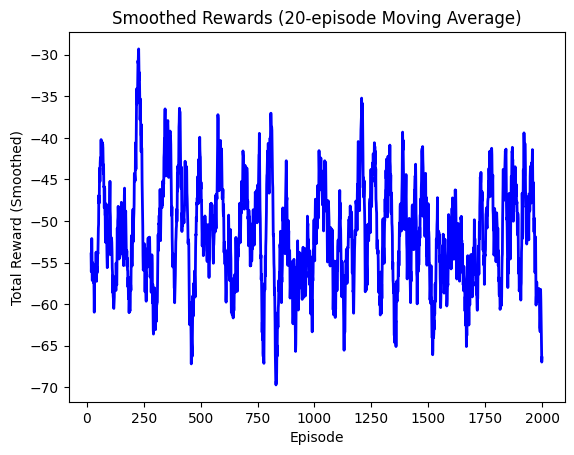

In [ ]:
import pandas as pd
plt.plot(pd.Series(newlr_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
print("Continuing training for 500 more episodes with DIFFERENT learning rate:")
newlr2_rewards = train_ppo(episodes=500)
rewards.extend(newlr2_rewards)
print("Training complete.")

Continuing training for 500 more episodes with DIFFERENT learning rate:
✅ Loaded 2000 previous rewards from 'reward_log.json'


  0%|          | 1/500 [00:04<38:55,  4.68s/it]

Episode 2001 | Total Reward: -97.61


  0%|          | 2/500 [00:07<27:52,  3.36s/it]

Episode 2002 | Total Reward: -55.53


  1%|          | 3/500 [00:09<23:25,  2.83s/it]

Episode 2003 | Total Reward: -50.70


  1%|          | 4/500 [00:15<33:34,  4.06s/it]

Episode 2004 | Total Reward: -90.95


  1%|          | 5/500 [00:20<37:10,  4.51s/it]

Episode 2005 | Total Reward: -74.35


  1%|          | 6/500 [00:24<34:08,  4.15s/it]

Episode 2006 | Total Reward: -81.34


  1%|▏         | 7/500 [00:27<32:54,  4.01s/it]

Episode 2007 | Total Reward: -71.77


  2%|▏         | 8/500 [00:28<24:48,  3.02s/it]

Episode 2008 | Total Reward: -21.08


  2%|▏         | 9/500 [00:31<23:39,  2.89s/it]

Episode 2009 | Total Reward: -59.91


  2%|▏         | 10/500 [00:34<23:43,  2.90s/it]

Episode 2010 | Total Reward: -68.26
💾 Progress saved — 2010 episodes complete


  2%|▏         | 11/500 [00:36<23:09,  2.84s/it]

Episode 2011 | Total Reward: -58.43


  2%|▏         | 12/500 [00:37<18:33,  2.28s/it]

Episode 2012 | Total Reward: -17.85


  3%|▎         | 13/500 [00:38<14:40,  1.81s/it]

Episode 2013 | Total Reward: -12.14


  3%|▎         | 14/500 [00:42<19:35,  2.42s/it]

Episode 2014 | Total Reward: -88.18


  3%|▎         | 15/500 [00:44<19:16,  2.38s/it]

Episode 2015 | Total Reward: -51.45


  3%|▎         | 16/500 [00:45<14:29,  1.80s/it]

Episode 2016 | Total Reward: -10.41


  3%|▎         | 17/500 [00:47<14:43,  1.83s/it]

Episode 2017 | Total Reward: -42.81


  4%|▎         | 18/500 [00:49<16:13,  2.02s/it]

Episode 2018 | Total Reward: -49.88


  4%|▍         | 19/500 [00:52<17:19,  2.16s/it]

Episode 2019 | Total Reward: -48.91


  4%|▍         | 20/500 [00:56<22:18,  2.79s/it]

Episode 2020 | Total Reward: -100.53
💾 Progress saved — 2020 episodes complete


  4%|▍         | 21/500 [01:02<30:38,  3.84s/it]

Episode 2021 | Total Reward: -93.06


  4%|▍         | 22/500 [01:07<32:45,  4.11s/it]

Episode 2022 | Total Reward: -84.34


  5%|▍         | 23/500 [01:09<27:04,  3.40s/it]

Episode 2023 | Total Reward: -40.21


  5%|▍         | 24/500 [01:09<20:14,  2.55s/it]

Episode 2024 | Total Reward: -14.06


  5%|▌         | 25/500 [01:14<24:48,  3.13s/it]

Episode 2025 | Total Reward: -101.42


  5%|▌         | 26/500 [01:16<23:52,  3.02s/it]

Episode 2026 | Total Reward: -50.33


  5%|▌         | 27/500 [01:17<18:38,  2.37s/it]

Episode 2027 | Total Reward: -9.80


  6%|▌         | 28/500 [01:19<17:59,  2.29s/it]

Episode 2028 | Total Reward: -46.50


  6%|▌         | 29/500 [01:23<20:49,  2.65s/it]

Episode 2029 | Total Reward: -82.17


  6%|▌         | 30/500 [01:27<23:26,  2.99s/it]

Episode 2030 | Total Reward: -57.45
💾 Progress saved — 2030 episodes complete


  6%|▌         | 31/500 [01:32<28:03,  3.59s/it]

Episode 2031 | Total Reward: -94.50


  6%|▋         | 32/500 [01:32<21:11,  2.72s/it]

Episode 2032 | Total Reward: -16.07


  7%|▋         | 33/500 [01:35<21:49,  2.81s/it]

Episode 2033 | Total Reward: -58.07


  7%|▋         | 34/500 [01:41<27:58,  3.60s/it]

Episode 2034 | Total Reward: -51.33


  7%|▋         | 35/500 [01:43<25:02,  3.23s/it]

Episode 2035 | Total Reward: -43.08


  7%|▋         | 36/500 [01:47<26:44,  3.46s/it]

Episode 2036 | Total Reward: -92.66


  7%|▋         | 37/500 [01:51<28:46,  3.73s/it]

Episode 2037 | Total Reward: -91.28


  8%|▊         | 38/500 [01:56<30:11,  3.92s/it]

Episode 2038 | Total Reward: -97.32


  8%|▊         | 39/500 [01:59<28:12,  3.67s/it]

Episode 2039 | Total Reward: -72.90


  8%|▊         | 40/500 [02:00<22:40,  2.96s/it]

Episode 2040 | Total Reward: -29.18
💾 Progress saved — 2040 episodes complete


  8%|▊         | 41/500 [02:02<19:16,  2.52s/it]

Episode 2041 | Total Reward: -35.65


  8%|▊         | 42/500 [02:06<23:50,  3.12s/it]

Episode 2042 | Total Reward: -92.57


  9%|▊         | 43/500 [02:10<26:15,  3.45s/it]

Episode 2043 | Total Reward: -98.97


  9%|▉         | 44/500 [02:14<26:48,  3.53s/it]

Episode 2044 | Total Reward: -87.16


  9%|▉         | 45/500 [02:16<23:46,  3.13s/it]

Episode 2045 | Total Reward: -36.60


  9%|▉         | 46/500 [02:18<19:30,  2.58s/it]

Episode 2046 | Total Reward: -28.83


  9%|▉         | 47/500 [02:18<14:52,  1.97s/it]

Episode 2047 | Total Reward: -13.55


 10%|▉         | 48/500 [02:21<17:47,  2.36s/it]

Episode 2048 | Total Reward: -76.44


 10%|▉         | 49/500 [02:22<13:23,  1.78s/it]

Episode 2049 | Total Reward: -10.41


 10%|█         | 51/500 [02:22<07:15,  1.03it/s]

Episode 2050 | Total Reward: -5.87
💾 Progress saved — 2050 episodes complete
Episode 2051 | Total Reward: -4.10


 10%|█         | 52/500 [02:26<13:04,  1.75s/it]

Episode 2052 | Total Reward: -83.51


 11%|█         | 53/500 [02:28<13:27,  1.81s/it]

Episode 2053 | Total Reward: -36.60


 11%|█         | 54/500 [02:30<13:39,  1.84s/it]

Episode 2054 | Total Reward: -37.93


 11%|█         | 55/500 [02:30<11:05,  1.50s/it]

Episode 2055 | Total Reward: -16.15


 11%|█         | 56/500 [02:33<14:02,  1.90s/it]

Episode 2056 | Total Reward: -63.58


 11%|█▏        | 57/500 [02:36<16:36,  2.25s/it]

Episode 2057 | Total Reward: -70.13


 12%|█▏        | 58/500 [02:39<18:35,  2.52s/it]

Episode 2058 | Total Reward: -67.46


 12%|█▏        | 59/500 [02:42<17:52,  2.43s/it]

Episode 2059 | Total Reward: -41.50


 12%|█▏        | 60/500 [02:43<14:51,  2.03s/it]

Episode 2060 | Total Reward: -24.39
💾 Progress saved — 2060 episodes complete


 12%|█▏        | 61/500 [02:46<17:59,  2.46s/it]

Episode 2061 | Total Reward: -77.55


 12%|█▏        | 62/500 [02:47<14:49,  2.03s/it]

Episode 2062 | Total Reward: -23.93


 13%|█▎        | 63/500 [02:49<14:36,  2.00s/it]

Episode 2063 | Total Reward: -44.04


 13%|█▎        | 64/500 [02:54<20:03,  2.76s/it]

Episode 2064 | Total Reward: -91.54


 13%|█▎        | 65/500 [02:57<21:11,  2.92s/it]

Episode 2065 | Total Reward: -74.35


 13%|█▎        | 66/500 [03:00<20:12,  2.79s/it]

Episode 2066 | Total Reward: -55.48


 13%|█▎        | 67/500 [03:03<20:56,  2.90s/it]

Episode 2067 | Total Reward: -73.04


 14%|█▎        | 68/500 [03:08<25:25,  3.53s/it]

Episode 2068 | Total Reward: -101.20


 14%|█▍        | 69/500 [03:10<22:00,  3.06s/it]

Episode 2069 | Total Reward: -44.25


 14%|█▍        | 70/500 [03:11<18:05,  2.53s/it]

Episode 2070 | Total Reward: -28.87
💾 Progress saved — 2070 episodes complete


 14%|█▍        | 71/500 [03:15<20:28,  2.86s/it]

Episode 2071 | Total Reward: -84.46


 14%|█▍        | 72/500 [03:16<17:13,  2.42s/it]

Episode 2072 | Total Reward: -26.00


 15%|█▍        | 73/500 [03:20<19:44,  2.77s/it]

Episode 2073 | Total Reward: -74.65


 15%|█▍        | 74/500 [03:23<20:14,  2.85s/it]

Episode 2074 | Total Reward: -70.61


 15%|█▌        | 75/500 [03:24<17:32,  2.48s/it]

Episode 2075 | Total Reward: -36.84


 15%|█▌        | 76/500 [03:28<20:48,  2.95s/it]

Episode 2076 | Total Reward: -89.54


 15%|█▌        | 77/500 [03:32<21:53,  3.11s/it]

Episode 2077 | Total Reward: -72.76


 16%|█▌        | 78/500 [03:34<20:09,  2.87s/it]

Episode 2078 | Total Reward: -52.02


 16%|█▌        | 79/500 [03:34<14:42,  2.10s/it]

Episode 2079 | Total Reward: -8.12


 16%|█▌        | 80/500 [03:38<17:52,  2.55s/it]

Episode 2080 | Total Reward: -84.63
💾 Progress saved — 2080 episodes complete


 16%|█▌        | 81/500 [03:41<17:58,  2.57s/it]

Episode 2081 | Total Reward: -51.55


 16%|█▋        | 82/500 [03:43<16:48,  2.41s/it]

Episode 2082 | Total Reward: -38.90


 17%|█▋        | 83/500 [03:44<15:34,  2.24s/it]

Episode 2083 | Total Reward: -41.02


 17%|█▋        | 84/500 [03:45<12:03,  1.74s/it]

Episode 2084 | Total Reward: -13.52


 17%|█▋        | 85/500 [03:46<11:26,  1.66s/it]

Episode 2085 | Total Reward: -33.17


 17%|█▋        | 86/500 [03:47<09:22,  1.36s/it]

Episode 2086 | Total Reward: -15.68


 17%|█▋        | 87/500 [03:49<11:23,  1.65s/it]

Episode 2087 | Total Reward: -52.61


 18%|█▊        | 88/500 [03:51<11:45,  1.71s/it]

Episode 2088 | Total Reward: -42.50


 18%|█▊        | 89/500 [03:55<14:48,  2.16s/it]

Episode 2089 | Total Reward: -58.91


 18%|█▊        | 90/500 [03:58<17:32,  2.57s/it]

Episode 2090 | Total Reward: -80.77
💾 Progress saved — 2090 episodes complete


 18%|█▊        | 91/500 [03:59<14:39,  2.15s/it]

Episode 2091 | Total Reward: -26.79


 18%|█▊        | 92/500 [04:01<13:03,  1.92s/it]

Episode 2092 | Total Reward: -30.47


 19%|█▊        | 93/500 [04:05<17:08,  2.53s/it]

Episode 2093 | Total Reward: -85.62


 19%|█▉        | 94/500 [04:05<13:37,  2.01s/it]

Episode 2094 | Total Reward: -13.90


 19%|█▉        | 95/500 [04:08<15:42,  2.33s/it]

Episode 2095 | Total Reward: -64.80


 19%|█▉        | 96/500 [04:10<14:10,  2.11s/it]

Episode 2096 | Total Reward: -37.10


 19%|█▉        | 97/500 [04:11<12:07,  1.81s/it]

Episode 2097 | Total Reward: -25.60


 20%|█▉        | 98/500 [04:14<13:44,  2.05s/it]

Episode 2098 | Total Reward: -62.04


 20%|█▉        | 99/500 [04:16<14:56,  2.24s/it]

Episode 2099 | Total Reward: -57.97


 20%|██        | 100/500 [04:20<18:20,  2.75s/it]

Episode 2100 | Total Reward: -81.34
💾 Progress saved — 2100 episodes complete


 20%|██        | 101/500 [04:24<19:11,  2.89s/it]

Episode 2101 | Total Reward: -75.47


 20%|██        | 102/500 [04:27<20:15,  3.05s/it]

Episode 2102 | Total Reward: -80.66


 21%|██        | 103/500 [04:29<17:31,  2.65s/it]

Episode 2103 | Total Reward: -35.12


 21%|██        | 104/500 [04:29<12:44,  1.93s/it]

Episode 2104 | Total Reward: -4.95


 21%|██        | 105/500 [04:33<16:22,  2.49s/it]

Episode 2105 | Total Reward: -78.65


 21%|██        | 106/500 [04:34<14:47,  2.25s/it]

Episode 2106 | Total Reward: -39.49


 21%|██▏       | 107/500 [04:37<16:14,  2.48s/it]

Episode 2107 | Total Reward: -70.29


 22%|██▏       | 108/500 [04:38<12:12,  1.87s/it]

Episode 2108 | Total Reward: -10.63


 22%|██▏       | 109/500 [04:41<15:26,  2.37s/it]

Episode 2109 | Total Reward: -75.47


 22%|██▏       | 110/500 [04:45<18:13,  2.80s/it]

Episode 2110 | Total Reward: -81.65
💾 Progress saved — 2110 episodes complete


 22%|██▏       | 111/500 [04:49<19:08,  2.95s/it]

Episode 2111 | Total Reward: -76.68


 22%|██▏       | 112/500 [04:50<15:08,  2.34s/it]

Episode 2112 | Total Reward: -21.08


 23%|██▎       | 113/500 [04:53<16:46,  2.60s/it]

Episode 2113 | Total Reward: -74.17


 23%|██▎       | 114/500 [04:56<18:20,  2.85s/it]

Episode 2114 | Total Reward: -69.21


 23%|██▎       | 115/500 [04:58<15:43,  2.45s/it]

Episode 2115 | Total Reward: -35.25


 23%|██▎       | 116/500 [05:01<17:47,  2.78s/it]

Episode 2116 | Total Reward: -82.61


 23%|██▎       | 117/500 [05:02<14:45,  2.31s/it]

Episode 2117 | Total Reward: -28.21


 24%|██▎       | 118/500 [05:05<15:04,  2.37s/it]

Episode 2118 | Total Reward: -55.09


 24%|██▍       | 119/500 [05:09<17:48,  2.81s/it]

Episode 2119 | Total Reward: -76.73


 24%|██▍       | 120/500 [05:10<14:53,  2.35s/it]

Episode 2120 | Total Reward: -29.57
💾 Progress saved — 2120 episodes complete


 24%|██▍       | 121/500 [05:11<11:21,  1.80s/it]

Episode 2121 | Total Reward: -12.00


 24%|██▍       | 122/500 [05:13<12:43,  2.02s/it]

Episode 2122 | Total Reward: -58.88


 25%|██▍       | 123/500 [05:16<13:45,  2.19s/it]

Episode 2123 | Total Reward: -58.07


 25%|██▍       | 124/500 [05:17<12:09,  1.94s/it]

Episode 2124 | Total Reward: -29.19


 25%|██▌       | 125/500 [05:19<11:18,  1.81s/it]

Episode 2125 | Total Reward: -26.07


 25%|██▌       | 126/500 [05:23<15:21,  2.47s/it]

Episode 2126 | Total Reward: -91.18


 25%|██▌       | 127/500 [05:26<17:13,  2.77s/it]

Episode 2127 | Total Reward: -82.10


 26%|██▌       | 128/500 [05:30<19:57,  3.22s/it]

Episode 2128 | Total Reward: -89.90


 26%|██▌       | 129/500 [05:31<15:28,  2.50s/it]

Episode 2129 | Total Reward: -14.20


 26%|██▌       | 130/500 [05:32<12:09,  1.97s/it]

Episode 2130 | Total Reward: -17.40
💾 Progress saved — 2130 episodes complete


 26%|██▌       | 131/500 [05:36<16:36,  2.70s/it]

Episode 2131 | Total Reward: -101.69


 26%|██▋       | 132/500 [05:40<17:50,  2.91s/it]

Episode 2132 | Total Reward: -77.89


 27%|██▋       | 133/500 [05:44<21:16,  3.48s/it]

Episode 2133 | Total Reward: -96.99


 27%|██▋       | 134/500 [05:46<17:24,  2.86s/it]

Episode 2134 | Total Reward: -31.81


 27%|██▋       | 135/500 [05:48<16:49,  2.77s/it]

Episode 2135 | Total Reward: -57.36


 27%|██▋       | 136/500 [05:53<19:32,  3.22s/it]

Episode 2136 | Total Reward: -100.98


 27%|██▋       | 137/500 [05:56<19:27,  3.22s/it]

Episode 2137 | Total Reward: -60.36


 28%|██▊       | 138/500 [05:56<14:00,  2.32s/it]

Episode 2138 | Total Reward: -5.57


 28%|██▊       | 139/500 [05:59<14:04,  2.34s/it]

Episode 2139 | Total Reward: -54.07


 28%|██▊       | 140/500 [06:03<17:07,  2.86s/it]

Episode 2140 | Total Reward: -93.36
💾 Progress saved — 2140 episodes complete


 28%|██▊       | 141/500 [06:04<14:58,  2.50s/it]

Episode 2141 | Total Reward: -38.68


 28%|██▊       | 142/500 [06:09<19:11,  3.22s/it]

Episode 2142 | Total Reward: -100.86


 29%|██▊       | 143/500 [06:13<20:15,  3.40s/it]

Episode 2143 | Total Reward: -89.84


 29%|██▉       | 144/500 [06:17<21:34,  3.64s/it]

Episode 2144 | Total Reward: -98.12


 29%|██▉       | 145/500 [06:22<23:36,  3.99s/it]

Episode 2145 | Total Reward: -99.25


 29%|██▉       | 146/500 [06:25<21:15,  3.60s/it]

Episode 2146 | Total Reward: -61.97


 29%|██▉       | 147/500 [06:26<16:59,  2.89s/it]

Episode 2147 | Total Reward: -28.32


 30%|██▉       | 148/500 [06:30<19:33,  3.33s/it]

Episode 2148 | Total Reward: -98.84


 30%|██▉       | 149/500 [06:35<21:49,  3.73s/it]

Episode 2149 | Total Reward: -101.20


 30%|███       | 150/500 [06:39<21:41,  3.72s/it]

Episode 2150 | Total Reward: -87.19
💾 Progress saved — 2150 episodes complete


 30%|███       | 151/500 [06:39<16:34,  2.85s/it]

Episode 2151 | Total Reward: -19.71


 30%|███       | 152/500 [06:41<14:07,  2.44s/it]

Episode 2152 | Total Reward: -33.80


 31%|███       | 153/500 [06:42<11:04,  1.91s/it]

Episode 2153 | Total Reward: -16.60


 31%|███       | 154/500 [06:44<11:23,  1.98s/it]

Episode 2154 | Total Reward: -35.12


 31%|███       | 155/500 [06:45<10:40,  1.86s/it]

Episode 2155 | Total Reward: -35.82


 31%|███▏      | 157/500 [06:49<09:56,  1.74s/it]

Episode 2156 | Total Reward: -82.97
Episode 2157 | Total Reward: -4.95


 32%|███▏      | 158/500 [06:50<07:58,  1.40s/it]

Episode 2158 | Total Reward: -14.37


 32%|███▏      | 159/500 [06:54<12:36,  2.22s/it]

Episode 2159 | Total Reward: -95.92


 32%|███▏      | 160/500 [06:57<14:11,  2.50s/it]

Episode 2160 | Total Reward: -60.24
💾 Progress saved — 2160 episodes complete


 32%|███▏      | 161/500 [07:00<15:00,  2.66s/it]

Episode 2161 | Total Reward: -69.37


 32%|███▏      | 162/500 [07:01<11:33,  2.05s/it]

Episode 2162 | Total Reward: -14.36


 33%|███▎      | 163/500 [07:03<11:27,  2.04s/it]

Episode 2163 | Total Reward: -46.20


 33%|███▎      | 164/500 [07:06<14:09,  2.53s/it]

Episode 2164 | Total Reward: -82.61


 33%|███▎      | 165/500 [07:11<17:10,  3.08s/it]

Episode 2165 | Total Reward: -91.27


 33%|███▎      | 166/500 [07:11<12:49,  2.30s/it]

Episode 2166 | Total Reward: -12.05


 33%|███▎      | 167/500 [07:15<14:56,  2.69s/it]

Episode 2167 | Total Reward: -82.22


 34%|███▎      | 168/500 [07:18<15:42,  2.84s/it]

Episode 2168 | Total Reward: -72.60


 34%|███▍      | 169/500 [07:23<19:06,  3.46s/it]

Episode 2169 | Total Reward: -99.74


 34%|███▍      | 170/500 [07:26<18:45,  3.41s/it]

Episode 2170 | Total Reward: -74.70
💾 Progress saved — 2170 episodes complete


 34%|███▍      | 171/500 [07:28<15:33,  2.84s/it]

Episode 2171 | Total Reward: -32.88


 34%|███▍      | 172/500 [07:28<11:25,  2.09s/it]

Episode 2172 | Total Reward: -9.20


 35%|███▍      | 173/500 [07:30<11:07,  2.04s/it]

Episode 2173 | Total Reward: -44.04


 35%|███▍      | 174/500 [07:34<13:33,  2.49s/it]

Episode 2174 | Total Reward: -67.44


 35%|███▌      | 175/500 [07:36<13:44,  2.54s/it]

Episode 2175 | Total Reward: -59.23


 35%|███▌      | 176/500 [07:37<11:08,  2.06s/it]

Episode 2176 | Total Reward: -21.95


 35%|███▌      | 177/500 [07:37<08:08,  1.51s/it]

Episode 2177 | Total Reward: -5.77


 36%|███▌      | 178/500 [07:41<11:21,  2.12s/it]

Episode 2178 | Total Reward: -83.36


 36%|███▌      | 179/500 [07:42<09:28,  1.77s/it]

Episode 2179 | Total Reward: -21.63


 36%|███▌      | 180/500 [07:42<07:22,  1.38s/it]

Episode 2180 | Total Reward: -11.23
💾 Progress saved — 2180 episodes complete


 36%|███▌      | 181/500 [07:43<06:53,  1.30s/it]

Episode 2181 | Total Reward: -18.66


 36%|███▋      | 182/500 [07:47<10:59,  2.07s/it]

Episode 2182 | Total Reward: -80.84


 37%|███▋      | 183/500 [07:51<13:55,  2.63s/it]

Episode 2183 | Total Reward: -90.98


 37%|███▋      | 184/500 [07:55<15:44,  2.99s/it]

Episode 2184 | Total Reward: -84.63


 37%|███▋      | 185/500 [07:58<15:38,  2.98s/it]

Episode 2185 | Total Reward: -58.49


 37%|███▋      | 186/500 [08:01<14:52,  2.84s/it]

Episode 2186 | Total Reward: -59.60


 37%|███▋      | 187/500 [08:03<14:16,  2.74s/it]

Episode 2187 | Total Reward: -56.56


 38%|███▊      | 188/500 [08:06<14:41,  2.82s/it]

Episode 2188 | Total Reward: -71.48


 38%|███▊      | 189/500 [08:09<14:51,  2.87s/it]

Episode 2189 | Total Reward: -52.24


 38%|███▊      | 190/500 [08:10<11:31,  2.23s/it]

Episode 2190 | Total Reward: -17.55
💾 Progress saved — 2190 episodes complete


 38%|███▊      | 191/500 [08:14<14:00,  2.72s/it]

Episode 2191 | Total Reward: -89.73


 38%|███▊      | 192/500 [08:16<13:55,  2.71s/it]

Episode 2192 | Total Reward: -62.24


 39%|███▊      | 193/500 [08:20<15:23,  3.01s/it]

Episode 2193 | Total Reward: -77.89


 39%|███▉      | 194/500 [08:23<15:35,  3.06s/it]

Episode 2194 | Total Reward: -65.70


 39%|███▉      | 195/500 [08:27<17:09,  3.38s/it]

Episode 2195 | Total Reward: -96.17


 39%|███▉      | 196/500 [08:28<12:25,  2.45s/it]

Episode 2196 | Total Reward: -7.52


 39%|███▉      | 197/500 [08:32<15:10,  3.00s/it]

Episode 2197 | Total Reward: -93.13


 40%|███▉      | 198/500 [08:34<14:24,  2.86s/it]

Episode 2198 | Total Reward: -49.38


 40%|███▉      | 199/500 [08:38<14:59,  2.99s/it]

Episode 2199 | Total Reward: -76.88


 40%|████      | 200/500 [08:39<12:55,  2.59s/it]

Episode 2200 | Total Reward: -37.37
💾 Progress saved — 2200 episodes complete


 40%|████      | 201/500 [08:40<10:35,  2.12s/it]

Episode 2201 | Total Reward: -24.39


 40%|████      | 202/500 [08:42<09:31,  1.92s/it]

Episode 2202 | Total Reward: -32.73


 41%|████      | 203/500 [08:45<10:32,  2.13s/it]

Episode 2203 | Total Reward: -50.70


 41%|████      | 204/500 [08:47<10:17,  2.09s/it]

Episode 2204 | Total Reward: -39.77


 41%|████      | 205/500 [08:49<10:23,  2.11s/it]

Episode 2205 | Total Reward: -48.63


 41%|████      | 206/500 [08:50<09:47,  2.00s/it]

Episode 2206 | Total Reward: -40.19


 41%|████▏     | 207/500 [08:52<09:23,  1.92s/it]

Episode 2207 | Total Reward: -39.83


 42%|████▏     | 208/500 [08:56<12:23,  2.55s/it]

Episode 2208 | Total Reward: -88.11


 42%|████▏     | 209/500 [09:00<14:36,  3.01s/it]

Episode 2209 | Total Reward: -87.29


 42%|████▏     | 210/500 [09:04<16:16,  3.37s/it]

Episode 2210 | Total Reward: -98.84
💾 Progress saved — 2210 episodes complete


 42%|████▏     | 211/500 [09:08<16:11,  3.36s/it]

Episode 2211 | Total Reward: -75.93


 42%|████▏     | 212/500 [09:09<13:21,  2.78s/it]

Episode 2212 | Total Reward: -24.83


 43%|████▎     | 213/500 [09:13<14:35,  3.05s/it]

Episode 2213 | Total Reward: -83.75


 43%|████▎     | 214/500 [09:14<11:43,  2.46s/it]

Episode 2214 | Total Reward: -25.72


 43%|████▎     | 215/500 [09:16<10:30,  2.21s/it]

Episode 2215 | Total Reward: -37.77


 43%|████▎     | 216/500 [09:17<09:06,  1.92s/it]

Episode 2216 | Total Reward: -28.83


 43%|████▎     | 217/500 [09:20<10:29,  2.22s/it]

Episode 2217 | Total Reward: -65.84


 44%|████▎     | 218/500 [09:22<10:42,  2.28s/it]

Episode 2218 | Total Reward: -43.82


 44%|████▍     | 219/500 [09:24<10:11,  2.18s/it]

Episode 2219 | Total Reward: -44.25


 44%|████▍     | 220/500 [09:27<11:40,  2.50s/it]

Episode 2220 | Total Reward: -76.68
💾 Progress saved — 2220 episodes complete


 44%|████▍     | 221/500 [09:32<14:02,  3.02s/it]

Episode 2221 | Total Reward: -98.69


 44%|████▍     | 222/500 [09:35<13:53,  3.00s/it]

Episode 2222 | Total Reward: -52.48


 45%|████▍     | 223/500 [09:35<10:23,  2.25s/it]

Episode 2223 | Total Reward: -12.00


 45%|████▍     | 224/500 [09:38<11:47,  2.56s/it]

Episode 2224 | Total Reward: -76.01


 45%|████▌     | 225/500 [09:39<08:38,  1.88s/it]

Episode 2225 | Total Reward: -7.72


 45%|████▌     | 226/500 [09:43<11:42,  2.57s/it]

Episode 2226 | Total Reward: -98.12


 45%|████▌     | 227/500 [09:43<09:00,  1.98s/it]

Episode 2227 | Total Reward: -14.83


 46%|████▌     | 228/500 [09:45<08:25,  1.86s/it]

Episode 2228 | Total Reward: -28.28


 46%|████▌     | 229/500 [09:48<09:57,  2.21s/it]

Episode 2229 | Total Reward: -61.97


 46%|████▌     | 230/500 [09:51<11:04,  2.46s/it]

Episode 2230 | Total Reward: -70.46
💾 Progress saved — 2230 episodes complete


 46%|████▌     | 231/500 [09:52<09:34,  2.14s/it]

Episode 2231 | Total Reward: -31.89


 46%|████▋     | 232/500 [09:57<12:05,  2.71s/it]

Episode 2232 | Total Reward: -91.07


 47%|████▋     | 233/500 [09:58<10:53,  2.45s/it]

Episode 2233 | Total Reward: -32.20


 47%|████▋     | 234/500 [10:02<11:56,  2.69s/it]

Episode 2234 | Total Reward: -75.13


 47%|████▋     | 235/500 [10:04<11:06,  2.52s/it]

Episode 2235 | Total Reward: -46.95


 47%|████▋     | 236/500 [10:07<11:42,  2.66s/it]

Episode 2236 | Total Reward: -67.42


 47%|████▋     | 237/500 [10:12<14:37,  3.34s/it]

Episode 2237 | Total Reward: -100.06


 48%|████▊     | 238/500 [10:15<15:00,  3.44s/it]

Episode 2238 | Total Reward: -83.66


 48%|████▊     | 239/500 [10:16<11:59,  2.76s/it]

Episode 2239 | Total Reward: -27.13


 48%|████▊     | 240/500 [10:19<12:13,  2.82s/it]

Episode 2240 | Total Reward: -69.33
💾 Progress saved — 2240 episodes complete


 48%|████▊     | 241/500 [10:23<12:57,  3.00s/it]

Episode 2241 | Total Reward: -65.87


 48%|████▊     | 242/500 [10:25<12:10,  2.83s/it]

Episode 2242 | Total Reward: -54.62


 49%|████▊     | 243/500 [10:26<08:49,  2.06s/it]

Episode 2243 | Total Reward: -6.47


 49%|████▉     | 244/500 [10:27<07:31,  1.76s/it]

Episode 2244 | Total Reward: -25.22


 49%|████▉     | 245/500 [10:29<07:54,  1.86s/it]

Episode 2245 | Total Reward: -46.74


 49%|████▉     | 246/500 [10:29<06:08,  1.45s/it]

Episode 2246 | Total Reward: -12.00


 49%|████▉     | 247/500 [10:31<06:31,  1.55s/it]

Episode 2247 | Total Reward: -40.74


 50%|████▉     | 248/500 [10:35<09:52,  2.35s/it]

Episode 2248 | Total Reward: -83.07


 50%|████▉     | 249/500 [10:36<07:52,  1.88s/it]

Episode 2249 | Total Reward: -17.78


 50%|█████     | 250/500 [10:36<05:47,  1.39s/it]

Episode 2250 | Total Reward: -5.95
💾 Progress saved — 2250 episodes complete


 50%|█████     | 251/500 [10:37<05:27,  1.31s/it]

Episode 2251 | Total Reward: -26.42


 50%|█████     | 252/500 [10:38<04:43,  1.14s/it]

Episode 2252 | Total Reward: -17.53


 51%|█████     | 253/500 [10:39<03:50,  1.07it/s]

Episode 2253 | Total Reward: -11.01


 51%|█████     | 254/500 [10:41<05:27,  1.33s/it]

Episode 2254 | Total Reward: -50.75


 51%|█████     | 255/500 [10:43<06:08,  1.50s/it]

Episode 2255 | Total Reward: -42.86


 51%|█████     | 256/500 [10:46<07:55,  1.95s/it]

Episode 2256 | Total Reward: -59.96


 51%|█████▏    | 257/500 [10:49<09:07,  2.25s/it]

Episode 2257 | Total Reward: -62.24


 52%|█████▏    | 258/500 [10:52<09:55,  2.46s/it]

Episode 2258 | Total Reward: -68.24


 52%|█████▏    | 259/500 [10:55<11:03,  2.75s/it]

Episode 2259 | Total Reward: -80.09


 52%|█████▏    | 260/500 [10:56<09:09,  2.29s/it]

Episode 2260 | Total Reward: -28.12
💾 Progress saved — 2260 episodes complete


 52%|█████▏    | 261/500 [11:00<11:04,  2.78s/it]

Episode 2261 | Total Reward: -78.06


 52%|█████▏    | 262/500 [11:04<12:32,  3.16s/it]

Episode 2262 | Total Reward: -94.94


 53%|█████▎    | 263/500 [11:06<10:51,  2.75s/it]

Episode 2263 | Total Reward: -41.48


 53%|█████▎    | 264/500 [11:10<12:44,  3.24s/it]

Episode 2264 | Total Reward: -91.14


 53%|█████▎    | 265/500 [11:14<13:35,  3.47s/it]

Episode 2265 | Total Reward: -88.58


 53%|█████▎    | 266/500 [11:15<10:09,  2.60s/it]

Episode 2266 | Total Reward: -14.25


 53%|█████▎    | 267/500 [11:16<08:37,  2.22s/it]

Episode 2267 | Total Reward: -30.75


 54%|█████▎    | 268/500 [11:17<06:19,  1.64s/it]

Episode 2268 | Total Reward: -6.85


 54%|█████▍    | 269/500 [11:19<07:18,  1.90s/it]

Episode 2269 | Total Reward: -57.08


 54%|█████▍    | 270/500 [11:24<10:40,  2.78s/it]

Episode 2270 | Total Reward: -97.42
💾 Progress saved — 2270 episodes complete


 54%|█████▍    | 271/500 [11:24<07:44,  2.03s/it]

Episode 2271 | Total Reward: -6.83


 54%|█████▍    | 272/500 [11:25<06:23,  1.68s/it]

Episode 2272 | Total Reward: -20.08


 55%|█████▍    | 273/500 [11:28<07:46,  2.06s/it]

Episode 2273 | Total Reward: -67.13


 55%|█████▍    | 274/500 [11:31<08:22,  2.22s/it]

Episode 2274 | Total Reward: -59.79


 55%|█████▌    | 275/500 [11:32<07:24,  1.97s/it]

Episode 2275 | Total Reward: -29.69


 55%|█████▌    | 276/500 [11:34<07:01,  1.88s/it]

Episode 2276 | Total Reward: -31.96


 55%|█████▌    | 277/500 [11:37<08:00,  2.15s/it]

Episode 2277 | Total Reward: -51.83


 56%|█████▌    | 278/500 [11:40<09:46,  2.64s/it]

Episode 2278 | Total Reward: -86.52


 56%|█████▌    | 279/500 [11:43<09:30,  2.58s/it]

Episode 2279 | Total Reward: -53.40


 56%|█████▌    | 280/500 [11:44<07:40,  2.09s/it]

Episode 2280 | Total Reward: -20.99
💾 Progress saved — 2280 episodes complete


 56%|█████▌    | 281/500 [11:47<09:09,  2.51s/it]

Episode 2281 | Total Reward: -65.95


 56%|█████▋    | 282/500 [11:48<07:00,  1.93s/it]

Episode 2282 | Total Reward: -9.69


 57%|█████▋    | 283/500 [11:51<08:09,  2.25s/it]

Episode 2283 | Total Reward: -67.44


 57%|█████▋    | 284/500 [11:55<09:47,  2.72s/it]

Episode 2284 | Total Reward: -87.84


 57%|█████▋    | 285/500 [11:56<08:43,  2.43s/it]

Episode 2285 | Total Reward: -40.21


 57%|█████▋    | 286/500 [11:57<07:01,  1.97s/it]

Episode 2286 | Total Reward: -20.33


 57%|█████▋    | 287/500 [12:00<08:16,  2.33s/it]

Episode 2287 | Total Reward: -58.32


 58%|█████▊    | 288/500 [12:04<09:30,  2.69s/it]

Episode 2288 | Total Reward: -82.17


 58%|█████▊    | 289/500 [12:05<07:59,  2.27s/it]

Episode 2289 | Total Reward: -29.81


 58%|█████▊    | 290/500 [12:06<06:29,  1.86s/it]

Episode 2290 | Total Reward: -20.35
💾 Progress saved — 2290 episodes complete


 58%|█████▊    | 291/500 [12:10<08:24,  2.41s/it]

Episode 2291 | Total Reward: -86.63


 58%|█████▊    | 292/500 [12:13<09:19,  2.69s/it]

Episode 2292 | Total Reward: -61.54


 59%|█████▊    | 293/500 [12:17<10:51,  3.15s/it]

Episode 2293 | Total Reward: -96.64


 59%|█████▉    | 294/500 [12:18<08:27,  2.46s/it]

Episode 2294 | Total Reward: -19.26


 59%|█████▉    | 295/500 [12:21<08:30,  2.49s/it]

Episode 2295 | Total Reward: -57.45


 59%|█████▉    | 296/500 [12:23<08:35,  2.53s/it]

Episode 2296 | Total Reward: -50.48


 59%|█████▉    | 297/500 [12:26<08:46,  2.60s/it]

Episode 2297 | Total Reward: -57.40


 60%|█████▉    | 298/500 [12:29<09:08,  2.71s/it]

Episode 2298 | Total Reward: -70.36


 60%|█████▉    | 299/500 [12:30<06:50,  2.04s/it]

Episode 2299 | Total Reward: -11.70


 60%|██████    | 300/500 [12:31<06:17,  1.89s/it]

Episode 2300 | Total Reward: -35.41
💾 Progress saved — 2300 episodes complete


 60%|██████    | 301/500 [12:32<05:34,  1.68s/it]

Episode 2301 | Total Reward: -26.66


 60%|██████    | 302/500 [12:33<04:26,  1.34s/it]

Episode 2302 | Total Reward: -13.55


 61%|██████    | 303/500 [12:33<03:24,  1.04s/it]

Episode 2303 | Total Reward: -8.12


 61%|██████    | 304/500 [12:37<06:33,  2.01s/it]

Episode 2304 | Total Reward: -84.77


 61%|██████    | 305/500 [12:40<06:46,  2.09s/it]

Episode 2305 | Total Reward: -49.78


 61%|██████    | 306/500 [12:40<05:26,  1.68s/it]

Episode 2306 | Total Reward: -17.04


 61%|██████▏   | 307/500 [12:42<04:52,  1.52s/it]

Episode 2307 | Total Reward: -25.80


 62%|██████▏   | 308/500 [12:45<06:50,  2.14s/it]

Episode 2308 | Total Reward: -81.17


 62%|██████▏   | 309/500 [12:46<05:27,  1.72s/it]

Episode 2309 | Total Reward: -17.05


 62%|██████▏   | 310/500 [12:51<08:17,  2.62s/it]

Episode 2310 | Total Reward: -93.51
💾 Progress saved — 2310 episodes complete


 62%|██████▏   | 311/500 [12:54<09:01,  2.87s/it]

Episode 2311 | Total Reward: -79.64


 62%|██████▏   | 312/500 [12:58<10:12,  3.26s/it]

Episode 2312 | Total Reward: -94.34


 63%|██████▎   | 313/500 [12:59<07:32,  2.42s/it]

Episode 2313 | Total Reward: -8.73


 63%|██████▎   | 314/500 [13:04<09:51,  3.18s/it]

Episode 2314 | Total Reward: -99.41


 63%|██████▎   | 315/500 [13:05<08:20,  2.70s/it]

Episode 2315 | Total Reward: -36.72


 63%|██████▎   | 316/500 [13:08<08:24,  2.74s/it]

Episode 2316 | Total Reward: -65.70


 63%|██████▎   | 317/500 [13:10<07:59,  2.62s/it]

Episode 2317 | Total Reward: -52.56


 64%|██████▎   | 318/500 [13:13<07:43,  2.54s/it]

Episode 2318 | Total Reward: -40.08


 64%|██████▍   | 319/500 [13:16<08:26,  2.80s/it]

Episode 2319 | Total Reward: -77.55


 64%|██████▍   | 320/500 [13:19<08:26,  2.81s/it]

Episode 2320 | Total Reward: -63.47
💾 Progress saved — 2320 episodes complete


 64%|██████▍   | 321/500 [13:22<08:12,  2.75s/it]

Episode 2321 | Total Reward: -59.60


 64%|██████▍   | 322/500 [13:26<09:33,  3.22s/it]

Episode 2322 | Total Reward: -84.65


 65%|██████▍   | 323/500 [13:29<09:42,  3.29s/it]

Episode 2323 | Total Reward: -79.42


 65%|██████▍   | 324/500 [13:31<08:21,  2.85s/it]

Episode 2324 | Total Reward: -42.07


 65%|██████▌   | 325/500 [13:34<08:28,  2.90s/it]

Episode 2325 | Total Reward: -69.01


 65%|██████▌   | 326/500 [13:36<07:43,  2.66s/it]

Episode 2326 | Total Reward: -40.39


 65%|██████▌   | 327/500 [13:37<06:16,  2.17s/it]

Episode 2327 | Total Reward: -18.09


 66%|██████▌   | 328/500 [13:40<06:31,  2.28s/it]

Episode 2328 | Total Reward: -57.36


 66%|██████▌   | 329/500 [13:42<06:36,  2.32s/it]

Episode 2329 | Total Reward: -54.73


 66%|██████▌   | 330/500 [13:45<06:54,  2.44s/it]

Episode 2330 | Total Reward: -62.02
💾 Progress saved — 2330 episodes complete


 66%|██████▌   | 331/500 [13:50<08:50,  3.14s/it]

Episode 2331 | Total Reward: -95.69


 66%|██████▋   | 332/500 [13:52<07:58,  2.85s/it]

Episode 2332 | Total Reward: -48.91


 67%|██████▋   | 333/500 [13:52<05:52,  2.11s/it]

Episode 2333 | Total Reward: -9.69


 67%|██████▋   | 334/500 [13:55<06:28,  2.34s/it]

Episode 2334 | Total Reward: -65.75


 67%|██████▋   | 335/500 [13:58<06:38,  2.41s/it]

Episode 2335 | Total Reward: -59.10


 67%|██████▋   | 336/500 [14:00<06:19,  2.31s/it]

Episode 2336 | Total Reward: -45.10


 67%|██████▋   | 337/500 [14:01<04:55,  1.82s/it]

Episode 2337 | Total Reward: -12.05


 68%|██████▊   | 338/500 [14:02<04:54,  1.82s/it]

Episode 2338 | Total Reward: -34.54


 68%|██████▊   | 339/500 [14:03<03:40,  1.37s/it]

Episode 2339 | Total Reward: -7.59


 68%|██████▊   | 340/500 [14:05<04:31,  1.69s/it]

Episode 2340 | Total Reward: -55.29
💾 Progress saved — 2340 episodes complete


 68%|██████▊   | 341/500 [14:06<03:37,  1.37s/it]

Episode 2341 | Total Reward: -14.83


 68%|██████▊   | 342/500 [14:06<03:03,  1.16s/it]

Episode 2342 | Total Reward: -15.54


 69%|██████▊   | 343/500 [14:07<02:42,  1.04s/it]

Episode 2343 | Total Reward: -17.19


 69%|██████▉   | 344/500 [14:11<04:43,  1.81s/it]

Episode 2344 | Total Reward: -84.63


 69%|██████▉   | 345/500 [14:15<06:26,  2.49s/it]

Episode 2345 | Total Reward: -78.96


 69%|██████▉   | 346/500 [14:18<06:59,  2.72s/it]

Episode 2346 | Total Reward: -75.20


 69%|██████▉   | 347/500 [14:22<07:45,  3.04s/it]

Episode 2347 | Total Reward: -87.89


 70%|██████▉   | 348/500 [14:23<06:31,  2.58s/it]

Episode 2348 | Total Reward: -34.54


 70%|██████▉   | 349/500 [14:28<07:50,  3.12s/it]

Episode 2349 | Total Reward: -87.14


 70%|███████   | 350/500 [14:30<06:55,  2.77s/it]

Episode 2350 | Total Reward: -44.69
💾 Progress saved — 2350 episodes complete


 70%|███████   | 351/500 [14:32<06:04,  2.45s/it]

Episode 2351 | Total Reward: -38.99


 70%|███████   | 352/500 [14:33<05:38,  2.29s/it]

Episode 2352 | Total Reward: -43.04


 71%|███████   | 353/500 [14:36<05:36,  2.29s/it]

Episode 2353 | Total Reward: -51.69


 71%|███████   | 354/500 [14:36<04:17,  1.76s/it]

Episode 2354 | Total Reward: -10.79


 71%|███████   | 355/500 [14:37<03:43,  1.54s/it]

Episode 2355 | Total Reward: -18.05


 71%|███████   | 356/500 [14:40<04:40,  1.95s/it]

Episode 2356 | Total Reward: -58.74


 71%|███████▏  | 357/500 [14:41<03:44,  1.57s/it]

Episode 2357 | Total Reward: -16.07


 72%|███████▏  | 358/500 [14:45<05:33,  2.35s/it]

Episode 2358 | Total Reward: -96.55


 72%|███████▏  | 359/500 [14:48<05:40,  2.42s/it]

Episode 2359 | Total Reward: -58.74


 72%|███████▏  | 360/500 [14:52<07:16,  3.11s/it]

Episode 2360 | Total Reward: -95.47
💾 Progress saved — 2360 episodes complete


 72%|███████▏  | 361/500 [14:53<05:29,  2.37s/it]

Episode 2361 | Total Reward: -14.23


 72%|███████▏  | 362/500 [14:55<05:19,  2.32s/it]

Episode 2362 | Total Reward: -49.48


 73%|███████▎  | 363/500 [14:57<05:09,  2.26s/it]

Episode 2363 | Total Reward: -49.11


 73%|███████▎  | 364/500 [14:58<04:15,  1.88s/it]

Episode 2364 | Total Reward: -22.48


 73%|███████▎  | 365/500 [14:59<03:24,  1.51s/it]

Episode 2365 | Total Reward: -15.82


 73%|███████▎  | 366/500 [15:02<04:24,  1.98s/it]

Episode 2366 | Total Reward: -59.60


 73%|███████▎  | 367/500 [15:05<04:55,  2.22s/it]

Episode 2367 | Total Reward: -59.31


 74%|███████▎  | 368/500 [15:09<06:02,  2.74s/it]

Episode 2368 | Total Reward: -92.48


 74%|███████▍  | 369/500 [15:10<04:59,  2.29s/it]

Episode 2369 | Total Reward: -27.64


 74%|███████▍  | 370/500 [15:15<06:36,  3.05s/it]

Episode 2370 | Total Reward: -96.61
💾 Progress saved — 2370 episodes complete


 74%|███████▍  | 371/500 [15:16<05:35,  2.60s/it]

Episode 2371 | Total Reward: -34.32


 74%|███████▍  | 372/500 [15:21<06:38,  3.11s/it]

Episode 2372 | Total Reward: -100.33


 75%|███████▍  | 373/500 [15:21<04:46,  2.25s/it]

Episode 2373 | Total Reward: -5.95


 75%|███████▍  | 374/500 [15:25<06:03,  2.89s/it]

Episode 2374 | Total Reward: -97.47


 75%|███████▌  | 375/500 [15:30<07:01,  3.37s/it]

Episode 2375 | Total Reward: -94.12


 75%|███████▌  | 376/500 [15:34<07:13,  3.49s/it]

Episode 2376 | Total Reward: -85.95


 75%|███████▌  | 377/500 [15:38<07:43,  3.77s/it]

Episode 2377 | Total Reward: -94.30


 76%|███████▌  | 378/500 [15:39<05:48,  2.85s/it]

Episode 2378 | Total Reward: -12.14


 76%|███████▌  | 379/500 [15:41<05:28,  2.72s/it]

Episode 2379 | Total Reward: -51.51


 76%|███████▌  | 380/500 [15:45<06:25,  3.21s/it]

Episode 2380 | Total Reward: -101.69
💾 Progress saved — 2380 episodes complete


 76%|███████▌  | 381/500 [15:49<06:38,  3.35s/it]

Episode 2381 | Total Reward: -84.63


 76%|███████▋  | 382/500 [15:52<06:31,  3.32s/it]

Episode 2382 | Total Reward: -62.02


 77%|███████▋  | 383/500 [15:56<06:32,  3.35s/it]

Episode 2383 | Total Reward: -80.66


 77%|███████▋  | 384/500 [15:57<05:21,  2.77s/it]

Episode 2384 | Total Reward: -32.73


 77%|███████▋  | 385/500 [15:59<04:52,  2.55s/it]

Episode 2385 | Total Reward: -46.35


 77%|███████▋  | 386/500 [16:04<05:58,  3.14s/it]

Episode 2386 | Total Reward: -91.27


 77%|███████▋  | 387/500 [16:06<05:38,  2.99s/it]

Episode 2387 | Total Reward: -61.16


 78%|███████▊  | 388/500 [16:08<04:47,  2.56s/it]

Episode 2388 | Total Reward: -35.61


 78%|███████▊  | 389/500 [16:08<03:27,  1.87s/it]

Episode 2389 | Total Reward: -5.74


 78%|███████▊  | 390/500 [16:12<04:39,  2.54s/it]

Episode 2390 | Total Reward: -95.52
💾 Progress saved — 2390 episodes complete


 78%|███████▊  | 391/500 [16:14<03:59,  2.20s/it]

Episode 2391 | Total Reward: -29.01


 78%|███████▊  | 392/500 [16:15<03:23,  1.89s/it]

Episode 2392 | Total Reward: -19.70


 79%|███████▊  | 393/500 [16:19<04:31,  2.53s/it]

Episode 2393 | Total Reward: -87.16


 79%|███████▉  | 394/500 [16:22<04:41,  2.66s/it]

Episode 2394 | Total Reward: -67.42


 79%|███████▉  | 395/500 [16:24<04:36,  2.64s/it]

Episode 2395 | Total Reward: -58.74


 79%|███████▉  | 396/500 [16:25<03:33,  2.05s/it]

Episode 2396 | Total Reward: -16.28


 79%|███████▉  | 397/500 [16:26<02:53,  1.69s/it]

Episode 2397 | Total Reward: -16.55


 80%|███████▉  | 398/500 [16:28<02:47,  1.64s/it]

Episode 2398 | Total Reward: -25.80


 80%|███████▉  | 399/500 [16:29<02:27,  1.46s/it]

Episode 2399 | Total Reward: -21.17


 80%|████████  | 400/500 [16:31<02:40,  1.61s/it]

Episode 2400 | Total Reward: -44.95
💾 Progress saved — 2400 episodes complete


 80%|████████  | 401/500 [16:33<03:17,  1.99s/it]

Episode 2401 | Total Reward: -65.87


 80%|████████  | 402/500 [16:34<02:28,  1.52s/it]

Episode 2402 | Total Reward: -9.70


 81%|████████  | 403/500 [16:37<03:26,  2.13s/it]

Episode 2403 | Total Reward: -84.08


 81%|████████  | 404/500 [16:38<02:35,  1.62s/it]

Episode 2404 | Total Reward: -10.10


 81%|████████  | 405/500 [16:42<03:47,  2.39s/it]

Episode 2405 | Total Reward: -80.79


 81%|████████  | 406/500 [16:46<04:31,  2.89s/it]

Episode 2406 | Total Reward: -91.71


 81%|████████▏ | 407/500 [16:48<03:59,  2.58s/it]

Episode 2407 | Total Reward: -41.76


 82%|████████▏ | 408/500 [16:53<05:04,  3.31s/it]

Episode 2408 | Total Reward: -101.69


 82%|████████▏ | 409/500 [16:55<04:31,  2.98s/it]

Episode 2409 | Total Reward: -49.63


 82%|████████▏ | 410/500 [16:59<04:59,  3.33s/it]

Episode 2410 | Total Reward: -94.44
💾 Progress saved — 2410 episodes complete


 82%|████████▏ | 411/500 [17:03<05:16,  3.56s/it]

Episode 2411 | Total Reward: -87.29


 82%|████████▏ | 412/500 [17:04<04:01,  2.75s/it]

Episode 2412 | Total Reward: -14.32


 83%|████████▎ | 413/500 [17:04<02:54,  2.00s/it]

Episode 2413 | Total Reward: -4.63


 83%|████████▎ | 414/500 [17:05<02:20,  1.64s/it]

Episode 2414 | Total Reward: -18.05


 83%|████████▎ | 415/500 [17:09<03:24,  2.40s/it]

Episode 2415 | Total Reward: -97.85


 83%|████████▎ | 416/500 [17:10<02:26,  1.75s/it]

Episode 2416 | Total Reward: -5.23


 83%|████████▎ | 417/500 [17:12<02:41,  1.94s/it]

Episode 2417 | Total Reward: -53.72


 84%|████████▎ | 418/500 [17:13<02:15,  1.65s/it]

Episode 2418 | Total Reward: -21.90


 84%|████████▍ | 419/500 [17:13<01:42,  1.27s/it]

Episode 2419 | Total Reward: -9.24


 84%|████████▍ | 420/500 [17:16<02:18,  1.73s/it]

Episode 2420 | Total Reward: -50.87
💾 Progress saved — 2420 episodes complete


 84%|████████▍ | 421/500 [17:19<02:44,  2.08s/it]

Episode 2421 | Total Reward: -62.56


 84%|████████▍ | 422/500 [17:23<03:13,  2.48s/it]

Episode 2422 | Total Reward: -77.84


 85%|████████▍ | 423/500 [17:25<03:03,  2.39s/it]

Episode 2423 | Total Reward: -49.64


 85%|████████▍ | 424/500 [17:27<02:57,  2.34s/it]

Episode 2424 | Total Reward: -48.21


 85%|████████▌ | 425/500 [17:32<03:49,  3.06s/it]

Episode 2425 | Total Reward: -96.82


 85%|████████▌ | 426/500 [17:34<03:20,  2.71s/it]

Episode 2426 | Total Reward: -42.86


 85%|████████▌ | 427/500 [17:35<02:54,  2.39s/it]

Episode 2427 | Total Reward: -35.48


 86%|████████▌ | 428/500 [17:40<03:39,  3.05s/it]

Episode 2428 | Total Reward: -98.31


 86%|████████▌ | 429/500 [17:44<04:02,  3.42s/it]

Episode 2429 | Total Reward: -88.48


 86%|████████▌ | 430/500 [17:45<03:09,  2.71s/it]

Episode 2430 | Total Reward: -23.34
💾 Progress saved — 2430 episodes complete


 86%|████████▌ | 431/500 [17:48<03:08,  2.73s/it]

Episode 2431 | Total Reward: -62.18


 86%|████████▋ | 432/500 [17:50<02:56,  2.59s/it]

Episode 2432 | Total Reward: -50.44


 87%|████████▋ | 433/500 [17:53<02:57,  2.66s/it]

Episode 2433 | Total Reward: -51.10


 87%|████████▋ | 434/500 [17:54<02:18,  2.09s/it]

Episode 2434 | Total Reward: -15.89


 87%|████████▋ | 435/500 [17:56<02:10,  2.01s/it]

Episode 2435 | Total Reward: -40.24


 87%|████████▋ | 436/500 [17:59<02:30,  2.35s/it]

Episode 2436 | Total Reward: -71.66


 87%|████████▋ | 437/500 [18:02<02:37,  2.50s/it]

Episode 2437 | Total Reward: -65.18


 88%|████████▊ | 438/500 [18:02<01:58,  1.91s/it]

Episode 2438 | Total Reward: -12.79


 88%|████████▊ | 439/500 [18:05<02:12,  2.18s/it]

Episode 2439 | Total Reward: -52.56


 88%|████████▊ | 440/500 [18:07<02:03,  2.05s/it]

Episode 2440 | Total Reward: -35.12
💾 Progress saved — 2440 episodes complete


 88%|████████▊ | 441/500 [18:09<02:03,  2.09s/it]

Episode 2441 | Total Reward: -48.07


 88%|████████▊ | 442/500 [18:11<02:08,  2.21s/it]

Episode 2442 | Total Reward: -56.69


 89%|████████▊ | 443/500 [18:13<02:03,  2.16s/it]

Episode 2443 | Total Reward: -46.26


 89%|████████▉ | 444/500 [18:18<02:44,  2.94s/it]

Episode 2444 | Total Reward: -96.17


 89%|████████▉ | 445/500 [18:19<02:07,  2.31s/it]

Episode 2445 | Total Reward: -19.79


 89%|████████▉ | 446/500 [18:21<02:00,  2.24s/it]

Episode 2446 | Total Reward: -45.51


 89%|████████▉ | 447/500 [18:24<02:10,  2.46s/it]

Episode 2447 | Total Reward: -67.59


 90%|████████▉ | 448/500 [18:26<02:04,  2.39s/it]

Episode 2448 | Total Reward: -49.50


 90%|████████▉ | 449/500 [18:30<02:15,  2.66s/it]

Episode 2449 | Total Reward: -63.69


 90%|█████████ | 450/500 [18:34<02:33,  3.07s/it]

Episode 2450 | Total Reward: -89.66
💾 Progress saved — 2450 episodes complete


 90%|█████████ | 451/500 [18:34<01:51,  2.27s/it]

Episode 2451 | Total Reward: -9.62


 90%|█████████ | 452/500 [18:35<01:30,  1.88s/it]

Episode 2452 | Total Reward: -21.17


 91%|█████████ | 453/500 [18:38<01:38,  2.09s/it]

Episode 2453 | Total Reward: -58.46


 91%|█████████ | 454/500 [18:41<01:59,  2.59s/it]

Episode 2454 | Total Reward: -78.15


 91%|█████████ | 455/500 [18:45<02:12,  2.95s/it]

Episode 2455 | Total Reward: -80.19


 91%|█████████ | 456/500 [18:49<02:22,  3.23s/it]

Episode 2456 | Total Reward: -90.56


 91%|█████████▏| 457/500 [18:52<02:20,  3.27s/it]

Episode 2457 | Total Reward: -75.61


 92%|█████████▏| 458/500 [18:53<01:46,  2.54s/it]

Episode 2458 | Total Reward: -14.37


 92%|█████████▏| 459/500 [18:55<01:31,  2.23s/it]

Episode 2459 | Total Reward: -26.42


 92%|█████████▏| 460/500 [18:59<01:51,  2.78s/it]

Episode 2460 | Total Reward: -91.85
💾 Progress saved — 2460 episodes complete


 92%|█████████▏| 461/500 [19:02<01:53,  2.91s/it]

Episode 2461 | Total Reward: -73.98


 92%|█████████▏| 462/500 [19:06<01:58,  3.11s/it]

Episode 2462 | Total Reward: -74.70


 93%|█████████▎| 463/500 [19:09<01:58,  3.21s/it]

Episode 2463 | Total Reward: -71.22


 93%|█████████▎| 464/500 [19:13<02:07,  3.53s/it]

Episode 2464 | Total Reward: -99.25


 93%|█████████▎| 465/500 [19:16<01:55,  3.29s/it]

Episode 2465 | Total Reward: -61.66


 93%|█████████▎| 466/500 [19:20<01:59,  3.52s/it]

Episode 2466 | Total Reward: -78.83


 93%|█████████▎| 467/500 [19:22<01:41,  3.08s/it]

Episode 2467 | Total Reward: -46.47


 94%|█████████▎| 468/500 [19:23<01:21,  2.55s/it]

Episode 2468 | Total Reward: -29.69


 94%|█████████▍| 469/500 [19:26<01:22,  2.66s/it]

Episode 2469 | Total Reward: -67.46


 94%|█████████▍| 470/500 [19:31<01:34,  3.14s/it]

Episode 2470 | Total Reward: -84.50
💾 Progress saved — 2470 episodes complete


 94%|█████████▍| 471/500 [19:32<01:14,  2.55s/it]

Episode 2471 | Total Reward: -25.51


 94%|█████████▍| 472/500 [19:36<01:26,  3.09s/it]

Episode 2472 | Total Reward: -99.70


 95%|█████████▍| 473/500 [19:39<01:18,  2.92s/it]

Episode 2473 | Total Reward: -57.76


 95%|█████████▍| 474/500 [19:41<01:12,  2.77s/it]

Episode 2474 | Total Reward: -52.31


 95%|█████████▌| 475/500 [19:45<01:14,  2.98s/it]

Episode 2475 | Total Reward: -66.50


 95%|█████████▌| 476/500 [19:46<01:01,  2.57s/it]

Episode 2476 | Total Reward: -36.95


 95%|█████████▌| 477/500 [19:49<00:59,  2.57s/it]

Episode 2477 | Total Reward: -57.76


 96%|█████████▌| 478/500 [19:50<00:46,  2.12s/it]

Episode 2478 | Total Reward: -23.71


 96%|█████████▌| 479/500 [19:51<00:38,  1.85s/it]

Episode 2479 | Total Reward: -27.64


 96%|█████████▌| 480/500 [19:54<00:42,  2.11s/it]

Episode 2480 | Total Reward: -57.45
💾 Progress saved — 2480 episodes complete


 96%|█████████▌| 481/500 [19:57<00:47,  2.47s/it]

Episode 2481 | Total Reward: -66.00


 96%|█████████▋| 482/500 [20:00<00:49,  2.77s/it]

Episode 2482 | Total Reward: -81.15


 97%|█████████▋| 483/500 [20:03<00:44,  2.62s/it]

Episode 2483 | Total Reward: -50.87


 97%|█████████▋| 484/500 [20:05<00:39,  2.50s/it]

Episode 2484 | Total Reward: -49.45


 97%|█████████▋| 485/500 [20:09<00:45,  3.01s/it]

Episode 2485 | Total Reward: -85.12


 97%|█████████▋| 486/500 [20:10<00:32,  2.34s/it]

Episode 2486 | Total Reward: -17.85


 97%|█████████▋| 487/500 [20:12<00:29,  2.25s/it]

Episode 2487 | Total Reward: -45.68


 98%|█████████▊| 488/500 [20:14<00:25,  2.15s/it]

Episode 2488 | Total Reward: -43.82


 98%|█████████▊| 489/500 [20:17<00:25,  2.32s/it]

Episode 2489 | Total Reward: -60.74


 98%|█████████▊| 490/500 [20:18<00:19,  1.91s/it]

Episode 2490 | Total Reward: -19.79
💾 Progress saved — 2490 episodes complete


 98%|█████████▊| 491/500 [20:21<00:20,  2.32s/it]

Episode 2491 | Total Reward: -61.89


 98%|█████████▊| 492/500 [20:22<00:16,  2.07s/it]

Episode 2492 | Total Reward: -33.65


 99%|█████████▊| 493/500 [20:25<00:16,  2.30s/it]

Episode 2493 | Total Reward: -65.40


 99%|█████████▉| 494/500 [20:29<00:17,  2.84s/it]

Episode 2494 | Total Reward: -95.10


 99%|█████████▉| 495/500 [20:34<00:16,  3.27s/it]

Episode 2495 | Total Reward: -85.18


 99%|█████████▉| 496/500 [20:35<00:11,  2.82s/it]

Episode 2496 | Total Reward: -39.25


 99%|█████████▉| 497/500 [20:36<00:06,  2.09s/it]

Episode 2497 | Total Reward: -9.65


100%|█████████▉| 498/500 [20:38<00:04,  2.27s/it]

Episode 2498 | Total Reward: -60.01


100%|█████████▉| 499/500 [20:41<00:02,  2.48s/it]

Episode 2499 | Total Reward: -69.33


100%|██████████| 500/500 [20:44<00:00,  2.49s/it]

Episode 2500 | Total Reward: -51.10
💾 Progress saved — 2500 episodes complete
Training complete!


NameError: name 'rewards' is not defined

In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_2500.pt")


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")
files.download("ppo_traffic_model_2500.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

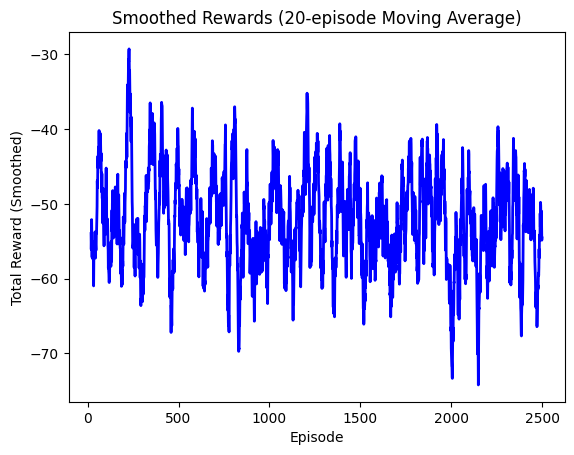

In [ ]:
import pandas as pd
plt.plot(pd.Series(newlr2_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json, os
from tqdm import tqdm


env = TrafficEnv(data)

# Load agent with same architecture
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load previous trained weights if available
model_path = "/content/ppo_traffic_model_2500.pt"
if os.path.exists(model_path):
    agent.load_state_dict(torch.load(model_path))
    print("✔ Loaded existing trained model:", model_path)
else:
    print("⚠ No previous model found — training will start fresh.")


# 2️.PPO Evaluation function (NO EXPLORATION)
def evaluate(agent, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0
        while not done:
            a, _ = agent.act(s)   # greedy action (actor takes highest prob)
            s, r, done, truncated, _ = env.step(a)
            total += r
        rewards.append(total)
    return np.mean(rewards)


# 3️. TRAINING FUNCTION (NEW)
def train_ppo_next_phase(
    episodes=1000,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    # Load previous reward log
    reward_history = []
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"✔ Loaded {len(reward_history)} previous reward entries.")

    # LR scheduler — reduces LR when improvement plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        agent.optimizer,
        mode='max',
        factor=0.5,     # Halve the LR
        patience=5,     # Wait 5 eval cycles
        min_lr=1e-6
        # verbose=True  # Removed verbose argument
    )

    print("\n Starting Next-Phase Training...\n")

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {len(reward_history)} | Reward: {total_reward:.2f}")

        # Every 100 episodes → evaluate & adjust LR
        if (ep + 1) % 100 == 0:
            eval_reward = evaluate(agent, env, episodes=5)
            print(f"🧪 Evaluation Reward after {len(reward_history)} eps: {eval_reward:.2f}")

            scheduler.step(eval_reward)

            # Save progress
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print("💾 Autosaved model + rewards.")

    # final save
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    print("\n🎉 Training Phase Complete!")
    return reward_history


# 4️⃣ Run training
new_rewards = train_ppo_next_phase(episodes=1000)

In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_3500.pt")


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")
files.download("ppo_traffic_model_3500.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

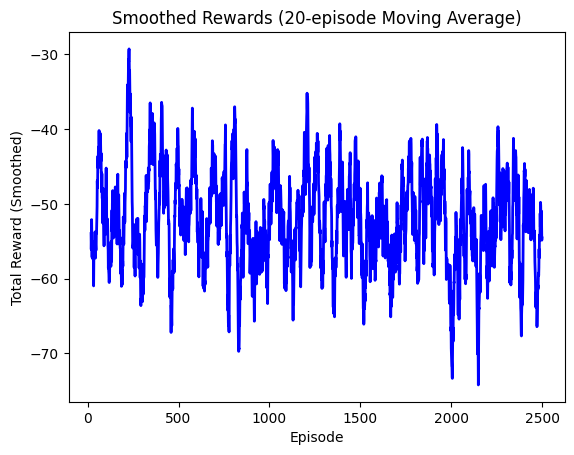

In [ ]:
import pandas as pd
plt.plot(pd.Series(newlr2_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
# TUNING the model:

In [ ]:
class TrafficEnv(gym.Env):
    def __init__(self, data):
        super(TrafficEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.max_index = len(data) - 1

        # Define spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(len(data.columns)-1,), dtype=np.float32)
        self.action_space = spaces.Discrete(4)  # 4 signal phases

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # Start from a random point in dataset
        self.current_step = np.random.randint(0, self.max_index - 50)
        obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32)
        info = {}
        return obs, info

    def step(self, action):
        self.current_step += 1
        done = self.current_step >= self.max_index

        row = self.data.iloc[self.current_step]
        wait_time = row.get('waiting_time', 0)
        queue_len = row.get('queue_length', 0)
        emergency = row.get('emergency_detected', 0) if 'emergency_detected' in row else 0

        reward = self.compute_reward(wait_time, queue_len, emergency, action)
        next_obs = row[:-1].values.astype(np.float32)
        truncated = False
        info = {}

        return next_obs, reward, done, truncated, info

    def compute_reward(self, wait_time, queue_len, emergency_detected, action):
        wait_time = wait_time / 100
        queue_len = queue_len / 50
        reward = - (0.6 * wait_time + 0.4 * queue_len)
        if emergency_detected:
          reward += 10
        return reward
        '''
        reward = - (0.7 * wait_time + 0.3 * queue_len)
        if emergency_detected and action == 0:  # example: NS-green helps emergency
            reward += 20
        return reward'''

    def render(self):
        pass


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import json, os
from tqdm import tqdm


env = TrafficEnv(data)

# Load agent with same architecture
agent = PPOAgent(state_dim=len(data.columns)-1, action_dim=4)

# Load previous trained weights if available
model_path = "/content/ppo_traffic_model_4000.pt"
if os.path.exists(model_path):
    agent.load_state_dict(torch.load(model_path))
    print("✔ Loaded existing trained model:", model_path)
else:
    print("⚠ No previous model found — training will start fresh.")


# 2️⃣ PPO Evaluation function (NO EXPLORATION)
def evaluate(agent, env, episodes=10):
    rewards = []
    for _ in range(episodes):
        s, _ = env.reset()
        done = False
        total = 0
        while not done:
            a, _ = agent.act(s)   # greedy action (actor takes highest prob)
            s, r, done, truncated, _ = env.step(a)
            total += r
        rewards.append(total)
    return np.mean(rewards)


# 3️⃣ TRAINING FUNCTION (NEW)
def train_ppo_next_phase(
    episodes=1000,
    gamma=0.99,
    clip_epsilon=0.2,
    save_path="ppo_traffic_model_latest.pt",
    rewards_path="reward_log.json"
):
    # Load previous reward log
    reward_history = []
    if os.path.exists(rewards_path):
        with open(rewards_path, "r") as f:
            reward_history = json.load(f)
        print(f"✔ Loaded {len(reward_history)} previous reward entries.")

    # LR scheduler — reduces LR when improvement plateaus
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        agent.optimizer,
        mode='max',
        factor=0.5,     # Halve the LR
        patience=5,     # Wait 5 eval cycles
        min_lr=1e-6
        # verbose=True  # Removed verbose argument
    )

    print("\n Starting Next-Phase Training...\n")

    for ep in tqdm(range(episodes)):
        state, _ = env.reset()
        done = False
        total_reward = 0

        while not done:
            action, log_prob = agent.act(state)
            next_state, reward, done, truncated, _ = env.step(action)

            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            reward_tensor = torch.tensor(reward, dtype=torch.float32)

            value = agent.critic(state_tensor)
            next_value = agent.critic(next_state_tensor)
            advantage = reward_tensor + gamma * next_value - value

            new_log_prob, _, entropy = agent.evaluate(
                state_tensor, torch.tensor([action], dtype=torch.long)
            )

            ratio = (new_log_prob - log_prob).exp()
            surr1 = ratio * advantage.detach()
            surr2 = torch.clamp(ratio, 1 - clip_epsilon, 1 + clip_epsilon) * advantage.detach()
            loss = -torch.min(surr1, surr2) + 0.5 * advantage.pow(2) - 0.01 * entropy

            agent.optimizer.zero_grad()
            loss.mean().backward()
            agent.optimizer.step()

            total_reward += reward
            state = next_state

        reward_history.append(total_reward)
        print(f"Episode {len(reward_history)} | Reward: {total_reward:.2f}")

        # Every 100 episodes → evaluate & adjust LR
        if (ep + 1) % 100 == 0:
            eval_reward = evaluate(agent, env, episodes=5)
            print(f"🧪 Evaluation Reward after {len(reward_history)} eps: {eval_reward:.2f}")

            scheduler.step(eval_reward)

            # Save progress
            torch.save(agent.state_dict(), save_path)
            with open(rewards_path, "w") as f:
                json.dump(reward_history, f)
            print("💾 Autosaved model + rewards.")

    # final save
    torch.save(agent.state_dict(), save_path)
    with open(rewards_path, "w") as f:
        json.dump(reward_history, f)

    print("\n🎉 Training Phase Complete!")
    return reward_history


# 4️⃣ Run training
new_rewards = train_ppo_next_phase(episodes=500)

In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_4000.pt")


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")
files.download("ppo_traffic_model_4000.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

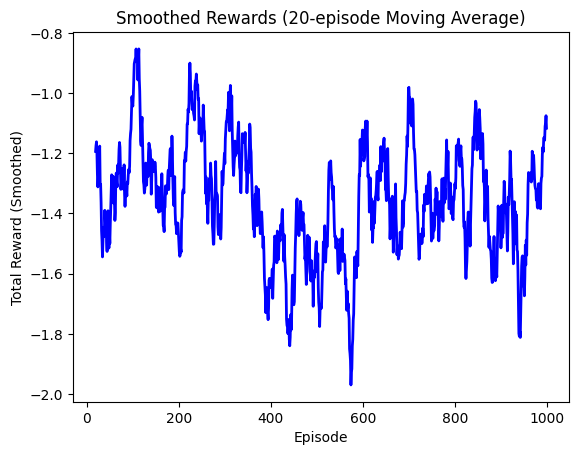

In [ ]:
import pandas as pd
plt.plot(pd.Series(new_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
# Re-create agent with smaller LR
agent = PPOAgent(
    state_dim=len(data.columns)-1,
    action_dim=4,
    lr=5e-5      # ← NEW learning rate
)

# Load previous trained model (4000 eps)
model_path = "/content/ppo_traffic_model_4000.pt"
agent.load_state_dict(torch.load(model_path))
print("✔ Loaded model with new LR for fine-tuning")


✔ Loaded model with new LR for fine-tuning


In [ ]:
print("Current learning rate:")
for g in agent.optimizer.param_groups:
    print(g['lr'])

Current learning rate:
5e-05


In [ ]:
new_rewards = train_ppo_next_phase(episodes=500)


✔ Loaded 1000 previous reward entries.

 Starting Next-Phase Training...



  0%|          | 1/500 [00:05<41:59,  5.05s/it]

Episode 1001 | Reward: -2.29


  0%|          | 2/500 [00:07<31:00,  3.74s/it]

Episode 1002 | Reward: -0.96


  1%|          | 3/500 [00:08<17:54,  2.16s/it]

Episode 1003 | Reward: -0.14


  1%|          | 4/500 [00:08<11:51,  1.44s/it]

Episode 1004 | Reward: -0.15


  1%|          | 5/500 [00:12<20:28,  2.48s/it]

Episode 1005 | Reward: -1.98


  1%|          | 6/500 [00:17<27:06,  3.29s/it]

Episode 1006 | Reward: -2.25


  1%|▏         | 7/500 [00:20<25:52,  3.15s/it]

Episode 1007 | Reward: -1.01


  2%|▏         | 8/500 [00:25<30:58,  3.78s/it]

Episode 1008 | Reward: -2.27


  2%|▏         | 9/500 [00:29<30:26,  3.72s/it]

Episode 1009 | Reward: -1.62


  2%|▏         | 10/500 [00:29<21:48,  2.67s/it]

Episode 1010 | Reward: -0.17


  2%|▏         | 11/500 [00:34<27:51,  3.42s/it]

Episode 1011 | Reward: -2.02


  2%|▏         | 12/500 [00:35<20:49,  2.56s/it]

Episode 1012 | Reward: -0.29


  3%|▎         | 13/500 [00:38<21:18,  2.63s/it]

Episode 1013 | Reward: -1.24


  3%|▎         | 14/500 [00:39<18:27,  2.28s/it]

Episode 1014 | Reward: -0.67


  3%|▎         | 15/500 [00:41<17:35,  2.18s/it]

Episode 1015 | Reward: -0.86


  3%|▎         | 16/500 [00:43<18:24,  2.28s/it]

Episode 1016 | Reward: -0.99


  3%|▎         | 17/500 [00:46<18:53,  2.35s/it]

Episode 1017 | Reward: -0.96


  4%|▎         | 18/500 [00:50<23:06,  2.88s/it]

Episode 1018 | Reward: -1.88


  4%|▍         | 19/500 [00:51<17:44,  2.21s/it]

Episode 1019 | Reward: -0.32


  4%|▍         | 20/500 [00:55<22:27,  2.81s/it]

Episode 1020 | Reward: -1.88


  4%|▍         | 21/500 [00:59<25:11,  3.16s/it]

Episode 1021 | Reward: -1.52


  4%|▍         | 22/500 [01:04<29:39,  3.72s/it]

Episode 1022 | Reward: -2.31


  5%|▍         | 23/500 [01:06<25:09,  3.17s/it]

Episode 1023 | Reward: -0.85


  5%|▍         | 24/500 [01:10<26:44,  3.37s/it]

Episode 1024 | Reward: -1.47


  5%|▌         | 25/500 [01:15<30:08,  3.81s/it]

Episode 1025 | Reward: -2.23


  5%|▌         | 26/500 [01:19<31:00,  3.93s/it]

Episode 1026 | Reward: -1.53


  5%|▌         | 27/500 [01:19<22:24,  2.84s/it]

Episode 1027 | Reward: -0.15


  6%|▌         | 28/500 [01:24<27:24,  3.48s/it]

Episode 1028 | Reward: -1.98


  6%|▌         | 29/500 [01:29<30:18,  3.86s/it]

Episode 1029 | Reward: -2.23


  6%|▌         | 30/500 [01:30<24:50,  3.17s/it]

Episode 1030 | Reward: -0.72


  6%|▌         | 31/500 [01:32<20:26,  2.62s/it]

Episode 1031 | Reward: -0.60


  6%|▋         | 32/500 [01:36<25:16,  3.24s/it]

Episode 1032 | Reward: -1.84


  7%|▋         | 33/500 [01:41<29:29,  3.79s/it]

Episode 1033 | Reward: -2.32


  7%|▋         | 34/500 [01:48<35:46,  4.61s/it]

Episode 1034 | Reward: -2.71


  7%|▋         | 35/500 [01:51<31:59,  4.13s/it]

Episode 1035 | Reward: -1.34


  7%|▋         | 36/500 [01:53<26:22,  3.41s/it]

Episode 1036 | Reward: -0.77


  7%|▋         | 37/500 [01:53<18:58,  2.46s/it]

Episode 1037 | Reward: -0.12


  8%|▊         | 38/500 [01:57<23:43,  3.08s/it]

Episode 1038 | Reward: -2.01


  8%|▊         | 39/500 [01:59<21:06,  2.75s/it]

Episode 1039 | Reward: -0.69


  8%|▊         | 40/500 [02:04<26:16,  3.43s/it]

Episode 1040 | Reward: -2.31


  8%|▊         | 41/500 [02:10<31:34,  4.13s/it]

Episode 1041 | Reward: -2.53


  8%|▊         | 42/500 [02:13<29:16,  3.84s/it]

Episode 1042 | Reward: -1.24


  9%|▊         | 43/500 [02:17<29:03,  3.82s/it]

Episode 1043 | Reward: -1.73


  9%|▉         | 44/500 [02:20<26:37,  3.50s/it]

Episode 1044 | Reward: -1.24


  9%|▉         | 45/500 [02:24<28:22,  3.74s/it]

Episode 1045 | Reward: -1.65


  9%|▉         | 46/500 [02:25<20:44,  2.74s/it]

Episode 1046 | Reward: -0.21


  9%|▉         | 47/500 [02:30<25:50,  3.42s/it]

Episode 1047 | Reward: -2.28


 10%|▉         | 48/500 [02:35<30:45,  4.08s/it]

Episode 1048 | Reward: -2.45


 10%|▉         | 49/500 [02:41<34:39,  4.61s/it]

Episode 1049 | Reward: -2.52


 10%|█         | 50/500 [02:45<33:04,  4.41s/it]

Episode 1050 | Reward: -1.77


 10%|█         | 51/500 [02:51<37:39,  5.03s/it]

Episode 1051 | Reward: -2.68


 10%|█         | 52/500 [02:52<27:05,  3.63s/it]

Episode 1052 | Reward: -0.18


 11%|█         | 53/500 [02:55<24:56,  3.35s/it]

Episode 1053 | Reward: -1.22


 11%|█         | 54/500 [03:01<31:34,  4.25s/it]

Episode 1054 | Reward: -2.63


 11%|█         | 55/500 [03:03<27:03,  3.65s/it]

Episode 1055 | Reward: -0.93


 11%|█         | 56/500 [03:06<25:20,  3.42s/it]

Episode 1056 | Reward: -1.30


 11%|█▏        | 57/500 [03:12<30:44,  4.16s/it]

Episode 1057 | Reward: -2.63


 12%|█▏        | 58/500 [03:14<25:19,  3.44s/it]

Episode 1058 | Reward: -0.58


 12%|█▏        | 59/500 [03:17<24:52,  3.39s/it]

Episode 1059 | Reward: -1.38


 12%|█▏        | 60/500 [03:21<26:02,  3.55s/it]

Episode 1060 | Reward: -1.76


 12%|█▏        | 61/500 [03:23<23:55,  3.27s/it]

Episode 1061 | Reward: -1.17


 12%|█▏        | 62/500 [03:27<25:14,  3.46s/it]

Episode 1062 | Reward: -1.45


 13%|█▎        | 63/500 [03:29<21:02,  2.89s/it]

Episode 1063 | Reward: -0.72


 13%|█▎        | 64/500 [03:32<21:01,  2.89s/it]

Episode 1064 | Reward: -1.27


 13%|█▎        | 65/500 [03:36<23:59,  3.31s/it]

Episode 1065 | Reward: -1.91


 13%|█▎        | 66/500 [03:41<27:55,  3.86s/it]

Episode 1066 | Reward: -2.05


 13%|█▎        | 67/500 [03:46<28:41,  3.98s/it]

Episode 1067 | Reward: -1.95


 14%|█▎        | 68/500 [03:48<25:48,  3.59s/it]

Episode 1068 | Reward: -1.20


 14%|█▍        | 69/500 [03:50<21:51,  3.04s/it]

Episode 1069 | Reward: -0.68


 14%|█▍        | 70/500 [03:52<20:19,  2.84s/it]

Episode 1070 | Reward: -0.90


 14%|█▍        | 71/500 [03:57<24:28,  3.42s/it]

Episode 1071 | Reward: -2.16


 14%|█▍        | 72/500 [04:00<22:43,  3.19s/it]

Episode 1072 | Reward: -1.17


 15%|█▍        | 73/500 [04:05<27:12,  3.82s/it]

Episode 1073 | Reward: -2.16


 15%|█▍        | 74/500 [04:09<27:19,  3.85s/it]

Episode 1074 | Reward: -1.77


 15%|█▌        | 75/500 [04:12<26:18,  3.72s/it]

Episode 1075 | Reward: -1.48


 15%|█▌        | 76/500 [04:14<21:59,  3.11s/it]

Episode 1076 | Reward: -0.69


 15%|█▌        | 77/500 [04:17<22:13,  3.15s/it]

Episode 1077 | Reward: -1.23


 16%|█▌        | 78/500 [04:20<21:03,  2.99s/it]

Episode 1078 | Reward: -1.18


 16%|█▌        | 79/500 [04:25<26:23,  3.76s/it]

Episode 1079 | Reward: -2.53


 16%|█▌        | 80/500 [04:27<21:16,  3.04s/it]

Episode 1080 | Reward: -0.52


 16%|█▌        | 81/500 [04:28<16:41,  2.39s/it]

Episode 1081 | Reward: -0.32


 16%|█▋        | 82/500 [04:33<23:17,  3.34s/it]

Episode 1082 | Reward: -2.51


 17%|█▋        | 83/500 [04:34<17:32,  2.52s/it]

Episode 1083 | Reward: -0.29


 17%|█▋        | 84/500 [04:40<24:32,  3.54s/it]

Episode 1084 | Reward: -2.52


 17%|█▋        | 85/500 [04:43<24:00,  3.47s/it]

Episode 1085 | Reward: -1.32


 17%|█▋        | 86/500 [04:46<22:33,  3.27s/it]

Episode 1086 | Reward: -1.26


 17%|█▋        | 87/500 [04:51<25:54,  3.76s/it]

Episode 1087 | Reward: -2.26


 18%|█▊        | 88/500 [04:54<24:06,  3.51s/it]

Episode 1088 | Reward: -1.02


 18%|█▊        | 89/500 [04:59<26:45,  3.91s/it]

Episode 1089 | Reward: -2.22


 18%|█▊        | 90/500 [05:02<25:52,  3.79s/it]

Episode 1090 | Reward: -1.56


 18%|█▊        | 91/500 [05:09<31:28,  4.62s/it]

Episode 1091 | Reward: -2.70


 18%|█▊        | 92/500 [05:14<33:24,  4.91s/it]

Episode 1092 | Reward: -2.60


 19%|█▊        | 93/500 [05:17<28:20,  4.18s/it]

Episode 1093 | Reward: -1.04


 19%|█▉        | 94/500 [05:18<23:19,  3.45s/it]

Episode 1094 | Reward: -0.60


 19%|█▉        | 95/500 [05:24<27:55,  4.14s/it]

Episode 1095 | Reward: -2.67


 19%|█▉        | 96/500 [05:25<20:37,  3.06s/it]

Episode 1096 | Reward: -0.27


 19%|█▉        | 97/500 [05:27<17:57,  2.67s/it]

Episode 1097 | Reward: -0.82


 20%|█▉        | 98/500 [05:31<21:16,  3.18s/it]

Episode 1098 | Reward: -1.67


 20%|█▉        | 99/500 [05:33<18:24,  2.76s/it]

Episode 1099 | Reward: -0.76
Episode 1100 | Reward: -1.88


 20%|██        | 100/500 [05:39<25:27,  3.82s/it]

🧪 Evaluation Reward after 1100 eps: -1.01
💾 Autosaved model + rewards.


 20%|██        | 101/500 [05:44<28:09,  4.23s/it]

Episode 1101 | Reward: -2.11


 20%|██        | 102/500 [05:47<25:55,  3.91s/it]

Episode 1102 | Reward: -1.44


 21%|██        | 103/500 [05:49<22:24,  3.39s/it]

Episode 1103 | Reward: -0.99


 21%|██        | 104/500 [05:55<25:49,  3.91s/it]

Episode 1104 | Reward: -2.26


 21%|██        | 105/500 [05:57<23:05,  3.51s/it]

Episode 1105 | Reward: -1.02


 21%|██        | 106/500 [06:03<26:46,  4.08s/it]

Episode 1106 | Reward: -2.48


 21%|██▏       | 107/500 [06:06<24:27,  3.73s/it]

Episode 1107 | Reward: -1.32


 22%|██▏       | 108/500 [06:06<18:46,  2.87s/it]

Episode 1108 | Reward: -0.34


 22%|██▏       | 109/500 [06:11<22:26,  3.44s/it]

Episode 1109 | Reward: -1.99


 22%|██▏       | 110/500 [06:14<21:24,  3.29s/it]

Episode 1110 | Reward: -1.34


 22%|██▏       | 111/500 [06:20<25:42,  3.97s/it]

Episode 1111 | Reward: -2.43


 22%|██▏       | 112/500 [06:20<18:40,  2.89s/it]

Episode 1112 | Reward: -0.14


 23%|██▎       | 113/500 [06:22<16:26,  2.55s/it]

Episode 1113 | Reward: -0.72


 23%|██▎       | 114/500 [06:22<12:04,  1.88s/it]

Episode 1114 | Reward: -0.15


 23%|██▎       | 115/500 [06:23<09:45,  1.52s/it]

Episode 1115 | Reward: -0.32


 23%|██▎       | 116/500 [06:28<16:00,  2.50s/it]

Episode 1116 | Reward: -2.19


 23%|██▎       | 117/500 [06:29<13:26,  2.11s/it]

Episode 1117 | Reward: -0.54


 24%|██▎       | 118/500 [06:33<17:45,  2.79s/it]

Episode 1118 | Reward: -1.69


 24%|██▍       | 119/500 [06:34<14:47,  2.33s/it]

Episode 1119 | Reward: -0.58


 24%|██▍       | 120/500 [06:36<14:08,  2.23s/it]

Episode 1120 | Reward: -0.92


 24%|██▍       | 121/500 [06:40<17:30,  2.77s/it]

Episode 1121 | Reward: -1.86


 24%|██▍       | 122/500 [06:41<13:54,  2.21s/it]

Episode 1122 | Reward: -0.40


 25%|██▍       | 123/500 [06:47<19:50,  3.16s/it]

Episode 1123 | Reward: -2.17


 25%|██▍       | 124/500 [06:47<15:23,  2.46s/it]

Episode 1124 | Reward: -0.39


 25%|██▌       | 125/500 [06:52<19:50,  3.17s/it]

Episode 1125 | Reward: -2.27


 25%|██▌       | 126/500 [06:55<18:13,  2.92s/it]

Episode 1126 | Reward: -1.07


 25%|██▌       | 127/500 [06:56<16:01,  2.58s/it]

Episode 1127 | Reward: -0.71


 26%|██▌       | 128/500 [07:00<17:33,  2.83s/it]

Episode 1128 | Reward: -1.33


 26%|██▌       | 129/500 [07:00<12:42,  2.05s/it]

Episode 1129 | Reward: -0.11


 26%|██▌       | 130/500 [07:03<13:39,  2.22s/it]

Episode 1130 | Reward: -1.18


 26%|██▌       | 131/500 [07:06<14:54,  2.42s/it]

Episode 1131 | Reward: -1.34


 26%|██▋       | 132/500 [07:06<11:05,  1.81s/it]

Episode 1132 | Reward: -0.19


 27%|██▋       | 133/500 [07:10<15:07,  2.47s/it]

Episode 1133 | Reward: -1.64


 27%|██▋       | 134/500 [07:15<19:34,  3.21s/it]

Episode 1134 | Reward: -2.22


 27%|██▋       | 135/500 [07:16<16:08,  2.65s/it]

Episode 1135 | Reward: -0.63


 27%|██▋       | 136/500 [07:17<13:22,  2.20s/it]

Episode 1136 | Reward: -0.54


 27%|██▋       | 137/500 [07:20<13:16,  2.19s/it]

Episode 1137 | Reward: -1.01


 28%|██▊       | 138/500 [07:26<20:31,  3.40s/it]

Episode 1138 | Reward: -2.59


 28%|██▊       | 139/500 [07:27<16:48,  2.79s/it]

Episode 1139 | Reward: -0.62


 28%|██▊       | 140/500 [07:33<21:22,  3.56s/it]

Episode 1140 | Reward: -2.51


 28%|██▊       | 141/500 [07:36<20:27,  3.42s/it]

Episode 1141 | Reward: -1.13


 28%|██▊       | 142/500 [07:36<15:11,  2.55s/it]

Episode 1142 | Reward: -0.26


 29%|██▊       | 143/500 [07:38<13:31,  2.27s/it]

Episode 1143 | Reward: -0.75


 29%|██▉       | 144/500 [07:42<16:43,  2.82s/it]

Episode 1144 | Reward: -1.87


 29%|██▉       | 145/500 [07:45<16:30,  2.79s/it]

Episode 1145 | Reward: -1.24


 29%|██▉       | 146/500 [07:46<14:15,  2.42s/it]

Episode 1146 | Reward: -0.61


 29%|██▉       | 147/500 [07:48<13:27,  2.29s/it]

Episode 1147 | Reward: -0.68


 30%|██▉       | 148/500 [07:51<14:18,  2.44s/it]

Episode 1148 | Reward: -1.25


 30%|██▉       | 149/500 [07:52<12:38,  2.16s/it]

Episode 1149 | Reward: -0.66


 30%|███       | 150/500 [07:57<16:58,  2.91s/it]

Episode 1150 | Reward: -2.16


 30%|███       | 151/500 [08:02<20:29,  3.52s/it]

Episode 1151 | Reward: -1.97


 30%|███       | 152/500 [08:04<18:08,  3.13s/it]

Episode 1152 | Reward: -1.02


 31%|███       | 153/500 [08:10<22:23,  3.87s/it]

Episode 1153 | Reward: -2.63


 31%|███       | 154/500 [08:16<26:21,  4.57s/it]

Episode 1154 | Reward: -2.61


 31%|███       | 155/500 [08:19<23:44,  4.13s/it]

Episode 1155 | Reward: -1.39


 31%|███       | 156/500 [08:23<22:30,  3.93s/it]

Episode 1156 | Reward: -1.58


 31%|███▏      | 157/500 [08:25<19:36,  3.43s/it]

Episode 1157 | Reward: -0.84


 32%|███▏      | 158/500 [08:30<23:10,  4.07s/it]

Episode 1158 | Reward: -2.52


 32%|███▏      | 159/500 [08:36<25:17,  4.45s/it]

Episode 1159 | Reward: -2.44


 32%|███▏      | 160/500 [08:42<28:18,  5.00s/it]

Episode 1160 | Reward: -2.66


 32%|███▏      | 161/500 [08:45<24:41,  4.37s/it]

Episode 1161 | Reward: -1.32


 32%|███▏      | 162/500 [08:50<25:05,  4.45s/it]

Episode 1162 | Reward: -1.98


 33%|███▎      | 163/500 [08:52<21:30,  3.83s/it]

Episode 1163 | Reward: -0.94


 33%|███▎      | 164/500 [08:58<24:47,  4.43s/it]

Episode 1164 | Reward: -2.70


 33%|███▎      | 165/500 [08:59<18:40,  3.34s/it]

Episode 1165 | Reward: -0.39


 33%|███▎      | 166/500 [09:03<20:43,  3.72s/it]

Episode 1166 | Reward: -1.83


 33%|███▎      | 167/500 [09:05<18:06,  3.26s/it]

Episode 1167 | Reward: -1.02


 34%|███▎      | 168/500 [09:07<16:03,  2.90s/it]

Episode 1168 | Reward: -0.96


 34%|███▍      | 169/500 [09:13<20:16,  3.67s/it]

Episode 1169 | Reward: -2.58


 34%|███▍      | 170/500 [09:19<23:40,  4.30s/it]

Episode 1170 | Reward: -2.36


 34%|███▍      | 171/500 [09:21<20:09,  3.68s/it]

Episode 1171 | Reward: -1.02


 34%|███▍      | 172/500 [09:25<20:07,  3.68s/it]

Episode 1172 | Reward: -1.64


 35%|███▍      | 173/500 [09:31<23:38,  4.34s/it]

Episode 1173 | Reward: -2.43


 35%|███▍      | 174/500 [09:31<17:12,  3.17s/it]

Episode 1174 | Reward: -0.22


 35%|███▌      | 175/500 [09:37<21:41,  4.00s/it]

Episode 1175 | Reward: -2.70


 35%|███▌      | 176/500 [09:37<15:48,  2.93s/it]

Episode 1176 | Reward: -0.21


 35%|███▌      | 177/500 [09:38<12:50,  2.38s/it]

Episode 1177 | Reward: -0.44


 36%|███▌      | 178/500 [09:42<15:17,  2.85s/it]

Episode 1178 | Reward: -1.52


 36%|███▌      | 179/500 [09:47<18:24,  3.44s/it]

Episode 1179 | Reward: -2.20


 36%|███▌      | 180/500 [09:53<22:54,  4.29s/it]

Episode 1180 | Reward: -2.66


 36%|███▌      | 181/500 [09:58<22:26,  4.22s/it]

Episode 1181 | Reward: -1.86


 36%|███▋      | 182/500 [10:00<18:47,  3.54s/it]

Episode 1182 | Reward: -0.90


 37%|███▋      | 183/500 [10:06<23:09,  4.38s/it]

Episode 1183 | Reward: -2.65


 37%|███▋      | 184/500 [10:08<19:35,  3.72s/it]

Episode 1184 | Reward: -1.01


 37%|███▋      | 185/500 [10:11<18:57,  3.61s/it]

Episode 1185 | Reward: -1.56


 37%|███▋      | 186/500 [10:16<21:09,  4.04s/it]

Episode 1186 | Reward: -2.30


 37%|███▋      | 187/500 [10:19<18:28,  3.54s/it]

Episode 1187 | Reward: -0.94


 38%|███▊      | 188/500 [10:20<14:28,  2.78s/it]

Episode 1188 | Reward: -0.49


 38%|███▊      | 189/500 [10:25<18:24,  3.55s/it]

Episode 1189 | Reward: -2.53


 38%|███▊      | 190/500 [10:27<15:24,  2.98s/it]

Episode 1190 | Reward: -0.78


 38%|███▊      | 191/500 [10:27<11:09,  2.17s/it]

Episode 1191 | Reward: -0.14


 38%|███▊      | 192/500 [10:28<08:37,  1.68s/it]

Episode 1192 | Reward: -0.28


 39%|███▊      | 193/500 [10:33<13:43,  2.68s/it]

Episode 1193 | Reward: -2.08


 39%|███▉      | 194/500 [10:35<13:44,  2.69s/it]

Episode 1194 | Reward: -1.26


 39%|███▉      | 195/500 [10:36<10:59,  2.16s/it]

Episode 1195 | Reward: -0.44


 39%|███▉      | 196/500 [10:37<08:56,  1.76s/it]

Episode 1196 | Reward: -0.39


 39%|███▉      | 197/500 [10:40<11:06,  2.20s/it]

Episode 1197 | Reward: -1.47


 40%|███▉      | 198/500 [10:41<08:35,  1.71s/it]

Episode 1198 | Reward: -0.21


 40%|███▉      | 199/500 [10:42<08:01,  1.60s/it]

Episode 1199 | Reward: -0.48
Episode 1200 | Reward: -2.58


 40%|████      | 200/500 [10:52<20:23,  4.08s/it]

🧪 Evaluation Reward after 1200 eps: -1.97
💾 Autosaved model + rewards.


 40%|████      | 201/500 [10:57<21:35,  4.33s/it]

Episode 1201 | Reward: -2.01


 40%|████      | 202/500 [10:59<18:23,  3.70s/it]

Episode 1202 | Reward: -1.02


 41%|████      | 203/500 [11:00<14:33,  2.94s/it]

Episode 1203 | Reward: -0.53


 41%|████      | 204/500 [11:06<18:14,  3.70s/it]

Episode 1204 | Reward: -2.44


 41%|████      | 205/500 [11:12<21:25,  4.36s/it]

Episode 1205 | Reward: -2.53


 41%|████      | 206/500 [11:16<21:44,  4.44s/it]

Episode 1206 | Reward: -2.19


 41%|████▏     | 207/500 [11:17<16:35,  3.40s/it]

Episode 1207 | Reward: -0.47


 42%|████▏     | 208/500 [11:24<20:57,  4.31s/it]

Episode 1208 | Reward: -2.67


 42%|████▏     | 209/500 [11:27<19:18,  3.98s/it]

Episode 1209 | Reward: -1.45


 42%|████▏     | 210/500 [11:31<18:43,  3.87s/it]

Episode 1210 | Reward: -1.64


 42%|████▏     | 211/500 [11:35<19:18,  4.01s/it]

Episode 1211 | Reward: -1.76


 42%|████▏     | 212/500 [11:37<16:53,  3.52s/it]

Episode 1212 | Reward: -1.07


 43%|████▎     | 213/500 [11:40<15:32,  3.25s/it]

Episode 1213 | Reward: -1.20


 43%|████▎     | 214/500 [11:44<15:54,  3.34s/it]

Episode 1214 | Reward: -1.51


 43%|████▎     | 215/500 [11:49<18:14,  3.84s/it]

Episode 1215 | Reward: -2.16


 43%|████▎     | 216/500 [11:53<19:24,  4.10s/it]

Episode 1216 | Reward: -2.20


 43%|████▎     | 217/500 [11:56<18:01,  3.82s/it]

Episode 1217 | Reward: -1.29


 44%|████▎     | 218/500 [12:02<19:56,  4.24s/it]

Episode 1218 | Reward: -2.26


 44%|████▍     | 219/500 [12:04<17:19,  3.70s/it]

Episode 1219 | Reward: -1.11


 44%|████▍     | 220/500 [12:05<13:52,  2.97s/it]

Episode 1220 | Reward: -0.57


 44%|████▍     | 221/500 [12:06<11:02,  2.37s/it]

Episode 1221 | Reward: -0.44


 44%|████▍     | 222/500 [12:10<12:12,  2.63s/it]

Episode 1222 | Reward: -1.23


 45%|████▍     | 223/500 [12:15<16:19,  3.54s/it]

Episode 1223 | Reward: -2.52


 45%|████▍     | 224/500 [12:18<15:29,  3.37s/it]

Episode 1224 | Reward: -1.37


 45%|████▌     | 225/500 [12:20<12:48,  2.80s/it]

Episode 1225 | Reward: -0.69


 45%|████▌     | 226/500 [12:23<13:17,  2.91s/it]

Episode 1226 | Reward: -1.15


 45%|████▌     | 227/500 [12:25<11:55,  2.62s/it]

Episode 1227 | Reward: -0.89


 46%|████▌     | 228/500 [12:29<13:41,  3.02s/it]

Episode 1228 | Reward: -1.84


 46%|████▌     | 229/500 [12:29<10:05,  2.24s/it]

Episode 1229 | Reward: -0.21


 46%|████▌     | 230/500 [12:32<11:29,  2.55s/it]

Episode 1230 | Reward: -1.51


 46%|████▌     | 231/500 [12:38<15:03,  3.36s/it]

Episode 1231 | Reward: -2.14


 46%|████▋     | 232/500 [12:39<12:58,  2.91s/it]

Episode 1232 | Reward: -0.85


 47%|████▋     | 233/500 [12:41<11:16,  2.53s/it]

Episode 1233 | Reward: -0.75


 47%|████▋     | 234/500 [12:45<12:52,  2.91s/it]

Episode 1234 | Reward: -1.77


 47%|████▋     | 235/500 [12:50<15:11,  3.44s/it]

Episode 1235 | Reward: -1.87


 47%|████▋     | 236/500 [12:54<15:48,  3.59s/it]

Episode 1236 | Reward: -1.83


 47%|████▋     | 237/500 [12:54<12:08,  2.77s/it]

Episode 1237 | Reward: -0.40


 48%|████▊     | 238/500 [12:57<11:17,  2.59s/it]

Episode 1238 | Reward: -0.97


 48%|████▊     | 239/500 [12:59<11:09,  2.56s/it]

Episode 1239 | Reward: -1.00


 48%|████▊     | 240/500 [13:05<15:06,  3.49s/it]

Episode 1240 | Reward: -2.44


 48%|████▊     | 241/500 [13:10<17:10,  3.98s/it]

Episode 1241 | Reward: -2.34


 48%|████▊     | 242/500 [13:13<15:39,  3.64s/it]

Episode 1242 | Reward: -1.00


 49%|████▊     | 243/500 [13:13<11:35,  2.71s/it]

Episode 1243 | Reward: -0.27


 49%|████▉     | 244/500 [13:15<10:40,  2.50s/it]

Episode 1244 | Reward: -0.94


 49%|████▉     | 245/500 [13:16<08:46,  2.06s/it]

Episode 1245 | Reward: -0.50


 49%|████▉     | 246/500 [13:18<08:29,  2.01s/it]

Episode 1246 | Reward: -0.86


 49%|████▉     | 247/500 [13:20<08:46,  2.08s/it]

Episode 1247 | Reward: -1.06


 50%|████▉     | 248/500 [13:26<13:32,  3.22s/it]

Episode 1248 | Reward: -2.41


 50%|████▉     | 249/500 [13:32<16:34,  3.96s/it]

Episode 1249 | Reward: -2.65


 50%|█████     | 250/500 [13:37<18:11,  4.37s/it]

Episode 1250 | Reward: -2.21


 50%|█████     | 251/500 [13:40<16:12,  3.90s/it]

Episode 1251 | Reward: -1.24


 50%|█████     | 252/500 [13:46<18:17,  4.43s/it]

Episode 1252 | Reward: -2.64


 51%|█████     | 253/500 [13:51<19:38,  4.77s/it]

Episode 1253 | Reward: -2.27


 51%|█████     | 254/500 [13:52<14:31,  3.54s/it]

Episode 1254 | Reward: -0.33


 51%|█████     | 255/500 [13:55<13:21,  3.27s/it]

Episode 1255 | Reward: -1.24


 51%|█████     | 256/500 [13:57<12:13,  3.01s/it]

Episode 1256 | Reward: -1.08


 51%|█████▏    | 257/500 [13:58<10:03,  2.48s/it]

Episode 1257 | Reward: -0.57


 52%|█████▏    | 258/500 [14:01<10:25,  2.58s/it]

Episode 1258 | Reward: -1.18


 52%|█████▏    | 259/500 [14:07<14:19,  3.56s/it]

Episode 1259 | Reward: -2.56


 52%|█████▏    | 260/500 [14:11<14:18,  3.58s/it]

Episode 1260 | Reward: -1.64


 52%|█████▏    | 261/500 [14:17<17:03,  4.28s/it]

Episode 1261 | Reward: -2.49


 52%|█████▏    | 262/500 [14:20<15:47,  3.98s/it]

Episode 1262 | Reward: -1.49


 53%|█████▎    | 263/500 [14:23<15:22,  3.89s/it]

Episode 1263 | Reward: -1.68


 53%|█████▎    | 264/500 [14:30<18:01,  4.58s/it]

Episode 1264 | Reward: -2.61


 53%|█████▎    | 265/500 [14:34<17:03,  4.36s/it]

Episode 1265 | Reward: -1.76


 53%|█████▎    | 266/500 [14:38<17:31,  4.50s/it]

Episode 1266 | Reward: -2.16


 53%|█████▎    | 267/500 [14:39<13:10,  3.39s/it]

Episode 1267 | Reward: -0.32


 54%|█████▎    | 268/500 [14:41<11:51,  3.07s/it]

Episode 1268 | Reward: -0.91


 54%|█████▍    | 269/500 [14:46<12:58,  3.37s/it]

Episode 1269 | Reward: -1.90


 54%|█████▍    | 270/500 [14:50<14:02,  3.66s/it]

Episode 1270 | Reward: -2.01


 54%|█████▍    | 271/500 [14:52<12:17,  3.22s/it]

Episode 1271 | Reward: -0.75


 54%|█████▍    | 272/500 [14:56<12:50,  3.38s/it]

Episode 1272 | Reward: -1.64


 55%|█████▍    | 273/500 [15:01<14:20,  3.79s/it]

Episode 1273 | Reward: -2.14


 55%|█████▍    | 274/500 [15:07<16:56,  4.50s/it]

Episode 1274 | Reward: -2.53


 55%|█████▌    | 275/500 [15:10<15:50,  4.22s/it]

Episode 1275 | Reward: -1.59


 55%|█████▌    | 276/500 [15:14<15:18,  4.10s/it]

Episode 1276 | Reward: -1.76


 55%|█████▌    | 277/500 [15:16<12:44,  3.43s/it]

Episode 1277 | Reward: -0.74


 56%|█████▌    | 278/500 [15:18<11:34,  3.13s/it]

Episode 1278 | Reward: -0.94


 56%|█████▌    | 279/500 [15:23<13:04,  3.55s/it]

Episode 1279 | Reward: -2.10


 56%|█████▌    | 280/500 [15:24<09:46,  2.67s/it]

Episode 1280 | Reward: -0.29


 56%|█████▌    | 281/500 [15:29<12:41,  3.48s/it]

Episode 1281 | Reward: -2.37


 56%|█████▋    | 282/500 [15:35<15:23,  4.24s/it]

Episode 1282 | Reward: -2.66


 57%|█████▋    | 283/500 [15:37<12:41,  3.51s/it]

Episode 1283 | Reward: -0.85


 57%|█████▋    | 284/500 [15:39<10:56,  3.04s/it]

Episode 1284 | Reward: -0.89


 57%|█████▋    | 285/500 [15:42<11:35,  3.23s/it]

Episode 1285 | Reward: -1.39


 57%|█████▋    | 286/500 [15:45<11:23,  3.19s/it]

Episode 1286 | Reward: -1.39


 57%|█████▋    | 287/500 [15:46<08:32,  2.41s/it]

Episode 1287 | Reward: -0.28


 58%|█████▊    | 288/500 [15:49<09:09,  2.59s/it]

Episode 1288 | Reward: -1.38


 58%|█████▊    | 289/500 [15:54<11:37,  3.31s/it]

Episode 1289 | Reward: -2.14


 58%|█████▊    | 290/500 [15:55<09:33,  2.73s/it]

Episode 1290 | Reward: -0.50


 58%|█████▊    | 291/500 [15:58<09:01,  2.59s/it]

Episode 1291 | Reward: -1.02


 58%|█████▊    | 292/500 [15:58<07:06,  2.05s/it]

Episode 1292 | Reward: -0.38


 59%|█████▊    | 293/500 [15:59<05:21,  1.55s/it]

Episode 1293 | Reward: -0.20


 59%|█████▉    | 294/500 [16:04<08:40,  2.53s/it]

Episode 1294 | Reward: -2.27


 59%|█████▉    | 295/500 [16:10<12:18,  3.60s/it]

Episode 1295 | Reward: -2.56


 59%|█████▉    | 296/500 [16:13<12:05,  3.56s/it]

Episode 1296 | Reward: -1.56


 59%|█████▉    | 297/500 [16:16<11:23,  3.37s/it]

Episode 1297 | Reward: -1.34


 60%|█████▉    | 298/500 [16:18<09:37,  2.86s/it]

Episode 1298 | Reward: -0.71


 60%|█████▉    | 299/500 [16:20<09:06,  2.72s/it]

Episode 1299 | Reward: -0.84
Episode 1300 | Reward: -0.77


 60%|██████    | 300/500 [16:23<09:25,  2.83s/it]

🧪 Evaluation Reward after 1300 eps: -0.61
💾 Autosaved model + rewards.


 60%|██████    | 301/500 [16:24<06:51,  2.07s/it]

Episode 1301 | Reward: -0.15


 60%|██████    | 302/500 [16:26<07:10,  2.18s/it]

Episode 1302 | Reward: -1.14


 61%|██████    | 303/500 [16:31<09:42,  2.96s/it]

Episode 1303 | Reward: -2.15


 61%|██████    | 304/500 [16:37<12:20,  3.78s/it]

Episode 1304 | Reward: -2.47


 61%|██████    | 305/500 [16:38<10:11,  3.14s/it]

Episode 1305 | Reward: -0.74


 61%|██████    | 306/500 [16:42<10:33,  3.27s/it]

Episode 1306 | Reward: -1.65


 61%|██████▏   | 307/500 [16:44<09:42,  3.02s/it]

Episode 1307 | Reward: -0.88


 62%|██████▏   | 308/500 [16:46<08:24,  2.63s/it]

Episode 1308 | Reward: -0.70


 62%|██████▏   | 309/500 [16:50<10:07,  3.18s/it]

Episode 1309 | Reward: -2.07


 62%|██████▏   | 310/500 [16:52<08:27,  2.67s/it]

Episode 1310 | Reward: -0.69


 62%|██████▏   | 311/500 [16:55<08:51,  2.81s/it]

Episode 1311 | Reward: -1.39


 62%|██████▏   | 312/500 [16:57<07:49,  2.50s/it]

Episode 1312 | Reward: -0.61


 63%|██████▎   | 313/500 [16:58<06:55,  2.22s/it]

Episode 1313 | Reward: -0.62


 63%|██████▎   | 314/500 [17:03<09:10,  2.96s/it]

Episode 1314 | Reward: -2.15


 63%|██████▎   | 315/500 [17:07<10:07,  3.28s/it]

Episode 1315 | Reward: -1.88


 63%|██████▎   | 316/500 [17:09<08:39,  2.82s/it]

Episode 1316 | Reward: -0.66


 63%|██████▎   | 317/500 [17:14<10:58,  3.60s/it]

Episode 1317 | Reward: -2.42


 64%|██████▎   | 318/500 [17:18<11:05,  3.66s/it]

Episode 1318 | Reward: -1.77


 64%|██████▍   | 319/500 [17:18<08:03,  2.67s/it]

Episode 1319 | Reward: -0.20


 64%|██████▍   | 320/500 [17:19<06:36,  2.21s/it]

Episode 1320 | Reward: -0.51


 64%|██████▍   | 321/500 [17:20<05:12,  1.75s/it]

Episode 1321 | Reward: -0.30


 64%|██████▍   | 322/500 [17:24<06:39,  2.24s/it]

Episode 1322 | Reward: -1.29


 65%|██████▍   | 323/500 [17:24<05:00,  1.70s/it]

Episode 1323 | Reward: -0.22


 65%|██████▍   | 324/500 [17:29<07:38,  2.60s/it]

Episode 1324 | Reward: -2.22


 65%|██████▌   | 325/500 [17:30<06:09,  2.11s/it]

Episode 1325 | Reward: -0.44


 65%|██████▌   | 326/500 [17:34<08:10,  2.82s/it]

Episode 1326 | Reward: -1.87


 65%|██████▌   | 327/500 [17:36<07:28,  2.59s/it]

Episode 1327 | Reward: -0.83


 66%|██████▌   | 328/500 [17:41<09:38,  3.36s/it]

Episode 1328 | Reward: -2.40


 66%|██████▌   | 329/500 [17:47<11:26,  4.02s/it]

Episode 1329 | Reward: -2.39


 66%|██████▌   | 330/500 [17:50<10:36,  3.75s/it]

Episode 1330 | Reward: -1.35


 66%|██████▌   | 331/500 [17:55<11:45,  4.18s/it]

Episode 1331 | Reward: -2.42


 66%|██████▋   | 332/500 [17:57<09:38,  3.45s/it]

Episode 1332 | Reward: -0.78


 67%|██████▋   | 333/500 [18:02<10:51,  3.90s/it]

Episode 1333 | Reward: -2.02


 67%|██████▋   | 334/500 [18:03<08:24,  3.04s/it]

Episode 1334 | Reward: -0.47


 67%|██████▋   | 335/500 [18:08<10:03,  3.66s/it]

Episode 1335 | Reward: -2.34


 67%|██████▋   | 336/500 [18:14<11:58,  4.38s/it]

Episode 1336 | Reward: -2.52


 67%|██████▋   | 337/500 [18:15<08:44,  3.22s/it]

Episode 1337 | Reward: -0.25


 68%|██████▊   | 338/500 [18:19<10:03,  3.73s/it]

Episode 1338 | Reward: -2.25


 68%|██████▊   | 339/500 [18:26<12:02,  4.49s/it]

Episode 1339 | Reward: -2.62


 68%|██████▊   | 340/500 [18:26<08:58,  3.36s/it]

Episode 1340 | Reward: -0.36


 68%|██████▊   | 341/500 [18:29<08:17,  3.13s/it]

Episode 1341 | Reward: -1.20


 68%|██████▊   | 342/500 [18:33<08:30,  3.23s/it]

Episode 1342 | Reward: -1.61


 69%|██████▊   | 343/500 [18:38<10:02,  3.84s/it]

Episode 1343 | Reward: -2.13


 69%|██████▉   | 344/500 [18:39<07:56,  3.06s/it]

Episode 1344 | Reward: -0.56


 69%|██████▉   | 345/500 [18:41<07:24,  2.87s/it]

Episode 1345 | Reward: -1.07


 69%|██████▉   | 346/500 [18:45<07:32,  2.94s/it]

Episode 1346 | Reward: -1.38


 69%|██████▉   | 347/500 [18:48<08:00,  3.14s/it]

Episode 1347 | Reward: -1.53


 70%|██████▉   | 348/500 [18:54<10:01,  3.96s/it]

Episode 1348 | Reward: -2.59


 70%|██████▉   | 349/500 [18:56<08:34,  3.41s/it]

Episode 1349 | Reward: -0.98


 70%|███████   | 350/500 [19:01<09:55,  3.97s/it]

Episode 1350 | Reward: -2.27


 70%|███████   | 351/500 [19:07<11:21,  4.58s/it]

Episode 1351 | Reward: -2.67


 70%|███████   | 352/500 [19:10<09:46,  3.96s/it]

Episode 1352 | Reward: -1.16


 71%|███████   | 353/500 [19:13<09:13,  3.76s/it]

Episode 1353 | Reward: -1.14


 71%|███████   | 354/500 [19:16<08:02,  3.31s/it]

Episode 1354 | Reward: -0.72


 71%|███████   | 355/500 [19:17<06:26,  2.67s/it]

Episode 1355 | Reward: -0.54


 71%|███████   | 356/500 [19:20<06:43,  2.80s/it]

Episode 1356 | Reward: -1.43


 71%|███████▏  | 357/500 [19:23<06:40,  2.80s/it]

Episode 1357 | Reward: -1.28


 72%|███████▏  | 358/500 [19:25<06:01,  2.55s/it]

Episode 1358 | Reward: -0.92


 72%|███████▏  | 359/500 [19:29<07:05,  3.02s/it]

Episode 1359 | Reward: -1.60


 72%|███████▏  | 360/500 [19:32<07:16,  3.12s/it]

Episode 1360 | Reward: -1.56


 72%|███████▏  | 361/500 [19:36<07:31,  3.25s/it]

Episode 1361 | Reward: -1.61


 72%|███████▏  | 362/500 [19:36<05:40,  2.47s/it]

Episode 1362 | Reward: -0.32


 73%|███████▎  | 363/500 [19:38<04:58,  2.18s/it]

Episode 1363 | Reward: -0.62


 73%|███████▎  | 364/500 [19:39<04:40,  2.06s/it]

Episode 1364 | Reward: -0.63


 73%|███████▎  | 365/500 [19:40<03:35,  1.59s/it]

Episode 1365 | Reward: -0.21


 73%|███████▎  | 366/500 [19:42<03:54,  1.75s/it]

Episode 1366 | Reward: -0.99


 73%|███████▎  | 367/500 [19:47<05:53,  2.66s/it]

Episode 1367 | Reward: -2.24


 74%|███████▎  | 368/500 [19:53<08:24,  3.82s/it]

Episode 1368 | Reward: -2.70


 74%|███████▍  | 369/500 [19:58<08:35,  3.94s/it]

Episode 1369 | Reward: -2.02


 74%|███████▍  | 370/500 [19:59<07:07,  3.29s/it]

Episode 1370 | Reward: -0.82


 74%|███████▍  | 371/500 [20:00<05:36,  2.61s/it]

Episode 1371 | Reward: -0.48


 74%|███████▍  | 372/500 [20:01<04:26,  2.08s/it]

Episode 1372 | Reward: -0.40


 75%|███████▍  | 373/500 [20:02<03:24,  1.61s/it]

Episode 1373 | Reward: -0.26


 75%|███████▍  | 374/500 [20:02<02:31,  1.20s/it]

Episode 1374 | Reward: -0.13


 75%|███████▌  | 375/500 [20:05<03:33,  1.71s/it]

Episode 1375 | Reward: -1.04


 75%|███████▌  | 376/500 [20:07<03:57,  1.92s/it]

Episode 1376 | Reward: -1.11


 75%|███████▌  | 377/500 [20:13<06:20,  3.09s/it]

Episode 1377 | Reward: -2.68


 76%|███████▌  | 378/500 [20:20<08:17,  4.08s/it]

Episode 1378 | Reward: -2.66


 76%|███████▌  | 379/500 [20:22<07:13,  3.58s/it]

Episode 1379 | Reward: -1.07


 76%|███████▌  | 380/500 [20:26<07:28,  3.73s/it]

Episode 1380 | Reward: -1.88


 76%|███████▌  | 381/500 [20:31<08:11,  4.13s/it]

Episode 1381 | Reward: -2.01


 76%|███████▋  | 382/500 [20:33<06:55,  3.52s/it]

Episode 1382 | Reward: -0.96


 77%|███████▋  | 383/500 [20:36<06:32,  3.36s/it]

Episode 1383 | Reward: -1.37


 77%|███████▋  | 384/500 [20:41<07:22,  3.81s/it]

Episode 1384 | Reward: -2.11


 77%|███████▋  | 385/500 [20:46<07:48,  4.07s/it]

Episode 1385 | Reward: -2.01


 77%|███████▋  | 386/500 [20:47<06:03,  3.19s/it]

Episode 1386 | Reward: -0.51


 77%|███████▋  | 387/500 [20:52<07:09,  3.80s/it]

Episode 1387 | Reward: -2.39


 78%|███████▊  | 388/500 [20:54<06:07,  3.28s/it]

Episode 1388 | Reward: -0.72


 78%|███████▊  | 389/500 [20:59<07:06,  3.84s/it]

Episode 1389 | Reward: -2.34


 78%|███████▊  | 390/500 [21:03<06:57,  3.80s/it]

Episode 1390 | Reward: -1.67


 78%|███████▊  | 391/500 [21:08<07:36,  4.19s/it]

Episode 1391 | Reward: -2.07


 78%|███████▊  | 392/500 [21:12<07:32,  4.19s/it]

Episode 1392 | Reward: -1.99


 79%|███████▊  | 393/500 [21:16<07:16,  4.08s/it]

Episode 1393 | Reward: -1.80


 79%|███████▉  | 394/500 [21:21<07:47,  4.41s/it]

Episode 1394 | Reward: -2.10


 79%|███████▉  | 395/500 [21:27<08:08,  4.65s/it]

Episode 1395 | Reward: -2.45


 79%|███████▉  | 396/500 [21:32<08:43,  5.04s/it]

Episode 1396 | Reward: -2.50


 79%|███████▉  | 397/500 [21:37<08:09,  4.75s/it]

Episode 1397 | Reward: -1.89


 80%|███████▉  | 398/500 [21:38<06:24,  3.77s/it]

Episode 1398 | Reward: -0.68


 80%|███████▉  | 399/500 [21:41<05:44,  3.41s/it]

Episode 1399 | Reward: -1.23
Episode 1400 | Reward: -1.79


 80%|████████  | 400/500 [21:48<07:34,  4.55s/it]

🧪 Evaluation Reward after 1400 eps: -1.25
💾 Autosaved model + rewards.


 80%|████████  | 401/500 [21:50<06:23,  3.88s/it]

Episode 1401 | Reward: -1.07


 80%|████████  | 402/500 [21:54<06:06,  3.74s/it]

Episode 1402 | Reward: -1.58


 81%|████████  | 403/500 [21:56<05:18,  3.28s/it]

Episode 1403 | Reward: -0.85


 81%|████████  | 404/500 [22:01<06:01,  3.76s/it]

Episode 1404 | Reward: -2.16


 81%|████████  | 405/500 [22:06<06:37,  4.19s/it]

Episode 1405 | Reward: -2.42


 81%|████████  | 406/500 [22:11<07:09,  4.57s/it]

Episode 1406 | Reward: -2.26


 81%|████████▏ | 407/500 [22:15<06:51,  4.43s/it]

Episode 1407 | Reward: -1.94


 82%|████████▏ | 408/500 [22:16<05:00,  3.26s/it]

Episode 1408 | Reward: -0.26


 82%|████████▏ | 409/500 [22:22<06:11,  4.08s/it]

Episode 1409 | Reward: -2.58


 82%|████████▏ | 410/500 [22:24<05:06,  3.41s/it]

Episode 1410 | Reward: -0.86


 82%|████████▏ | 411/500 [22:26<04:20,  2.92s/it]

Episode 1411 | Reward: -0.85


 82%|████████▏ | 412/500 [22:31<05:29,  3.74s/it]

Episode 1412 | Reward: -2.71


 83%|████████▎ | 413/500 [22:32<04:11,  2.89s/it]

Episode 1413 | Reward: -0.40


 83%|████████▎ | 414/500 [22:33<03:20,  2.33s/it]

Episode 1414 | Reward: -0.38


 83%|████████▎ | 415/500 [22:36<03:28,  2.45s/it]

Episode 1415 | Reward: -1.15


 83%|████████▎ | 416/500 [22:38<03:14,  2.32s/it]

Episode 1416 | Reward: -0.94


 83%|████████▎ | 417/500 [22:40<03:10,  2.30s/it]

Episode 1417 | Reward: -1.04


 84%|████████▎ | 418/500 [22:43<03:10,  2.33s/it]

Episode 1418 | Reward: -1.09


 84%|████████▍ | 419/500 [22:48<04:34,  3.39s/it]

Episode 1419 | Reward: -2.47


 84%|████████▍ | 420/500 [22:54<05:21,  4.02s/it]

Episode 1420 | Reward: -2.60


 84%|████████▍ | 421/500 [22:55<04:08,  3.14s/it]

Episode 1421 | Reward: -0.51


 84%|████████▍ | 422/500 [23:00<04:49,  3.71s/it]

Episode 1422 | Reward: -2.13


 85%|████████▍ | 423/500 [23:01<03:50,  2.99s/it]

Episode 1423 | Reward: -0.61


 85%|████████▍ | 424/500 [23:06<04:15,  3.36s/it]

Episode 1424 | Reward: -1.99


 85%|████████▌ | 425/500 [23:08<03:57,  3.17s/it]

Episode 1425 | Reward: -1.27


 85%|████████▌ | 426/500 [23:12<04:02,  3.28s/it]

Episode 1426 | Reward: -1.33


 85%|████████▌ | 427/500 [23:16<04:18,  3.55s/it]

Episode 1427 | Reward: -1.98


 86%|████████▌ | 428/500 [23:17<03:26,  2.87s/it]

Episode 1428 | Reward: -0.60


 86%|████████▌ | 429/500 [23:20<03:22,  2.85s/it]

Episode 1429 | Reward: -1.34


 86%|████████▌ | 430/500 [23:26<04:24,  3.78s/it]

Episode 1430 | Reward: -2.55


 86%|████████▌ | 431/500 [23:29<04:11,  3.64s/it]

Episode 1431 | Reward: -1.54


 86%|████████▋ | 432/500 [23:31<03:20,  2.94s/it]

Episode 1432 | Reward: -0.61


 87%|████████▋ | 433/500 [23:31<02:27,  2.20s/it]

Episode 1433 | Reward: -0.25


 87%|████████▋ | 434/500 [23:32<02:08,  1.95s/it]

Episode 1434 | Reward: -0.67


 87%|████████▋ | 435/500 [23:37<02:56,  2.72s/it]

Episode 1435 | Reward: -1.85


 87%|████████▋ | 436/500 [23:40<02:57,  2.77s/it]

Episode 1436 | Reward: -1.32


 87%|████████▋ | 437/500 [23:40<02:09,  2.06s/it]

Episode 1437 | Reward: -0.23


 88%|████████▊ | 438/500 [23:46<03:12,  3.11s/it]

Episode 1438 | Reward: -2.65


 88%|████████▊ | 439/500 [23:47<02:36,  2.57s/it]

Episode 1439 | Reward: -0.51


 88%|████████▊ | 440/500 [23:49<02:25,  2.42s/it]

Episode 1440 | Reward: -0.76


 88%|████████▊ | 441/500 [23:53<02:51,  2.91s/it]

Episode 1441 | Reward: -1.91


 88%|████████▊ | 442/500 [23:58<03:18,  3.43s/it]

Episode 1442 | Reward: -2.22


 89%|████████▊ | 443/500 [24:04<03:58,  4.19s/it]

Episode 1443 | Reward: -2.52


 89%|████████▉ | 444/500 [24:05<03:08,  3.37s/it]

Episode 1444 | Reward: -0.69


 89%|████████▉ | 445/500 [24:09<03:10,  3.46s/it]

Episode 1445 | Reward: -1.70


 89%|████████▉ | 446/500 [24:14<03:33,  3.96s/it]

Episode 1446 | Reward: -2.15


 89%|████████▉ | 447/500 [24:16<02:50,  3.23s/it]

Episode 1447 | Reward: -0.72


 90%|████████▉ | 448/500 [24:19<02:54,  3.36s/it]

Episode 1448 | Reward: -1.76


 90%|████████▉ | 449/500 [24:22<02:46,  3.26s/it]

Episode 1449 | Reward: -1.40


 90%|█████████ | 450/500 [24:23<01:59,  2.40s/it]

Episode 1450 | Reward: -0.20


 90%|█████████ | 451/500 [24:28<02:39,  3.25s/it]

Episode 1451 | Reward: -2.20


 90%|█████████ | 452/500 [24:33<02:59,  3.75s/it]

Episode 1452 | Reward: -2.34


 91%|█████████ | 453/500 [24:37<03:02,  3.87s/it]

Episode 1453 | Reward: -1.88


 91%|█████████ | 454/500 [24:39<02:29,  3.25s/it]

Episode 1454 | Reward: -0.69


 91%|█████████ | 455/500 [24:44<02:51,  3.80s/it]

Episode 1455 | Reward: -2.45


 91%|█████████ | 456/500 [24:47<02:41,  3.67s/it]

Episode 1456 | Reward: -1.57


 91%|█████████▏| 457/500 [24:52<02:49,  3.93s/it]

Episode 1457 | Reward: -1.86


 92%|█████████▏| 458/500 [24:55<02:41,  3.84s/it]

Episode 1458 | Reward: -1.69


 92%|█████████▏| 459/500 [24:57<02:14,  3.29s/it]

Episode 1459 | Reward: -0.93


 92%|█████████▏| 460/500 [24:58<01:40,  2.51s/it]

Episode 1460 | Reward: -0.33


 92%|█████████▏| 461/500 [25:02<01:56,  2.99s/it]

Episode 1461 | Reward: -1.77


 92%|█████████▏| 462/500 [25:06<01:57,  3.10s/it]

Episode 1462 | Reward: -1.38


 93%|█████████▎| 463/500 [25:08<01:43,  2.79s/it]

Episode 1463 | Reward: -0.98


 93%|█████████▎| 464/500 [25:10<01:30,  2.52s/it]

Episode 1464 | Reward: -0.85


 93%|█████████▎| 465/500 [25:15<01:55,  3.31s/it]

Episode 1465 | Reward: -2.25


 93%|█████████▎| 466/500 [25:17<01:44,  3.06s/it]

Episode 1466 | Reward: -1.02


 93%|█████████▎| 467/500 [25:22<01:57,  3.57s/it]

Episode 1467 | Reward: -2.24


 94%|█████████▎| 468/500 [25:26<01:56,  3.63s/it]

Episode 1468 | Reward: -1.79


 94%|█████████▍| 469/500 [25:28<01:36,  3.11s/it]

Episode 1469 | Reward: -0.69


 94%|█████████▍| 470/500 [25:33<01:51,  3.71s/it]

Episode 1470 | Reward: -2.36


 94%|█████████▍| 471/500 [25:37<01:52,  3.87s/it]

Episode 1471 | Reward: -2.00


 94%|█████████▍| 472/500 [25:42<01:56,  4.16s/it]

Episode 1472 | Reward: -1.95


 95%|█████████▍| 473/500 [25:46<01:55,  4.26s/it]

Episode 1473 | Reward: -2.05


 95%|█████████▍| 474/500 [25:47<01:26,  3.33s/it]

Episode 1474 | Reward: -0.55


 95%|█████████▌| 475/500 [25:49<01:13,  2.94s/it]

Episode 1475 | Reward: -0.96


 95%|█████████▌| 476/500 [25:55<01:30,  3.78s/it]

Episode 1476 | Reward: -2.40


 95%|█████████▌| 477/500 [26:00<01:30,  3.94s/it]

Episode 1477 | Reward: -2.05


 96%|█████████▌| 478/500 [26:04<01:28,  4.02s/it]

Episode 1478 | Reward: -1.87


 96%|█████████▌| 479/500 [26:05<01:04,  3.09s/it]

Episode 1479 | Reward: -0.34


 96%|█████████▌| 480/500 [26:11<01:20,  4.01s/it]

Episode 1480 | Reward: -2.68


 96%|█████████▌| 481/500 [26:14<01:11,  3.75s/it]

Episode 1481 | Reward: -1.47


 96%|█████████▋| 482/500 [26:17<01:02,  3.46s/it]

Episode 1482 | Reward: -1.17


 97%|█████████▋| 483/500 [26:19<00:50,  2.96s/it]

Episode 1483 | Reward: -0.68


 97%|█████████▋| 484/500 [26:21<00:44,  2.80s/it]

Episode 1484 | Reward: -1.15


 97%|█████████▋| 485/500 [26:23<00:36,  2.43s/it]

Episode 1485 | Reward: -0.73


 97%|█████████▋| 486/500 [26:27<00:42,  3.02s/it]

Episode 1486 | Reward: -2.12


 97%|█████████▋| 487/500 [26:29<00:34,  2.67s/it]

Episode 1487 | Reward: -0.76


 98%|█████████▊| 488/500 [26:29<00:24,  2.05s/it]

Episode 1488 | Reward: -0.26


 98%|█████████▊| 489/500 [26:35<00:34,  3.14s/it]

Episode 1489 | Reward: -2.57


 98%|█████████▊| 490/500 [26:37<00:26,  2.65s/it]

Episode 1490 | Reward: -0.72


 98%|█████████▊| 491/500 [26:42<00:31,  3.54s/it]

Episode 1491 | Reward: -2.45


 98%|█████████▊| 492/500 [26:46<00:27,  3.49s/it]

Episode 1492 | Reward: -1.47


 99%|█████████▊| 493/500 [26:47<00:19,  2.75s/it]

Episode 1493 | Reward: -0.48


 99%|█████████▉| 494/500 [26:48<00:14,  2.42s/it]

Episode 1494 | Reward: -0.77


 99%|█████████▉| 495/500 [26:50<00:10,  2.11s/it]

Episode 1495 | Reward: -0.67


 99%|█████████▉| 496/500 [26:54<00:10,  2.68s/it]

Episode 1496 | Reward: -1.80


 99%|█████████▉| 497/500 [26:58<00:09,  3.17s/it]

Episode 1497 | Reward: -1.80


100%|█████████▉| 498/500 [26:59<00:05,  2.58s/it]

Episode 1498 | Reward: -0.55


100%|█████████▉| 499/500 [27:04<00:03,  3.36s/it]

Episode 1499 | Reward: -2.47
Episode 1500 | Reward: -1.46


100%|██████████| 500/500 [27:12<00:00,  3.26s/it]

🧪 Evaluation Reward after 1500 eps: -1.65
💾 Autosaved model + rewards.

🎉 Training Phase Complete!


In [ ]:
torch.save(agent.state_dict(), "ppo_traffic_model_4500.pt")


In [ ]:
from google.colab import files
files.download("ppo_traffic_model_latest.pt")
files.download("reward_log.json")
files.download("ppo_traffic_model_4500.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
plt.plot(pd.Series(new_rewards).rolling(20).mean(), color='blue', linewidth=2)
plt.title("Smoothed Rewards (20-episode Moving Average)")
plt.xlabel("Episode")
plt.ylabel("Total Reward (Smoothed)")
plt.show()

In [ ]:
#TESTING:

In [3]:
import pandas as pd

train_df = pd.read_csv("trainrl_data.csv")
test_df = pd.read_csv("test_data.csv")

# Preprocess test_df to match training data
if 'timestamp' in test_df.columns:
    test_df = test_df.drop(columns=['timestamp'])
test_df = test_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# Preprocess train_df for consistency if it were to be used later
if 'timestamp' in train_df.columns:
    train_df = train_df.drop(columns=['timestamp'])
train_df = train_df.apply(pd.to_numeric, errors='coerce').fillna(0)


In [ ]:
print(len(train_df.columns))
print(len(test_df.columns))
print(train_df.columns)
print(test_df.columns)


32
32
Index(['timestamp', 'location_id', 'traffic_volume', 'avg_vehicle_speed',
       'vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes',
       'weather_condition', 'temperature', 'humidity', 'accident_reported',
       'signal_status', 'waiting_time_seconds', 'avg_waiting_per_vehicle',
       'hour', 'minute', 'day_of_week', 'is_peak_hour', 'queue_length',
       'vehicle_density', 'congestion_index', 'heavy_vehicle_ratio',
       'bike_ratio', 'weather_impact', 'weather_Cloudy', 'weather_Foggy',
       'weather_Rainy', 'weather_Sunny', 'weather_Windy', 'signal_Green',
       'signal_Red', 'signal_Yellow'],
      dtype='object')
Index(['timestamp', 'location_id', 'traffic_volume', 'avg_vehicle_speed',
       'vehicle_count_cars', 'vehicle_count_trucks', 'vehicle_count_bikes',
       'weather_condition', 'temperature', 'humidity', 'accident_reported',
       'signal_status', 'waiting_time_seconds', 'avg_waiting_per_vehicle',
       'hour', 'minute', 'day_of_week', 'i

In [4]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import json

# --- 1. TrafficEnv Class (REDEFINED) ---
class TrafficEnv(gym.Env):
    def __init__(self, data):
        super(TrafficEnv, self).__init__()
        self.data = data.reset_index(drop=True)
        self.max_index = len(data) - 1

        # Determine observation space shape based on the training data shape
        self.observation_space = spaces.Box(
            low=-np.inf, high=np.inf,
            shape=(len(data.columns) - 1,), dtype=np.float32
        )
        self.action_space = spaces.Discrete(4)  # 4 signal phases (0, 1, 2, 3)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        # For testing, we start at the beginning (step 0)
        # For training, we used a random start. For testing, sequential is better.
        self.current_step = 0 # Use fixed start for repeatable testing
        obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32)
        info = {"total_steps": len(self.data)}
        return obs, info

    def step(self, action):
        # The 'self.current_step' at the start of `step` is the index of the state
        # from which the `action` was taken. Reward is for this transition.
        row = self.data.iloc[self.current_step]
        wait_time = row.get('waiting_time', 0)
        queue_len = row.get('queue_length', 0)
        emergency = row.get('emergency_detected', 0) if 'emergency_detected' in row else 0

        reward = self.compute_reward(wait_time, queue_len, emergency, action)

        self.current_step += 1
        done = self.current_step >= self.max_index # Episode is done if we've reached or passed the end

        if not done:
            # If not done, the next observation is the current_step's data
            next_obs = self.data.iloc[self.current_step, :-1].values.astype(np.float32)
        else:
            # If done, next_obs should be a terminal observation. For consistency, use the last valid state.
            next_obs = self.data.iloc[self.max_index - 1, :-1].values.astype(np.float32) # Use the last valid index

        truncated = False
        info = {}

        return next_obs, reward, done, truncated, info

    def compute_reward(self, wait_time, queue_len, emergency_detected, action):
        # Normalization used in last successful training cell (Cell 50)
        wait_time = wait_time / 100
        queue_len = queue_len / 50
        reward = - (0.6 * wait_time + 0.4 * queue_len)
        if emergency_detected:
            reward += 10
        return reward

    def render(self):
        pass

# 2. PPOAgent Class (REDEFINED)
class PPOAgent(nn.Module):
    def __init__(self, state_dim, action_dim, lr=1e-4):
        super(PPOAgent, self).__init__()
        self.actor = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim),
            nn.Softmax(dim=-1)
        )
        self.critic = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        # Optimizer LR set to 5e-5 for consistency with final fine-tuning phase
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

    def act(self, state):
        state = torch.FloatTensor(state).unsqueeze(0) # Ensure it's a batch
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        # For testing/evaluation, typically use the greedy action (mode)
        # PPO's act usually samples, but argmax is better for evaluation runs
        action = torch.argmax(probs, dim=-1)

        # We return a dummy log_prob of 0.0 for evaluation since it's not used
        return action.item(), torch.tensor(0.0)

    def evaluate(self, state, action):
        probs = self.actor(state)
        dist = torch.distributions.Categorical(probs)
        log_prob = dist.log_prob(action)
        entropy = dist.entropy()
        return log_prob, self.critic(state), entropy

# 3. Data Loading and Environment Instantiation

try:
    test_data = pd.read_csv("test_data.csv")
    if 'timestamp' in test_data.columns:
        test_data = test_data.drop(columns=['timestamp'])
    test_data = test_data.apply(pd.to_numeric, errors='coerce').fillna(0)
    print(f"✔ Test data loaded with shape: {test_data.shape}")

    # Instantiate the test environment
    test_env = TrafficEnv(test_data)
    STATE_DIM = len(test_data.columns) - 1

    # Instantiate the agent model structure
    # Using the same LR (5e-5) from the final training phase
    loaded_agent = PPOAgent(state_dim=STATE_DIM, action_dim=4, lr=5e-5)

    # Load the trained weights (using the model saved at 4000 episodes)
    # Change the file name here if you want to test the 4500-episode model
    model_to_load = "/content/ppo_traffic_model_4500.pt"
    if os.path.exists(model_to_load):
        loaded_agent.load_state_dict(torch.load(model_to_load))
        loaded_agent.eval() # Set the model to evaluation mode
        print(f"✔ Trained PPO model loaded successfully from: {model_to_load}")
    else:
        print(f"❌ Error: Trained model '{model_to_load}' not found.")
        raise FileNotFoundError(f"Trained model not found at {model_to_load}")

except FileNotFoundError as e:
    print(e)
    pass
except Exception as e:
    print(f"An error occurred during setup: {e}")
    pass

✔ Test data loaded with shape: (300, 31)
✔ Trained PPO model loaded successfully from: /content/ppo_traffic_model_4500.pt



Starting final evaluation on test data...
✔ Evaluation complete.
Total steps: 299
Final Total Reward: -0.6256


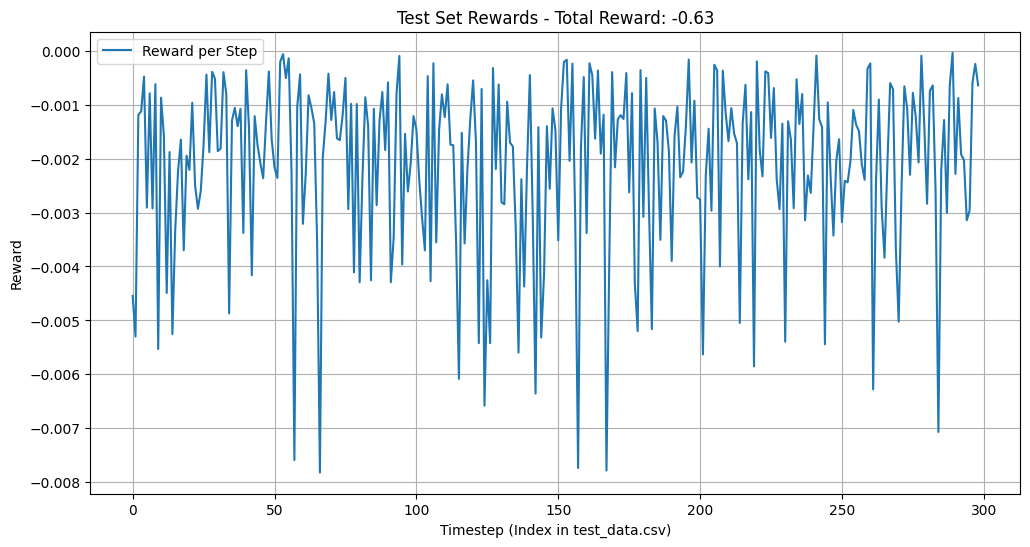

In [35]:
def run_test_evaluation(agent, env):
    """
    Runs the agent on the entire test environment in greedy mode.

    Args:
        agent: The trained PPOAgent model (in .eval() mode).
        env: The test TrafficEnv instance.

    Returns:
        float: The total reward obtained over the entire dataset.
        list: A list of rewards obtained at each step.
    """
    print("\nStarting final evaluation on test data...")
    state, info = env.reset()
    done = False
    total_reward = 0
    step_rewards = []

    #Run until the episode (end of the dataset) is done
    with torch.no_grad():
        while not done:
            # Agent selects the best action (greedy/argmax because of agent.act logic)
            action, _ = agent.act(state)

            # Step the environment
            next_state, reward, done, truncated, info = env.step(action)

            total_reward += reward
            step_rewards.append(reward)
            state = next_state

    print("✔ Evaluation complete.")
    print(f"Total steps: {len(step_rewards)}")
    print(f"Final Total Reward: {total_reward:.4f}")

    return total_reward, step_rewards

# 3. Run Evaluation
if 'loaded_agent' in locals() and 'test_env' in locals():
    # Run the evaluation
    final_reward, rewards_per_step = run_test_evaluation(loaded_agent, test_env)

    #Sequential rewards
    plt.figure(figsize=(12, 6))
    plt.plot(rewards_per_step, label="Reward per Step")
    plt.title(f"Test Set Rewards - Total Reward: {final_reward:.2f}")
    plt.xlabel("Timestep (Index in test_data.csv)")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    plt.show()